This Jupyter Notebook, authored by Norman Reynaldo Sabillon Castro, implements a sophisticated methodology for time series analysis, applying it to Honduran fuel prices. The core of the analysis uses the SRep (Stochastic Representation) algorithm, a method developed by PhD Fredy Vides, to model the dynamic behavior of the data.

The notebook's primary goal is to analyze the weekly percentage change in fuel prices (Super, Regular, Diesel, Kerosene). It transforms the price data into a sequence of states or "regimes" (e.g., "stable," "moderate increase," "sharp decrease"). By modeling the probabilities of transitioning between these states, the system aims to understand the underlying dynamics of fuel price fluctuations and evaluate its predictive power.

# ===============================================================
# STEP 1: SETUP, PARAMETERS, AND DATA LOADING
# ===============================================================

In [24]:
# --- 1. Library Imports ---

# Standard Library
import os
import sys
import warnings
from collections import Counter

# Data Handling & Numerical Computation
import pandas as pd
import numpy as np
from scipy.optimize import nnls
# from scipy.linalg import kron
from scipy.interpolate import make_interp_spline
from numpy.lib.stride_tricks import sliding_window_view 

# Machine Learning & Statistics
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, pairwise_distances_argmin
from sklearn.model_selection import TimeSeriesSplit

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import graphviz
from PIL import Image
from graphviz import Digraph
from scipy.stats import mode

# --- 2. Warning Suppression ---

# Suppress common warnings for a cleaner output.
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- 3. Model and Optimization Parameters ---

# K-Means Clustering Parameters
OPTIMAL_K = None                # If None, K is determined automatically. Otherwise, set a fixed integer.
FIXED_K_QUANTILES = 4           # Number of clusters for quantile-based analysis if not optimized.
USE_OPTIMAL_FOR_QUANTILES = False # If True, uses OPTIMAL_K for quantile analysis.
OPTIMAL_K_QUANTILES = None      # Stores the determined optimal K for quantiles.
K_RANGE = range(2, 12)          # Range of K values to test for finding the optimal number of clusters.

# Time Series & Model Parameters
np.random.seed(42)              # Seed for reproducibility of random operations.
W = 2                           # Window size or lag parameter for time series features.
LAMBDA = 0.95                   # Exponential weighting factor or regularization parameter.

# Data Storage
alphas_full = {}                # Dictionary to store model coefficients (alphas).

# --- 4. Plotting and File Configuration ---

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Paths and Files
CSV_PATH = "Combustibles.csv"
OUTPUT_FOLDER_OPTIMIZED = "optimized_outputs" # New folder for results.
os.makedirs(OUTPUT_FOLDER_OPTIMIZED, exist_ok=True)

# --- 5. Data Loading Function ---

def load_fuel_data(file_path):
    """
    Loads fuel price data from a specified CSV file.

    This function reads a CSV file, standardizes the date column name,
    and extracts fuel price series into a dictionary of NumPy arrays.
    It includes error handling for file not found and missing columns.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The loaded data as a pandas DataFrame.
            - dict: A dictionary of fuel price time series as NumPy arrays.
              Returns (None, None) if loading fails.
    """
    try:
        data = pd.read_csv(file_path)
        print(f"File '{file_path}' loaded successfully.")

        # Standardize the date column name from 'Fecha' to 'Date'
        if 'Fecha' in data.columns:
            data.rename(columns={'Fecha': 'Date'}, inplace=True)

        required_cols = ['Super', 'Regular', 'Diesel', 'Kerosene']
        if not all(col in data.columns for col in required_cols):
            print(f"Error: CSV must contain the columns: {required_cols}")
            return None, None

        series = {
            col: np.asarray(data[col].values, dtype=float)
            for col in required_cols
        }
        
        print(f"Available series: {list(series.keys())}")
        return data, series

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

# --- 6. Main Execution Block ---

if __name__ == "__main__":
    # This block runs only when the script is executed directly.
    
    # Load the data using the dedicated function.
    fuel_data, fuel_series = load_fuel_data(CSV_PATH)

    # Proceed only if data was loaded successfully.
    if fuel_data is not None and fuel_series is not None:
        print("\n--- Initial Data Preview ---")
        print(fuel_data.head())
        print("\nSetup complete. Data is ready for analysis.")
        # The rest of the analysis script would continue here...
    else:
        print("\nScript terminated due to data loading errors.")

File 'Combustibles.csv' loaded successfully.
Available series: ['Super', 'Regular', 'Diesel', 'Kerosene']

--- Initial Data Preview ---
                  Date  Super  Regular  Diesel  Kerosene
0  2017-01-02 00:00:00  88.66    80.50   71.53     51.59
1  2017-01-09 00:00:00  89.68    81.71   72.11     52.24
2  2017-01-16 00:00:00  90.25    82.45   72.30     52.66
3  2017-01-23 00:00:00  90.53    82.52   72.09     52.75
4  2017-01-30 00:00:00  90.43    82.28   71.96     52.85

Setup complete. Data is ready for analysis.


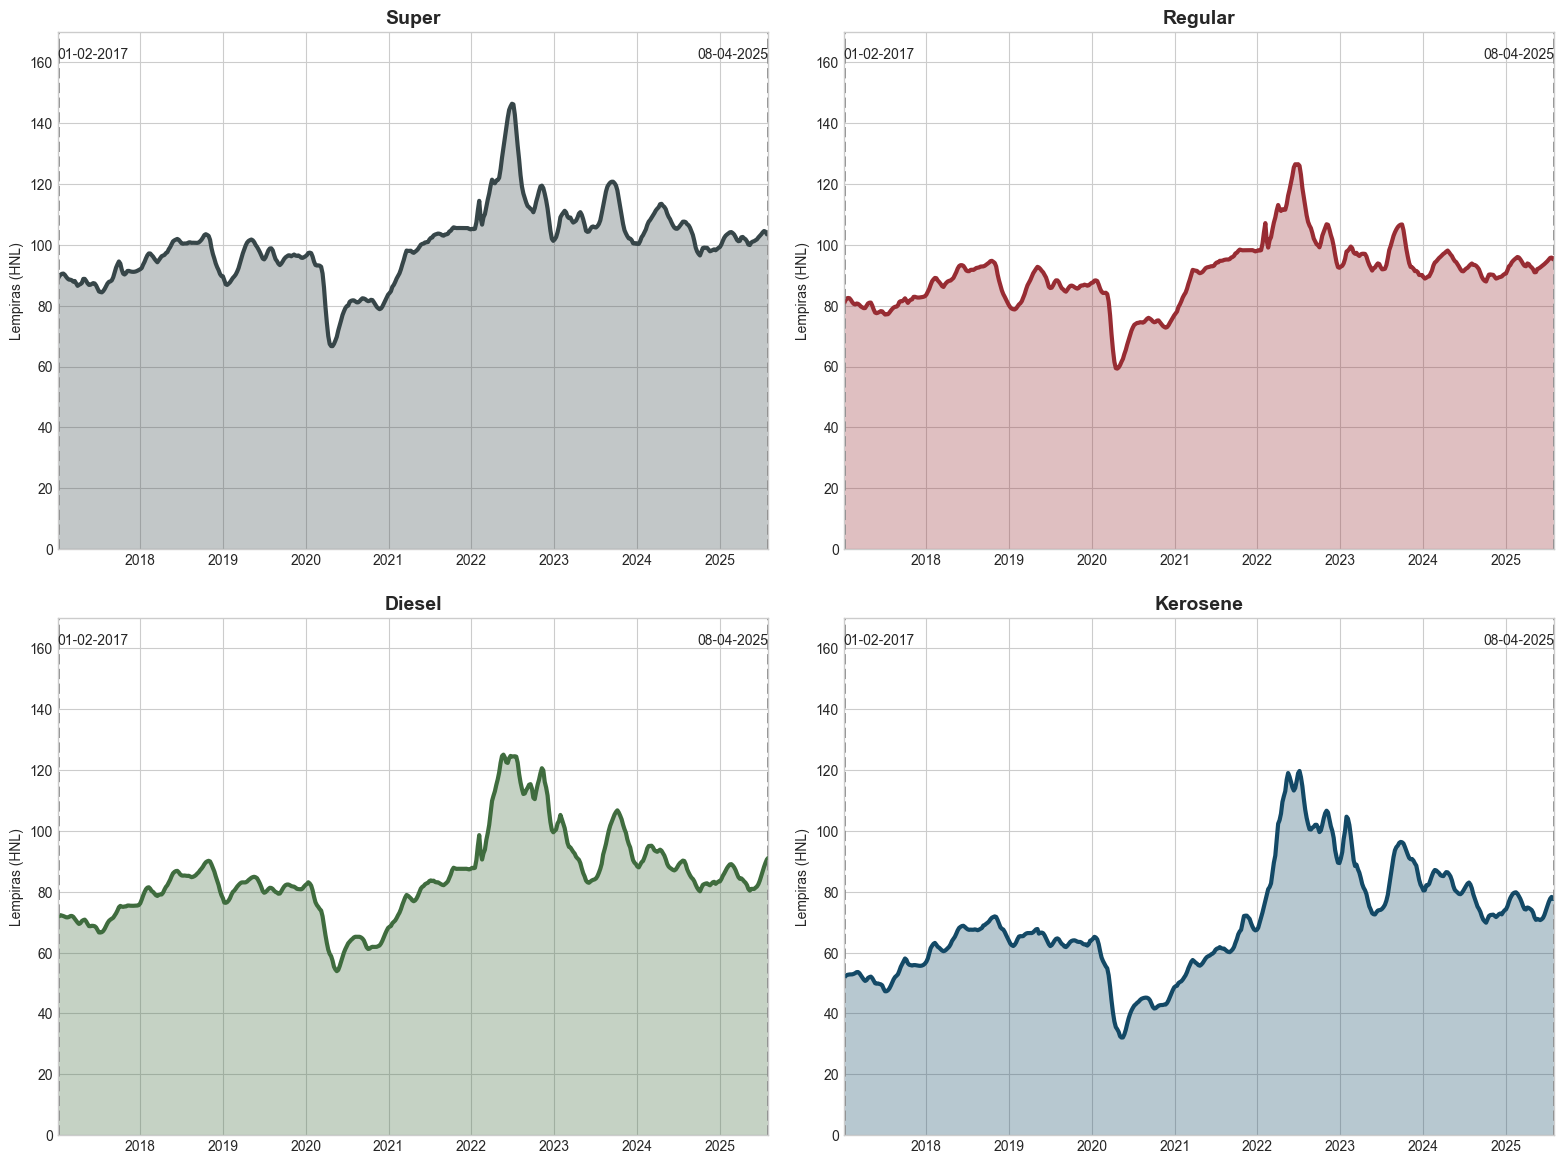

PNG chart saved at 600dpi: optimized_outputs\fuel_prices_summary_600dpi.png
PDF chart saved at 600dpi: optimized_outputs\fuel_prices_summary_600dpi.pdf


In [2]:
"""
Fuel Price Time Series Visualization

This script section processes the loaded fuel price data to create a
2x2 summary plot showing the price evolution for each fuel type.
Each subplot features a smoothed trend line with a shaded area underneath,
and is formatted for clarity and high-resolution export.

Continuation of the main analysis script.
"""

# --- 1. Data and Date Preparation ---

# Ensure the 'Date' column is in datetime format, dropping rows with invalid dates.
fuel_data['Date'] = pd.to_datetime(fuel_data['Date'], errors='coerce')
fuel_data = fuel_data.dropna(subset=['Date'])

# Extract date range for plot boundaries.
dates = fuel_data['Date']
date_min = dates.min()
date_max = dates.max()

# --- 2. Plotting Configuration ---

# Define a custom color palette for each fuel type for consistent branding.
fuel_colors = {
    'Super': '#374649',     # Dark gray
    'Regular': '#982C33',   # Dark red
    'Diesel': '#3F6C3E',    # Green
    'Kerosene': '#134966'   # Dark blue
}

# --- 3. Plot Styling Helper Function ---

def style_subplot(ax, title, date_min, date_max, y_limit_max=170):
    """
    Applies consistent styling to a matplotlib subplot.

    This function encapsulates all the common styling options, including titles,
    labels, limits, reference lines, and tick formatting, to avoid
    code repetition.

    Args:
        ax (matplotlib.axes.Axes): The subplot to style.
        title (str): The title for the subplot.
        date_min (pd.Timestamp): The minimum date for the x-axis limit and vline.
        date_max (pd.Timestamp): The maximum date for the x-axis limit and vline.
        y_limit_max (int, optional): The upper limit for the y-axis. Defaults to 170.
    """
    # Set titles and labels
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylabel("Lempiras (HNL)", fontsize=10)

    # Set axis limits
    ax.set_ylim(0, y_limit_max)
    ax.set_xlim(date_min, date_max)

    # Add vertical reference lines for start and end dates
    ax.axvline(x=date_min, color='gray', linestyle='--', linewidth=2)
    ax.axvline(x=date_max, color='gray', linestyle='--', linewidth=2)

    # Add date annotations dynamically positioned near the top of the plot
    y_pos_text = y_limit_max * 0.97  # Position text at 97% of the y-axis height
    ax.text(date_min, y_pos_text, date_min.strftime('%m-%d-%Y'), fontsize=10, ha='left', va='top')
    ax.text(date_max, y_pos_text, date_max.strftime('%m-%d-%Y'), fontsize=10, ha='right', va='top')

    # Format x-axis to show years only
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Configure tick parameters
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# --- 4. Main Plotting Loop ---

# Create a 2x2 figure and flatten the axes array for easy iteration.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Iterate through each fuel type to create a subplot.
for idx, (fuel, color) in enumerate(fuel_colors.items()):
    ax = axes[idx]
    y = fuel_series[fuel]
    x_numeric = mdates.date2num(dates)

    # Create a smooth curve using a cubic spline for better trend visualization.
    x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 500)
    spline = make_interp_spline(x_numeric, y, k=3)
    y_smooth = spline(x_smooth)
    x_smooth_dates = mdates.num2date(x_smooth)

    # Plot the smoothed data
    ax.fill_between(x_smooth_dates, y_smooth, color=color, alpha=0.3, label=f'{fuel} Price Area')
    ax.plot(x_smooth_dates, y_smooth, color=color, linewidth=3, label=f'{fuel} Smoothed Trend')

    # Apply the consistent styling using the helper function
    style_subplot(ax, title=fuel, date_min=date_min, date_max=date_max)

# --- 5. Final Layout and Export ---

# Adjust layout to prevent labels from overlapping.
plt.tight_layout(pad=2.0)

# Define output file paths.
png_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "fuel_prices_summary_600dpi.png")
pdf_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "fuel_prices_summary_600dpi.pdf")

# Save the figure in high resolution to both PNG and PDF formats.
fig.savefig(png_path, dpi=600, format='png', bbox_inches='tight')
fig.savefig(pdf_path, dpi=600, format='pdf', bbox_inches='tight')

# Display the plot.
plt.show()

print(f"PNG chart saved at 600dpi: {png_path}")
print(f"PDF chart saved at 600dpi: {pdf_path}")

## ===============================================================
## STEP 2: CORE METHODOLOGY FUNCTIONS
## ===============================================================

This block contains all the core functions that implement the SRep methodology, ordered logically based on their dependencies. The functions handle key steps of the process:

  1. `calculate_alphas`: Computes the weighted relative change of the time series.
  2. `discretize_*`: Converts the continuous `alpha` series into discrete states.
  3. `states_to_onehot_matrix`: A utility to format state data for SRep.
  4. `calculate_count_matrix`: A helper to count state transitions, needed for AIC.
  5. `SRep`: The core estimator for the transition matrix using NNLS.
  6. `calculate_aic`: Calculates AIC based on the SRep-estimated matrix.
  7. `compute_predictive_metrics`: Evaluates model performance.
  8. `plot_transition_graph`: Visualizes the final transition matrix.

In [3]:
# --- 1. Feature Engineering ---
def calculate_alphas(time_series, W, lambda_):
    """
    Computes a sequence of local, weighted relative change rates (alpha_t)
    in a fully vectorized and efficient manner.

    This function moves a sliding window over the time series and, for each
    window, calculates a weighted relative change rate. This implementation
    avoids Python loops for performance.

    Args:
        time_series (np.ndarray): The 1D input time series data.
        W (int): The size of the sliding window.
        lambda_ (float): The exponential decay factor for weighting observations.

    Returns:
        np.ndarray: A 1D array of the calculated alpha_t values.
    """
    # Create sliding window views of the data without copying memory
    # Requires NumPy version 1.20 or newer
    from numpy.lib.stride_tricks import sliding_window_view
    
    T = len(time_series)
    if T <= W:
        return np.array([])

    # Create weights vector
    weights = np.array([lambda_**i for i in range(W)])[::-1]

    # Create sliding windows for current and previous values
    # current_windows shape: (T-W, W)
    # previous_windows shape: (T-W, W)
    current_windows = sliding_window_view(time_series, window_shape=W)[1:]
    previous_windows = sliding_window_view(time_series, window_shape=W)[:-1]

    # Perform calculations for all windows at once (vectorized)
    # np.einsum is highly efficient for this kind of weighted sum
    numerator = np.einsum('i,ji->j', weights, current_windows * previous_windows)
    denominator = np.einsum('i,ji->j', weights, previous_windows**2)

    # Initialize alphas as zeros
    alphas = np.zeros_like(denominator)

    # Calculate alpha_t only where the denominator is non-zero
    non_zero_denom_mask = denominator != 0
    alphas[non_zero_denom_mask] = -1 + (numerator[non_zero_denom_mask] / denominator[non_zero_denom_mask])

    return alphas


In [4]:
# --- 2. Discretization Methods ---

def discretize_by_kmeans(alphas, k):
    """
    Discretizes the alpha_t series using K-Means and orders the states by centroids.

    This method groups continuous alpha values into k clusters. States are then
    re-labeled based on the ascending order of their cluster centers.

    Args:
        alphas (np.ndarray): The 1D array of continuous alpha_t values.
        k (int): The number of clusters (regimes) to create.

    Returns:
        tuple: (ordered_states, ordered_centroids)
    """
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(alphas.reshape(-1, 1))
    states = kmeans.labels_
    centroids = kmeans.cluster_centers_.flatten()

    # Create an index that sorts the centroids
    sorted_indices = np.argsort(centroids)

    # Create a mapping array for efficient, vectorized re-labeling
    # The value at each original label index will be its new, sorted label
    state_map = np.zeros_like(sorted_indices)
    state_map[sorted_indices] = np.arange(k)
    ordered_states = state_map[states]

    return ordered_states, centroids[sorted_indices]

In [5]:
def discretize_by_quantiles(alphas, num_regimes=4):
    """Discretizes the alpha_t series using quantiles of its empirical distribution.

    This method divides the data into a specified number of intervals with an
    equal number of observations.

    Parameters
    ----------
    alphas : array_like
        The 1D array of continuous alpha_t values to be discretized.
    num_regimes : int, optional
        The number of desired regimes (states). Default is 4.

    Returns
    -------
    states : ndarray
        A 1D integer array containing the assigned discrete state for each
        alpha value, ranging from 0 to num_regimes-1.
    boundaries : ndarray
        A 1D array containing the quantile values used as bin edges for
        the discretization.
    """
    boundaries = np.quantile(alphas, q=np.linspace(0, 1, num_regimes + 1)[1:-1])
    states = np.digitize(alphas, bins=boundaries)
    
    return states, boundaries

In [6]:
# --- 3. Data Transformation and Helper Functions ---
def states_to_onehot_matrix(states, num_states):
    """Converts a sequence of integer-coded states into a one-hot encoded matrix.

    This function creates the data matrix required by the SRep estimation
    function, where each column represents a state at a specific time step.

    Parameters
    ----------
    states : array_like
        A 1D array or list of integer states, where each integer corresponds
        to a specific regime (e.g., [0, 1, 3, 2, ...]).
    num_states : int
        The total number of possible states (k), which determines the number
        of rows in the output matrix.

    Returns
    -------
    ndarray
        A 2D NumPy array of shape (num_states, len(states)) containing the
        one-hot encoded sequence.
    """
    num_samples = len(states)
    one_hot_matrix = np.zeros((num_states, num_samples))
    states = np.array(states, dtype=int)
    
    # Use advanced NumPy indexing to efficiently populate the matrix
    one_hot_matrix[states, np.arange(num_samples)] = 1
    
    return one_hot_matrix

In [7]:
def calculate_count_matrix(states, num_states):
    """
    Computes the transition count matrix from a sequence of discrete states
    in a fully vectorized manner.

    Resulting matrix C is structured such that C[i, j] contains the number of
    observed transitions FROM state j TO state i.

    Args:
        states (array_like): A 1D array or list of integer states.
        num_states (int): The total number of possible states (k).

    Returns:
        np.ndarray: The transition count matrix `C` of shape (num_states, num_states).
    """
    # Initialize a square matrix of zeros.
    C = np.zeros((num_states, num_states), dtype=int)
    
    # Get pairs of (from_state, to_state) for all transitions.
    from_states = states[:-1]
    to_states = states[1:]
    
    # Use np.add.at for efficient, vectorized counting without loops.
    # It adds 1 to each (to_state, from_state) index for every observed transition.
    np.add.at(C, (to_states, from_states), 1)
    
    return C

In [8]:
# --- 4. Core Transition Matrix Estimation (Corrected Logic) ---

def SRep(data, num_samples):
    """
    Estimates a column-stochastic transition matrix using NNLS.
    This version is updated to use numpy.kron to avoid DeprecationWarnings.

    Args:
        data (np.array): One-hot encoded time series data.
        num_samples (int): The number of time steps for estimation.

    Returns:
        np.array: The estimated column-stochastic transition matrix Pr.
    """
    num_states = data.shape[0]

    # 1. Construct the design matrix S0 and target vector S1
    S0_data = data[:, :num_samples]
    # UPDATED: Changed kron(...) to np.kron(...)
    S0 = np.kron(S0_data, np.identity(num_states)).T
    S1 = S0.T @ (data[:, 1:(1 + num_samples)].T).reshape(num_samples * num_states)

    # 2. Construct the sum-to-one constraint matrix C
    # UPDATED: Changed kron(...) to np.kron(...)
    C = np.kron(np.identity(num_states), np.ones((1, num_states)))

    # 3. Build the augmented matrix `Mr`
    Mr = np.zeros((num_states**2 + num_states, num_states**2))
    Mr[:num_states**2, :] = S0.T @ S0
    Mr[num_states**2:, :] = C

    # 4. Build the augmented right-hand side vector `rhs`
    rhs = np.zeros((num_states**2 + num_states))
    rhs[:num_states**2] = S1
    rhs[num_states**2:] = 1

    # 5. Solve the NNLS problem
    p_flat = nnls(Mr, rhs)[0]
    c = p_flat.reshape(-1, 1)

    # 6. Reshape and normalize
    Pr = c.reshape(num_states, num_states).T
    col_sums = Pr.sum(axis=0)
    col_sums[col_sums == 0] = 1
    Pr = Pr / col_sums

    return Pr

In [9]:
# --- 5. Model Selection (AIC) ---

def calculate_aic(states, k, P_matrix):
    """
    Calculates the Akaike Information Criterion (AIC) for a given Markov chain
    using a pre-computed transition matrix (e.g., from SRep).

    Args:
        states (array_like): The sequence of observed discrete states.
        k (int): The total number of possible states in the model.
        P_matrix (np.ndarray): The pre-computed transition probability matrix,
                               where P[j, i] is the probability of P(j|i).

    Returns:
        float: The calculated AIC score. Returns np.inf on failure.
    """
    if len(states) < 2:
        return np.inf

    # 1. Calculate the transition count matrix `C` from observed states.
    # C[j, i] = number of transitions from state i to state j.
    C = calculate_count_matrix(states, num_states=k)

    # 2. Calculate the log-likelihood using the provided P_matrix.
    # The formula is Sum(C[i,j] * log(P[i,j])) over all i,j.
    # We only sum where counts are non-zero to avoid unnecessary computation
    # and to ensure we only evaluate observed transitions.
    log_likelihood = np.sum(C[C > 0] * np.log(P_matrix[C > 0]))

    if not np.isfinite(log_likelihood):
        return np.inf

    # 3. Calculate the number of free parameters.
    # For a k x k transition matrix, there are k * (k-1) free parameters.
    num_params = float(k * (k - 1))

    # 4. Calculate the final AIC score.
    aic_score = 2 * num_params - 2 * log_likelihood

    return aic_score

In [10]:
# --- 6. Model Evaluation (Corrected) ---

def compute_predictive_metrics(alphas, series, k, W, method='kmeans', use_cv=False, return_splits=False):
    """
    Computes and averages state prediction accuracy and value RMSE across validation splits.

    This function provides a consistent framework for evaluating the predictive
    performance of the SRep-based Markov model using forward-chaining prediction.

    Args:
        alphas (np.ndarray): Continuous alpha values.
        series (np.ndarray): Original time series values.
        k (int): Number of states.
        W (int): Window size used to calculate alphas.
        method (str): Discretization method, 'kmeans' or 'quantiles'.
        use_cv (bool): If True, use TimeSeriesSplit; otherwise, use rolling-origin splits.
        return_splits (bool): If True, return detailed results for each split.

    Returns:
        tuple: (average_accuracy, average_rmse) or (avg_acc, avg_rmse, details_list)
    """
    results = []
    partition_details = []

    if use_cv:
        tscv = TimeSeriesSplit(n_splits=5)
        splits = list(tscv.split(alphas))
    else:
        ratios = np.arange(0.60, 0.96, 0.05)
        splits = [(np.arange(0, int(len(alphas) * r)), np.arange(int(len(alphas) * r), len(alphas))) for r in ratios]

    for idx, (train_idx, test_idx) in enumerate(splits):
        if len(test_idx) < 2 or len(train_idx) < k: continue

        alphas_train, alphas_test = alphas[train_idx], alphas[test_idx]
        
        # Align original series with alpha series for value prediction
        series_test = series[test_idx[0] + W : test_idx[-1] + W + 1]

        # --- Discretization (Fit on Train, Transform on Test) ---
        if method == 'kmeans':
            states_train, centroids = discretize_by_kmeans(alphas_train, k)
            states_test = pairwise_distances_argmin(alphas_test.reshape(-1, 1), centroids.reshape(-1, 1)).flatten()
        else: # quantiles
            boundaries = np.quantile(alphas_train, np.linspace(0, 1, k + 1)[1:-1])
            states_train = np.digitize(alphas_train, boundaries)
            states_test = np.digitize(alphas_test, boundaries)
            centroids = np.array([alphas_train[states_train == i].mean() for i in range(k)])
            centroids[np.isnan(centroids)] = 0

        # --- Model Training ---
        matrix_train = states_to_onehot_matrix(states_train, k)
        num_trans = matrix_train.shape[1] - 1
        if num_trans <= 0: continue
        P_hat = SRep(matrix_train, num_trans)

        # --- Prediction Loop ---
        preds, actuals, preds_val, actuals_val = [], [], [], []
        last_state = states_train[-1] # Initialize with the last known state
        
        for i in range(len(states_test)):
            pred_state = np.argmax(P_hat[:, last_state])
            preds.append(pred_state)
            actuals.append(states_test[i])
            
            # Predict the next value in the original time series
            if i < len(series_test) - 1:
                pred_alpha = centroids[pred_state]
                pred_value = series_test[i] * (1 + pred_alpha)
                preds_val.append(pred_value)
                actuals_val.append(series_test[i + 1])
            
            # Use the PREDICTED state for the next iteration
            last_state = pred_state

        # --- Calculate and Store Metrics ---
        acc = np.mean(np.array(preds) == np.array(actuals)) if preds else 0
        rmse = np.sqrt(mean_squared_error(actuals_val, preds_val)) if actuals_val else 0
        results.append({'acc': acc, 'rmse': rmse})

        if return_splits:
            split_label = f"CV Fold {idx+1}" if use_cv else f"{int(ratios[idx]*100)}%/{100-int(ratios[idx]*100)}%"
            partition_details.append({
                'Split (Train/Test)': split_label,
                'Accuracy': f"{acc:.2%}", 'RMSE': f"{rmse:.4f}"
            })

    # --- Aggregate and Return Results ---
    avg_acc = np.mean([r['acc'] for r in results]) if results else 0
    avg_rmse = np.mean([r['rmse'] for r in results]) if results else 0

    return (avg_acc, avg_rmse, partition_details) if return_splits else (avg_acc, avg_rmse)

In [11]:
# --- 7. Visualization ---
def plot_transition_graph(Ap, series_name, centroids=None, output_dir='optimized_outputs'):
    """
    Generate a transition graph from Ap matrix with fixed node size and fixed layout.
    """
    k = Ap.shape[0]
    node_labels = [f'R{i+1}' for i in range(k)]
    node_colors = sns.color_palette("pastel", n_colors=4).as_hex()  # Force 4-color palette max for visual consistency

    dot = Digraph(format='png')
    
    # --- Global layout control for visual uniformity ---
    dot.attr(
        rankdir='LR',
        size='6,4',        # Width x Height in inches (Graphviz internal, not final output)
        dpi='300',
        ratio='compress',
        nodesep='1.0',
        ranksep='1.0',
        margin='0.1'
    )

    # --- Uniform node styling ---
    for i in range(k):
        r_label = node_labels[i]
        alpha_val = f"α≈{centroids[i]:.3f}" if centroids is not None else ""
        label = f"<<B>{r_label}</B><BR/><FONT POINT-SIZE='10'>{alpha_val}</FONT>>"

        dot.node(
            f's{i}',
            label=label,
            shape='circle',
            fixedsize='true',
            width='1.4',
            height='1.4',
            style='filled',
            fillcolor=node_colors[i % 4],
            fontsize='14'
        )

    # --- Add edges with labels ---
    for i in range(k):
        for j in range(k):
            prob = Ap[j, i]  # From i to j
            if prob >= 0.01:
                label = f'{int(round(prob * 100))}%'
                dot.edge(
                    f's{i}', f's{j}',
                    label=label,
                    fontsize='10',
                    arrowsize='0.6'
                )

    # --- Export ---
    filename = f"{output_dir}/graph_kmeans_{series_name.lower()}"
    dot.render(filename, cleanup=True)
    print(f"Transition graph for {series_name} saved as: {filename}.png")

## ===============================================================
## STEP 3: OPTIMIZATION OF THE NUMBER OF REGIMES (k)
## ===============================================================

This block iterates through each time series and each potential number of states (k) to find the optimal model configuration based on a multi-criteria selection process.

The process for each 'k' is:
 1. Build a model on the FULL dataset to calculate its AIC score.
 2. Perform cross-validation to get robust predictive metrics (Accuracy, RMSE).

The best 'k' is chosen using a tie-breaking rule:
 - Highest Accuracy, then...
 - Lowest RMSE, then...
 - Lowest AIC.

In [12]:
# =====================================================================
# SCRIPT COMPLETO CON ORDEN DE SALIDA CORREGIDO
# =====================================================================

print("\n--- PASO FINAL: Iniciando Búsqueda Grid 3D Completa y Detallada ---")
print("⚠️ ADVERTENCIA: Este proceso es computacionalmente intensivo y puede tomar mucho tiempo.")

import time
import pandas as pd
from itertools import product
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
import os
import sys

# --- 1. Redefinición de TODAS las Funciones Auxiliares ---

def calculate_alphas_corrected(series, W, lambda_decay):
    v = np.asarray(series)
    if len(v) < W:
        return np.array([])
    alphas = []
    for t in range(W - 1, len(v)):
        numerator_terms = [lambda_decay**(t - k) * v[k] * v[k-1] for k in range(t - W + 1, t + 1)]
        denominator_terms = [lambda_decay**(t - k) * v[k-1]**2 for k in range(t - W + 1, t + 1)]
        numerator = np.sum(numerator_terms)
        denominator = np.sum(denominator_terms)
        if denominator == 0:
            beta_t = 1.0
        else:
            beta_t = numerator / denominator
        alphas.append(beta_t - 1)
    return np.array(alphas)

def discretize_series_corrected(alphas, k):
    alphas_reshaped = alphas.reshape(-1, 1)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(alphas_reshaped)
    states = kmeans.predict(alphas_reshaped)
    centroids = kmeans.cluster_centers_.flatten()
    return states, centroids

def estimate_transition_matrix_corrected(states, k):
    P = np.zeros((k, k))
    C = np.zeros((k, k))
    for i in range(len(states) - 1):
        P[states[i+1], states[i]] += 1
        C[states[i+1], states[i]] += 1
    
    col_sums = P.sum(axis=0)
    P = np.divide(P, col_sums, out=np.zeros_like(P), where=col_sums!=0)
    return P, C

def compute_predictive_metrics_detailed(alphas, series, k, W):
    price_series_values = np.asarray(series)
    results_per_split = []
    ratios = np.arange(0.60, 0.96, 0.05)
    splits = [(np.arange(0, int(len(alphas) * r)), np.arange(int(len(alphas) * r), len(alphas))) for r in ratios]

    for i, (train_idx, test_idx) in enumerate(splits):
        if len(test_idx) < 2 or len(train_idx) < k: continue
        
        accuracy, rmse = np.nan, np.nan
        
        alphas_train, alphas_test = alphas[train_idx], alphas[test_idx]
        train_states, regime_reps = discretize_series_corrected(alphas_train, k)
        P, _ = estimate_transition_matrix_corrected(train_states, k)
        
        test_states = np.array([np.argmin(np.abs(alpha - regime_reps)) for alpha in alphas_test])

        if len(train_states) > 0:
            predicted_states = []
            current_state = train_states[-1]
            for _ in range(len(alphas_test)):
                if current_state < P.shape[1]:
                    next_state = np.argmax(P[:, current_state])
                else:
                    next_state = 0
                predicted_states.append(next_state)
                current_state = next_state
            
            accuracy = accuracy_score(test_states, predicted_states)
            predicted_alphas = np.array([regime_reps[s] for s in predicted_states])
            
            last_prices_idx = test_idx + W - 2
            actual_prices_idx = test_idx + W - 1
            
            if np.max(last_prices_idx) < len(price_series_values) and np.max(actual_prices_idx) < len(price_series_values):
                last_prices = price_series_values[last_prices_idx]
                actual_prices = price_series_values[actual_prices_idx]
                if len(predicted_alphas) == len(last_prices):
                    predicted_prices = last_prices * (1 + predicted_alphas)
                    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
        
        results_per_split.append({
            'Partition': f"{int(ratios[i]*100)}/{int((1-ratios[i])*100)}",
            'Accuracy': accuracy,
            'RMSE': rmse
        })
        
    return results_per_split

# --- 2. Definición del Espacio de Búsqueda de Hiperparámetros ---
w_range = range(2 , 53) 
lambda_range = np.arange(0.8, 1.01, 0.01)
k_range_search = range(2, 10)

grid_search_results = []

# --- 3. Ejecución de la Búsqueda Grid con Barra de Progreso ---
if 'fuel_series' in locals() and 'OUTPUT_FOLDER_OPTIMIZED' in locals():
    start_time_grid = time.time()
    for name, series in fuel_series.items():
        print(f"\n" + "="*80)
        print(f"Procesando Búsqueda Grid para: {name.upper()}")
        
        param_grid = list(product(w_range, np.round(lambda_range, 2), k_range_search))
        total_combinations_series = len(param_grid)
        
        for i, (w_val, lambda_val, k_val) in enumerate(param_grid):
            progress = (i + 1) / total_combinations_series
            bar_length = 30
            block = int(round(bar_length * progress))
            text = f"\r  - Progreso: [{'#' * block + '-' * (bar_length - block)}] {progress*100:.1f}% ({i+1}/{total_combinations_series})"
            sys.stdout.write(text)
            sys.stdout.flush()

            try:
                alphas = calculate_alphas_corrected(series, W=w_val, lambda_decay=lambda_val)
                if len(alphas) < k_val * 2: continue

                states_full, _ = discretize_series_corrected(alphas, k_val)
                P_full, C_full = estimate_transition_matrix_corrected(states_full, k_val)
                log_likelihood = np.sum(C_full * np.log(P_full + 1e-9))
                aic = 2 * k_val * (k_val - 1) - 2 * log_likelihood

                partition_results = compute_predictive_metrics_detailed(alphas, series, k_val, w_val)
                
                for result in partition_results:
                    grid_search_results.append({
                        'Fuel Series': name, 'W': w_val, 'Lambda': lambda_val,
                        'k': k_val, 'Partition': result['Partition'],
                        'Accuracy': result['Accuracy'], 'RMSE': result['RMSE'], 'AIC': aic
                    })
            except Exception:
                continue
        print()

    end_time_grid = time.time()
    print(f"\n✅ Búsqueda Grid completada en {(end_time_grid - start_time_grid) / 60:.2f} minutos.")
    
    # --- 4. SECCIÓN MODIFICADA: Procesar con la Nueva Lógica de Selección ---
    if grid_search_results:
        # REPORTE 1: DETALLE COMPLETO
        df_detailed_results = pd.DataFrame(grid_search_results).dropna()
        csv_path_detailed = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "20_final_grid_search_detailed.csv")
        df_detailed_results.to_csv(csv_path_detailed, index=False, float_format='%.10f')
        print(f"\n✅ REPORTE 1: Resultados detallados por partición guardados en: '{csv_path_detailed}'")

        # REPORTE 2: RESUMEN (PROMEDIOS POR COMBINACIÓN)
        df_summary = df_detailed_results.groupby(['Fuel Series', 'W', 'Lambda', 'k']).agg(
            Accuracy=('Accuracy', 'mean'),
            RMSE=('RMSE', 'mean'),
            AIC=('AIC', 'first')
        ).reset_index()
        csv_path_summary = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "21_grid_search_summary.csv")
        df_summary.to_csv(csv_path_summary, index=False, float_format='%.10f')
        print(f"✅ REPORTE 2: Resumen de métricas promediadas guardado en: '{csv_path_summary}'")

        # --- INICIO DE LA NUEVA LÓGICA DE SELECCIÓN ---
        print("\nAplicando nueva lógica de selección: 1º Filtrar por Accuracy < 95%, 2º Minimizar RMSE...")
        
        ACCURACY_THRESHOLD = 0.95
        df_realistic_summary = df_summary[df_summary['Accuracy'] < ACCURACY_THRESHOLD].copy()

        if not df_realistic_summary.empty:
            
            # =================================================================
            # --- AJUSTE PARA ORDENAR LA SALIDA ---
            # 1. Definir el orden deseado
            fuel_order = ['Super', 'Regular', 'Diesel', 'Kerosene']
            # 2. Convertir la columna a tipo Categórico con el orden especificado
            df_realistic_summary['Fuel Series'] = pd.Categorical(df_realistic_summary['Fuel Series'], categories=fuel_order, ordered=True)
            # =================================================================
            
            df_best_results = df_realistic_summary.sort_values(
                by=['Fuel Series', 'RMSE', 'Accuracy', 'AIC'], 
                ascending=[True, True, False, True]
            ).drop_duplicates(subset=['Fuel Series'], keep='first')
            
            csv_path_best = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "22_best_hyperparameters.csv")
            df_best_results.to_csv(csv_path_best, index=False, float_format='%.10f')
            print(f"✅ REPORTE 3: Mejores hiperparámetros (realistas) guardados en: '{csv_path_best}'")

            print("\n\n" + "="*80)
            print("         COMBINACIÓN ÓPTIMA FINAL DE HIPERPARÁMETROS (Basado en Rendimiento Realista)")
            print("="*80)
            print(df_best_results.to_string(float_format=lambda x: f"{x:.10f}"))
            print("="*80)
        else:
            print("\n⚠️ ADVERTENCIA: No se encontraron resultados realistas. Todos los modelos superaron el umbral de Accuracy del 95%.")

    else:
        print("\nERROR: La búsqueda Grid no produjo resultados. Por favor, revisa la configuración y los datos de entrada.")
else:
    print("Ejecución detenida: Las variables 'fuel_series' o 'OUTPUT_FOLDER_OPTIMIZED' no fueron encontradas.")


--- PASO FINAL: Iniciando Búsqueda Grid 3D Completa y Detallada ---
⚠️ ADVERTENCIA: Este proceso es computacionalmente intensivo y puede tomar mucho tiempo.

Procesando Búsqueda Grid para: SUPER
  - Progreso: [##############################] 100.0% (8568/8568)

Procesando Búsqueda Grid para: REGULAR
  - Progreso: [##############################] 100.0% (8568/8568)

Procesando Búsqueda Grid para: DIESEL
  - Progreso: [##############################] 100.0% (8568/8568)

Procesando Búsqueda Grid para: KEROSENE
  - Progreso: [##############################] 100.0% (8568/8568)

✅ Búsqueda Grid completada en 42.70 minutos.

✅ REPORTE 1: Resultados detallados por partición guardados en: 'optimized_outputs\20_final_grid_search_detailed.csv'
✅ REPORTE 2: Resumen de métricas promediadas guardado en: 'optimized_outputs\21_grid_search_summary.csv'

Aplicando nueva lógica de selección: 1º Filtrar por Accuracy < 95%, 2º Minimizar RMSE...
✅ REPORTE 3: Mejores hiperparámetros (realistas) guardados en

In [13]:
# =====================================================================
# STEP 3 — Integrated Optimization & Validation to report the optimal k
# (CON ORDEN DE SALIDA CORREGIDO)
# =====================================================================

print("\n--- STEP 3: Starting Integrated Optimization & Validation to find the optimal k ---")

import os
import numpy as np
import pandas as pd
from collections import Counter

# Required paths from STEP 3.1
CSV_SUMMARY            = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "21_grid_search_summary.csv")
CSV_BEST_HYPERPARAMS = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "22_best_hyperparameters.csv")
CSV_K_DETAILED         = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "23_k_optimization_detailed.csv")
CSV_K_SUMMARY          = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "24_optimal_k_per_series.csv")

# ---------------------------------------------------------------------
# Load STEP 3.1 outputs
# ---------------------------------------------------------------------
if 'df_best_results' in globals() and isinstance(df_best_results, pd.DataFrame) and not df_best_results.empty:
    best_df = df_best_results.copy()
else:
    if not os.path.exists(CSV_BEST_HYPERPARAMS):
        raise RuntimeError("Missing STEP 3.1 output: '22_best_hyperparameters.csv' not found.")
    best_df = pd.read_csv(CSV_BEST_HYPERPARAMS)

if 'df_summary' in globals() and isinstance(df_summary, pd.DataFrame) and not df_summary.empty:
    summary_df = df_summary.copy()
else:
    if not os.path.exists(CSV_SUMMARY):
        raise RuntimeError("Missing STEP 3.1 output: '21_grid_search_summary.csv' not found.")
    summary_df = pd.read_csv(CSV_SUMMARY)

# =================================================================
# --- AJUSTE PARA ORDENAR LA SALIDA ---
# 1. Definir el orden deseado
fuel_order = ['Super', 'Regular', 'Diesel', 'Kerosene']
# 2. Convertir la columna 'Fuel Series' de best_df a tipo Categórico
best_df['Fuel Series'] = pd.Categorical(best_df['Fuel Series'], categories=fuel_order, ordered=True)
# 3. Ordenar el DataFrame para asegurar que el procesamiento siga este orden
best_df = best_df.sort_values('Fuel Series')
# =================================================================

# Normalize dtypes for consistent filtering/printing
for df in (best_df, summary_df):
    for col in ['W', 'k']:
        if col in df.columns: df[col] = df[col].astype(int)
    if 'Lambda' in df.columns: df['Lambda'] = df['Lambda'].astype(float)

# ---------------------------------------------------------------------
# Build outputs (no recomputation)
# ---------------------------------------------------------------------
optimization_results = {}
optimal_ks = {}
w_optimal = {}
lambda_optimal = {}
detailed_rows = []

# La iteración ahora respetará el orden de 'best_df' que acabamos de forzar
series_order = list(best_df['Fuel Series'])

for series_name in series_order:
    row_best = best_df[best_df['Fuel Series'] == series_name].iloc[0]
    W_sel = int(row_best['W'])
    L_sel = float(row_best['Lambda'])
    k_sel = int(row_best['k'])

    w_optimal[series_name] = W_sel
    lambda_optimal[series_name] = L_sel
    optimal_ks[series_name] = k_sel

    mask = (
        (summary_df['Fuel Series'] == series_name) &
        (summary_df['W'] == W_sel) &
        (np.isclose(summary_df['Lambda'], L_sel, atol=1e-9))
    )
    per_k_df = summary_df.loc[mask, ['k', 'AIC', 'Accuracy', 'RMSE']].dropna()
    if per_k_df.empty:
        raise RuntimeError(
            f"No summary rows found in '21_grid_search_summary.csv' for series '{series_name}' "
            f"with W={W_sel}, Lambda={L_sel}."
        )

    per_k_df = per_k_df.sort_values('k').reset_index(drop=True)

    print(f"\n>>> Processing series: {series_name} <<<")
    for _, r in per_k_df.iterrows():
        k_val, aic_val, acc_val, rmse_val = int(r['k']), float(r['AIC']), float(r['Accuracy']), float(r['RMSE'])
        print(f"  k={k_val:<2} | AIC: {aic_val:<8.2f} | Avg Accuracy: {acc_val:<7.2%} | Avg RMSE: {rmse_val:.4f}")
        detailed_rows.append({
            'Fuel Series': series_name, 'W_used': W_sel, 'Lambda_used': L_sel, 'k': k_val,
            'AIC': aic_val, 'Avg Accuracy': acc_val, 'Avg RMSE': rmse_val
        })

    sel_row = per_k_df[per_k_df['k'] == k_sel]
    if sel_row.empty:
        raise RuntimeError(
            f"Selected k={k_sel} for '{series_name}' not found at W={W_sel}, Lambda={L_sel}."
        )
    aic_sel, acc_sel, rmse_sel = float(sel_row['AIC'].iloc[0]), float(sel_row['Accuracy'].iloc[0]), float(sel_row['RMSE'].iloc[0])

    print(f"  {'-'*66}")
    print(f"  >>> Best k for {series_name}: {k_sel} (Acc: {acc_sel:.2%}, RMSE: {rmse_sel:.4f}, AIC: {aic_sel:.2f})")

    optimization_results[series_name] = {
        'k_range': per_k_df['k'].astype(int).tolist(),
        'aic_scores': per_k_df['AIC'].astype(float).tolist(),
        'avg_accuracies': per_k_df['Accuracy'].astype(float).tolist(),
        'avg_rmses': per_k_df['RMSE'].astype(float).tolist()
    }

# ---------------------------------------------------------------------
# Final summary and global OPTIMAL_K
# ---------------------------------------------------------------------
print("\n" + "="*60)
print("Summary of Optimal k Values per Series:")
# El bucle ahora imprimirá en el orden correcto porque 'optimal_ks' se llenó en ese orden
for name, kval in optimal_ks.items():
    print(f"  - {name:<10}: k = {kval}")
print("="*60)

if not optimal_ks:
    raise RuntimeError("No optimal ks available.")
OPTIMAL_K = int(Counter(optimal_ks.values()).most_common(1)[0][0])

print(f"\nUsing globally determined OPTIMAL_K = {OPTIMAL_K} for subsequent steps.")
print("="*60)

# ---------------------------------------------------------------------
# Persist detail and summary
# ---------------------------------------------------------------------
if detailed_rows:
    try:
        df_k_detail = pd.DataFrame(detailed_rows)
        df_k_detail.to_csv(CSV_K_DETAILED, index=False, float_format='%.10f')

        df_k_summary = pd.DataFrame({
            'Fuel Series': list(optimal_ks.keys()),
            'W_optimal': [w_optimal[s] for s in optimal_ks.keys()],
            'Lambda_optimal': [lambda_optimal[s] for s in optimal_ks.keys()],
            'k_optimal': list(optimal_ks.values())
        })
        
        # =================================================================
        # --- AJUSTE FINAL PARA ORDENAR EL CSV DE SALIDA ---
        df_k_summary['Fuel Series'] = pd.Categorical(df_k_summary['Fuel Series'], categories=fuel_order, ordered=True)
        df_k_summary = df_k_summary.sort_values('Fuel Series').reset_index(drop=True)
        # =================================================================
        
        df_k_summary.to_csv(CSV_K_SUMMARY, index=False)
    except Exception as e:
        print(f"Warning: Could not save summary CSVs. Error: {e}")
        pass


--- STEP 3: Starting Integrated Optimization & Validation to find the optimal k ---

>>> Processing series: Super <<<
  k=2  | AIC: 95.60    | Avg Accuracy: 74.41%  | Avg RMSE: 1.0055
  k=3  | AIC: 167.29   | Avg Accuracy: 62.53%  | Avg RMSE: 0.9886
  k=4  | AIC: 272.80   | Avg Accuracy: 62.78%  | Avg RMSE: 0.9769
  k=5  | AIC: 318.31   | Avg Accuracy: 43.96%  | Avg RMSE: 0.9938
  k=6  | AIC: 362.07   | Avg Accuracy: 48.56%  | Avg RMSE: 0.9814
  k=7  | AIC: 443.98   | Avg Accuracy: 38.51%  | Avg RMSE: 0.9865
  k=8  | AIC: 483.39   | Avg Accuracy: 37.02%  | Avg RMSE: 0.9821
  k=9  | AIC: 579.91   | Avg Accuracy: 26.60%  | Avg RMSE: 0.9837
  ------------------------------------------------------------------
  >>> Best k for Super: 4 (Acc: 62.78%, RMSE: 0.9769, AIC: 272.80)

>>> Processing series: Regular <<<
  k=2  | AIC: 81.00    | Avg Accuracy: 74.83%  | Avg RMSE: 0.8855
  k=3  | AIC: 190.87   | Avg Accuracy: 85.10%  | Avg RMSE: 0.8394
  k=4  | AIC: 212.98   | Avg Accuracy: 57.84%  | 

In [14]:
# =====================================================================
# STEP 3 - Reporting and Justification of the Optimal k
# This script reads the results from the previous Grid Search
# and explains why the optimal k was chosen for the best (W, Lambda).
# NO NEW METRICS ARE COMPUTED.
# =====================================================================

print("\n--- STEP 3: Reporting and Justification of the Optimal k Selection ---")

import os
import numpy as np
import pandas as pd
from collections import Counter

# Define paths to the files generated by the Grid Search step
CSV_SUMMARY            = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "21_grid_search_summary.csv")
CSV_BEST_HYPERPARAMS = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "22_best_hyperparameters.csv")
CSV_K_DETAILED         = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "23_k_optimization_detailed.csv")
CSV_K_SUMMARY          = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "24_optimal_k_per_series.csv")

# ---------------------------------------------------------------------
# 1. Load the results from the previous Grid Search
# ---------------------------------------------------------------------
print("Loading results from previous step...")
# Load the single best combination (W, Lambda, k) found for each series
if not os.path.exists(CSV_BEST_HYPERPARAMS):
    raise FileNotFoundError(f"Missing Grid Search output: '{CSV_BEST_HYPERPARAMS}' not found.")
best_df = pd.read_csv(CSV_BEST_HYPERPARAMS)

# Load the summary table containing ALL combinations to search within it
if not os.path.exists(CSV_SUMMARY):
    raise FileNotFoundError(f"Missing Grid Search output: '{CSV_SUMMARY}' not found.")
summary_df = pd.read_csv(CSV_SUMMARY)

# Enforce the desired output order
fuel_order = ['Super', 'Regular', 'Diesel', 'Kerosene']
best_df['Fuel Series'] = pd.Categorical(best_df['Fuel Series'], categories=fuel_order, ordered=True)
best_df = best_df.sort_values('Fuel Series')

# ---------------------------------------------------------------------
# 2. For each series, extract and display the k-comparison
# ---------------------------------------------------------------------
optimal_ks = {}
w_optimal = {}
lambda_optimal = {}
detailed_rows = []

# Iterate in the desired order
for series_name in list(best_df['Fuel Series']):
    # Get the best (W, Lambda, k) combination for the current series
    row_best = best_df[best_df['Fuel Series'] == series_name].iloc[0]
    W_sel = int(row_best['W'])
    L_sel = float(row_best['Lambda'])
    k_sel = int(row_best['k'])

    # Store the optimal params found in the previous step
    w_optimal[series_name] = W_sel
    lambda_optimal[series_name] = L_sel
    optimal_ks[series_name] = k_sel

    # Now, filter the summary table to find all tests run with the BEST W and Lambda
    mask = (
        (summary_df['Fuel Series'] == series_name) &
        (summary_df['W'] == W_sel) &
        (np.isclose(summary_df['Lambda'], L_sel, atol=1e-9))
    )
    per_k_df = summary_df.loc[mask, ['k', 'AIC', 'Accuracy', 'RMSE']].dropna().sort_values('k')

    # Display the comparison table for this (W, Lambda) to justify the choice of k
    print(f"\n>>> Justification for '{series_name}' using optimal W={W_sel}, Lambda={L_sel} <<<")
    for _, r in per_k_df.iterrows():
        print(f"  k={int(r['k']):<2} | AIC: {r['AIC']:<8.2f} | Avg Accuracy: {r['Accuracy']:<7.2%} | Avg RMSE: {r['RMSE']:.4f}")
        detailed_rows.append({
            'Fuel Series': series_name, 'W_used': W_sel, 'Lambda_used': L_sel, 'k': int(r['k']),
            'AIC': r['AIC'], 'Avg Accuracy': r['Accuracy'], 'Avg RMSE': r['RMSE']
        })
    
    # Highlight the chosen k from this comparison
    sel_row = per_k_df[per_k_df['k'] == k_sel].iloc[0]
    print(f"  {'-'*70}")
    print(f"  >>> Optimal k for this combination is {k_sel} (Acc: {sel_row['Accuracy']:.2%}, RMSE: {sel_row['RMSE']:.4f}, AIC: {sel_row['AIC']:.2f})")

# ---------------------------------------------------------------------
# 3. Final summary and persistence
# ---------------------------------------------------------------------
print("\n" + "="*60)
print("Final Summary of Optimal k Values per Series:")
for name, kval in optimal_ks.items():
    print(f"  - {name:<10}: k = {kval}")
print("="*60)

OPTIMAL_K = int(Counter(optimal_ks.values()).most_common(1)[0][0])
print(f"\nGlobally determined OPTIMAL_K = {OPTIMAL_K} for subsequent steps.")
print("="*60)

# Persist the justification tables for traceability
df_k_detail = pd.DataFrame(detailed_rows)
df_k_detail.to_csv(CSV_K_DETAILED, index=False, float_format='%.10f')

df_k_summary = pd.DataFrame({
    'Fuel Series': list(optimal_ks.keys()),
    'W_optimal': list(w_optimal.values()),
    'Lambda_optimal': list(lambda_optimal.values()),
    'k_optimal': list(optimal_ks.values())
})
df_k_summary.to_csv(CSV_K_SUMMARY, index=False)
print(f"Justification tables saved to '{CSV_K_DETAILED}' and '{CSV_K_SUMMARY}'")


--- STEP 3: Reporting and Justification of the Optimal k Selection ---
Loading results from previous step...

>>> Justification for 'Super' using optimal W=52, Lambda=0.99 <<<
  k=2  | AIC: 95.60    | Avg Accuracy: 74.41%  | Avg RMSE: 1.0055
  k=3  | AIC: 167.29   | Avg Accuracy: 62.53%  | Avg RMSE: 0.9886
  k=4  | AIC: 272.80   | Avg Accuracy: 62.78%  | Avg RMSE: 0.9769
  k=5  | AIC: 318.31   | Avg Accuracy: 43.96%  | Avg RMSE: 0.9938
  k=6  | AIC: 362.07   | Avg Accuracy: 48.56%  | Avg RMSE: 0.9814
  k=7  | AIC: 443.98   | Avg Accuracy: 38.51%  | Avg RMSE: 0.9865
  k=8  | AIC: 483.39   | Avg Accuracy: 37.02%  | Avg RMSE: 0.9821
  k=9  | AIC: 579.91   | Avg Accuracy: 26.60%  | Avg RMSE: 0.9837
  ----------------------------------------------------------------------
  >>> Optimal k for this combination is 4 (Acc: 62.78%, RMSE: 0.9769, AIC: 272.80)

>>> Justification for 'Regular' using optimal W=50, Lambda=0.99 <<<
  k=2  | AIC: 81.00    | Avg Accuracy: 74.83%  | Avg RMSE: 0.8855
  k=

## ===============================================================
## STEP 4: VISUALIZING OPTIMIZATION RESULTS
## ===============================================================

This block generates a series of plots to visually inspect the results from the optimization step, making it easier to understand the trade-offs between model complexity (k) and performance metrics.

Generating plot: Optimization Metric 1: AIC Score vs. Number of Regimes (k)...


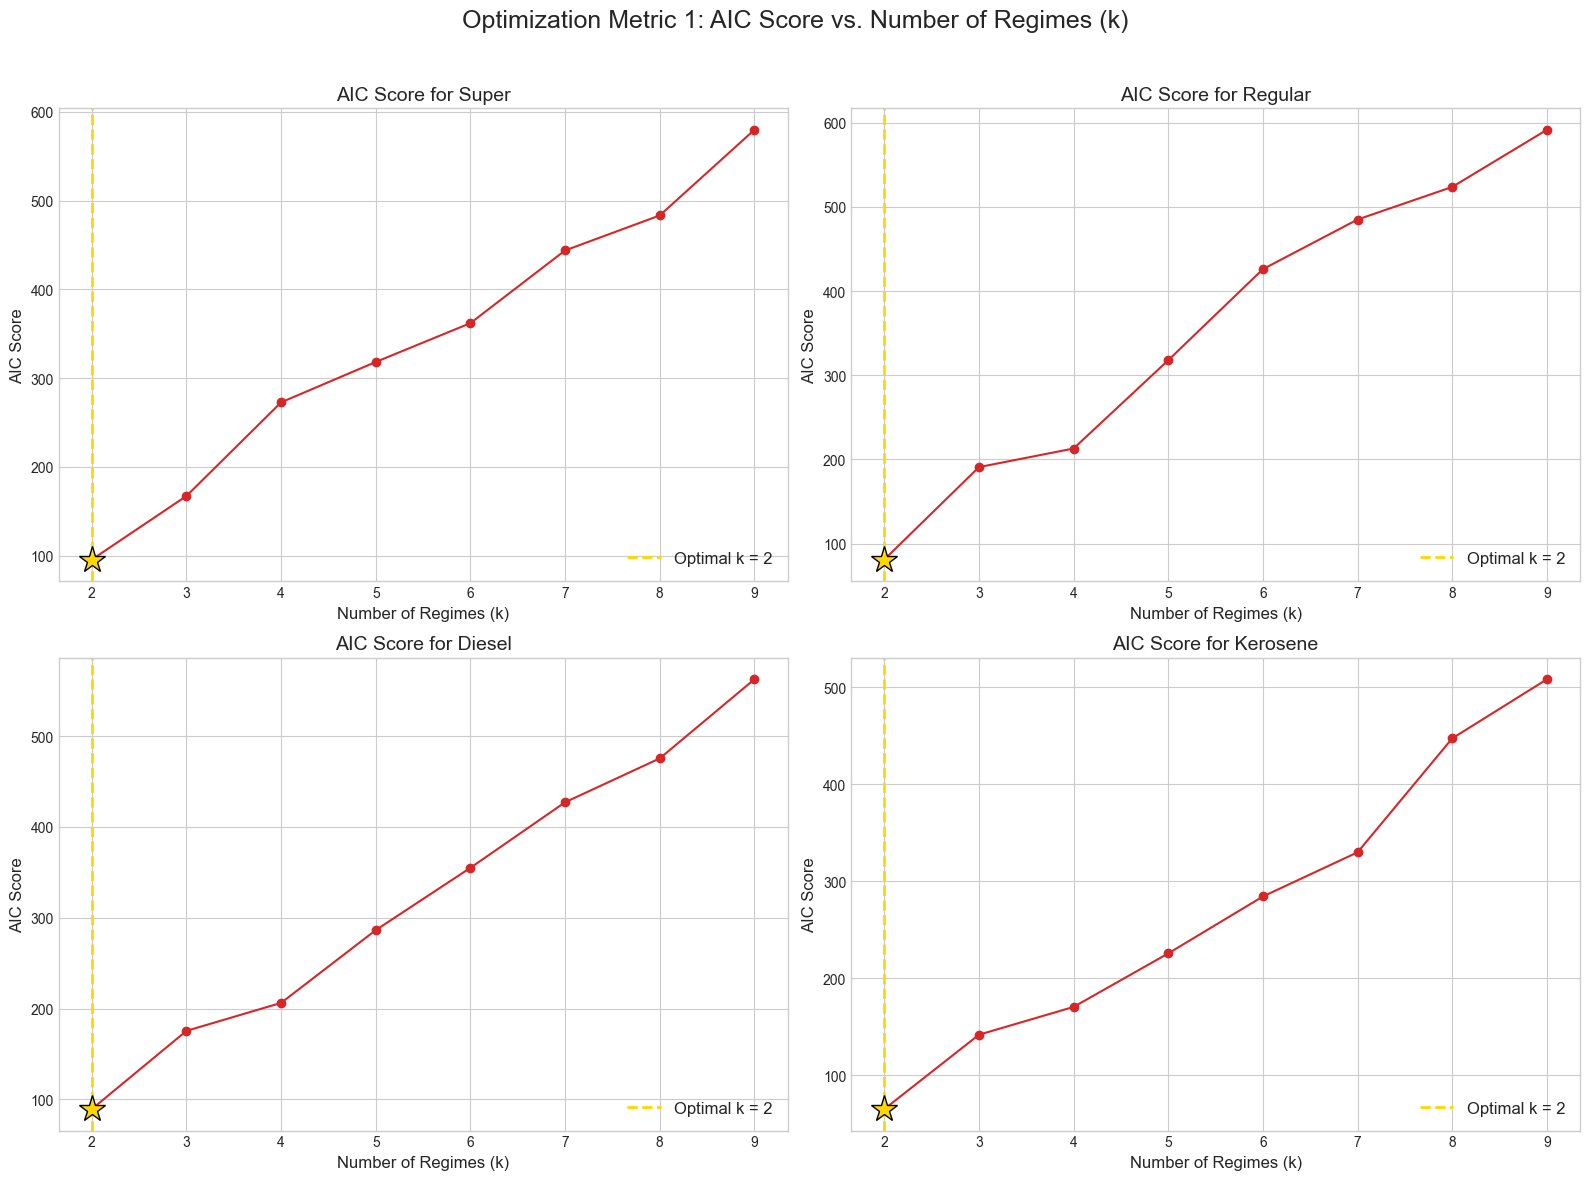

Generating plot: Optimization Metric 2: Average Accuracy vs. Number of Regimes (k)...


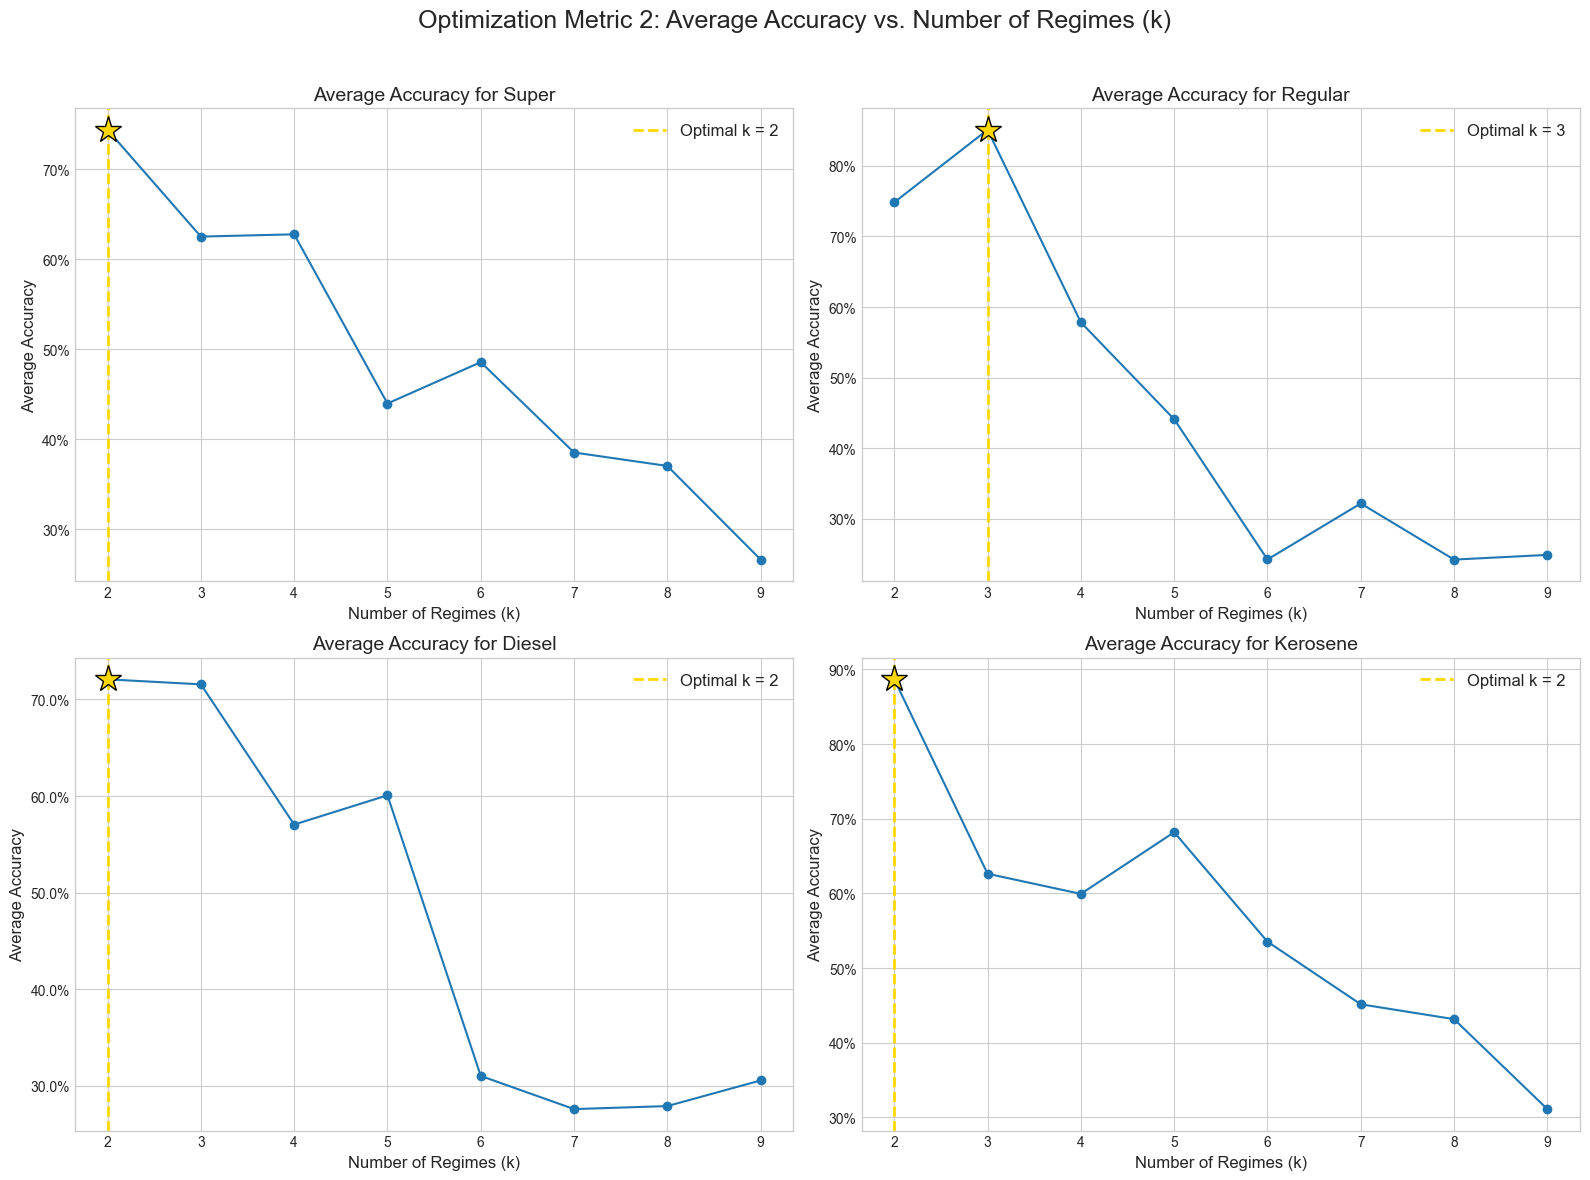

Generating plot: Optimization Metric 3: Average RMSE vs. Number of Regimes (k)...


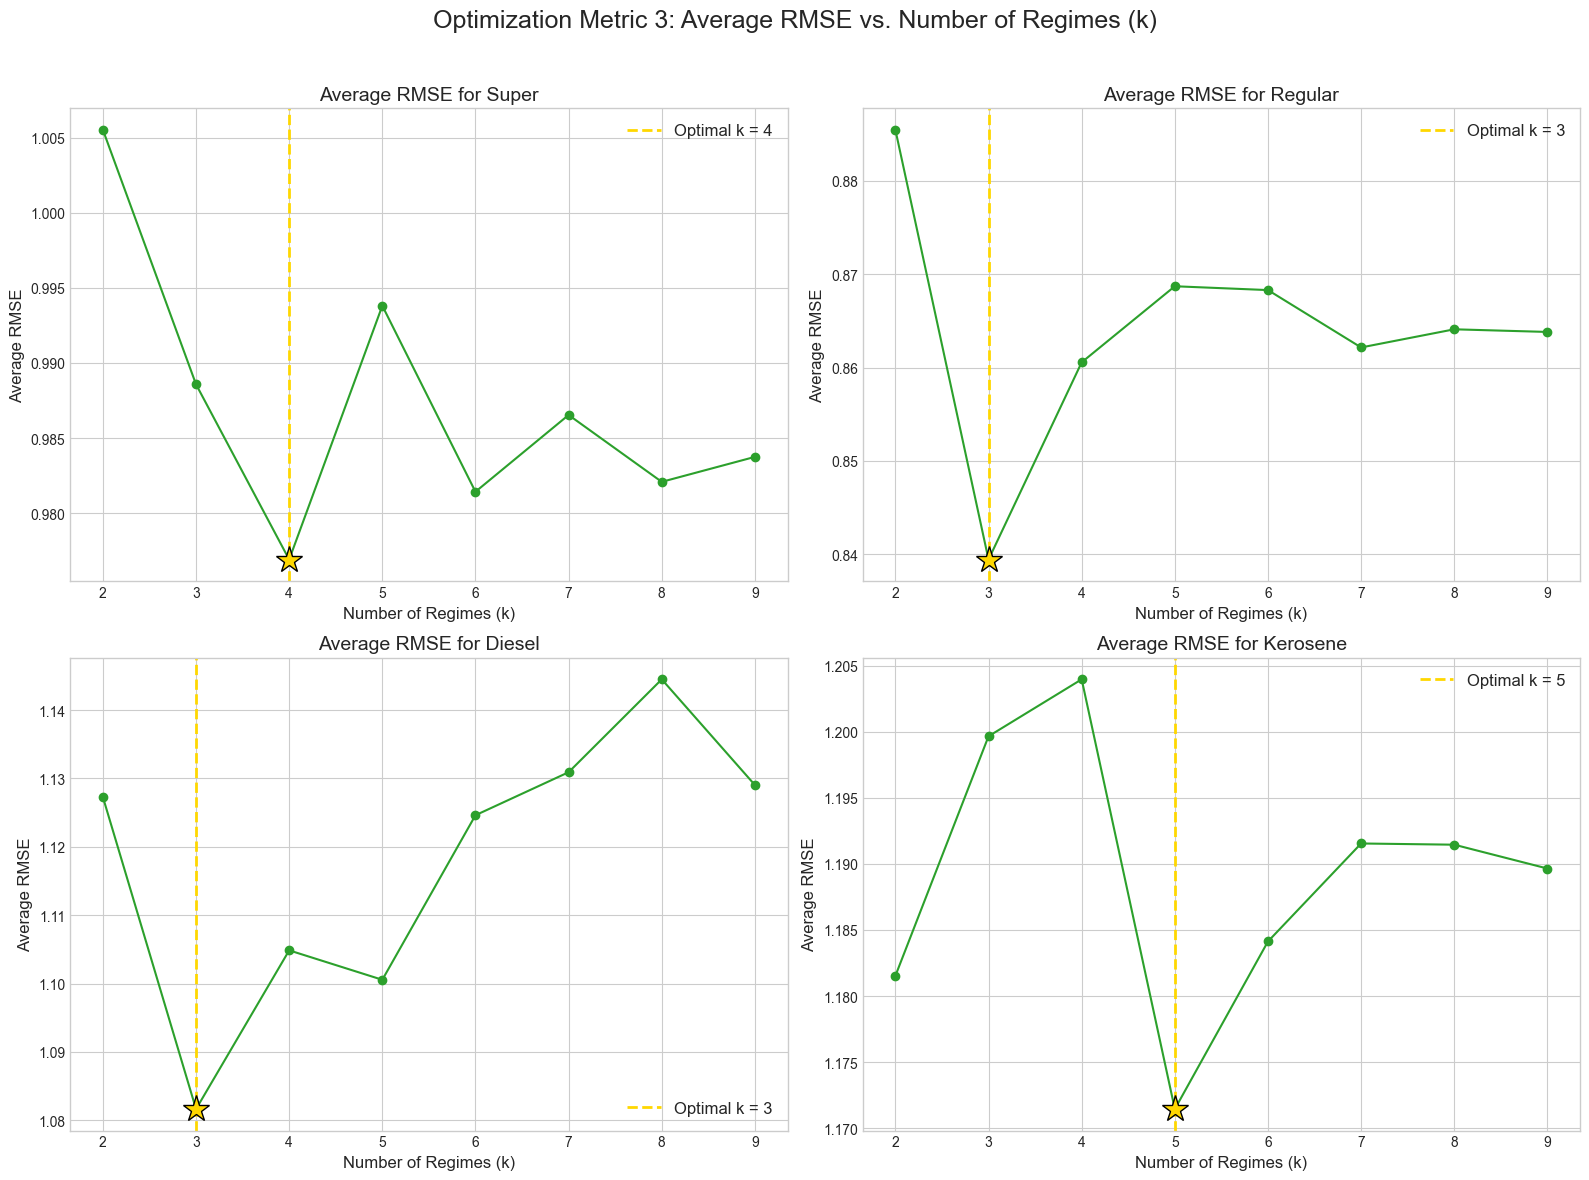

Generating Plot 4: Consolidated Bubble Chart (AIC vs. Accuracy vs. RMSE)...


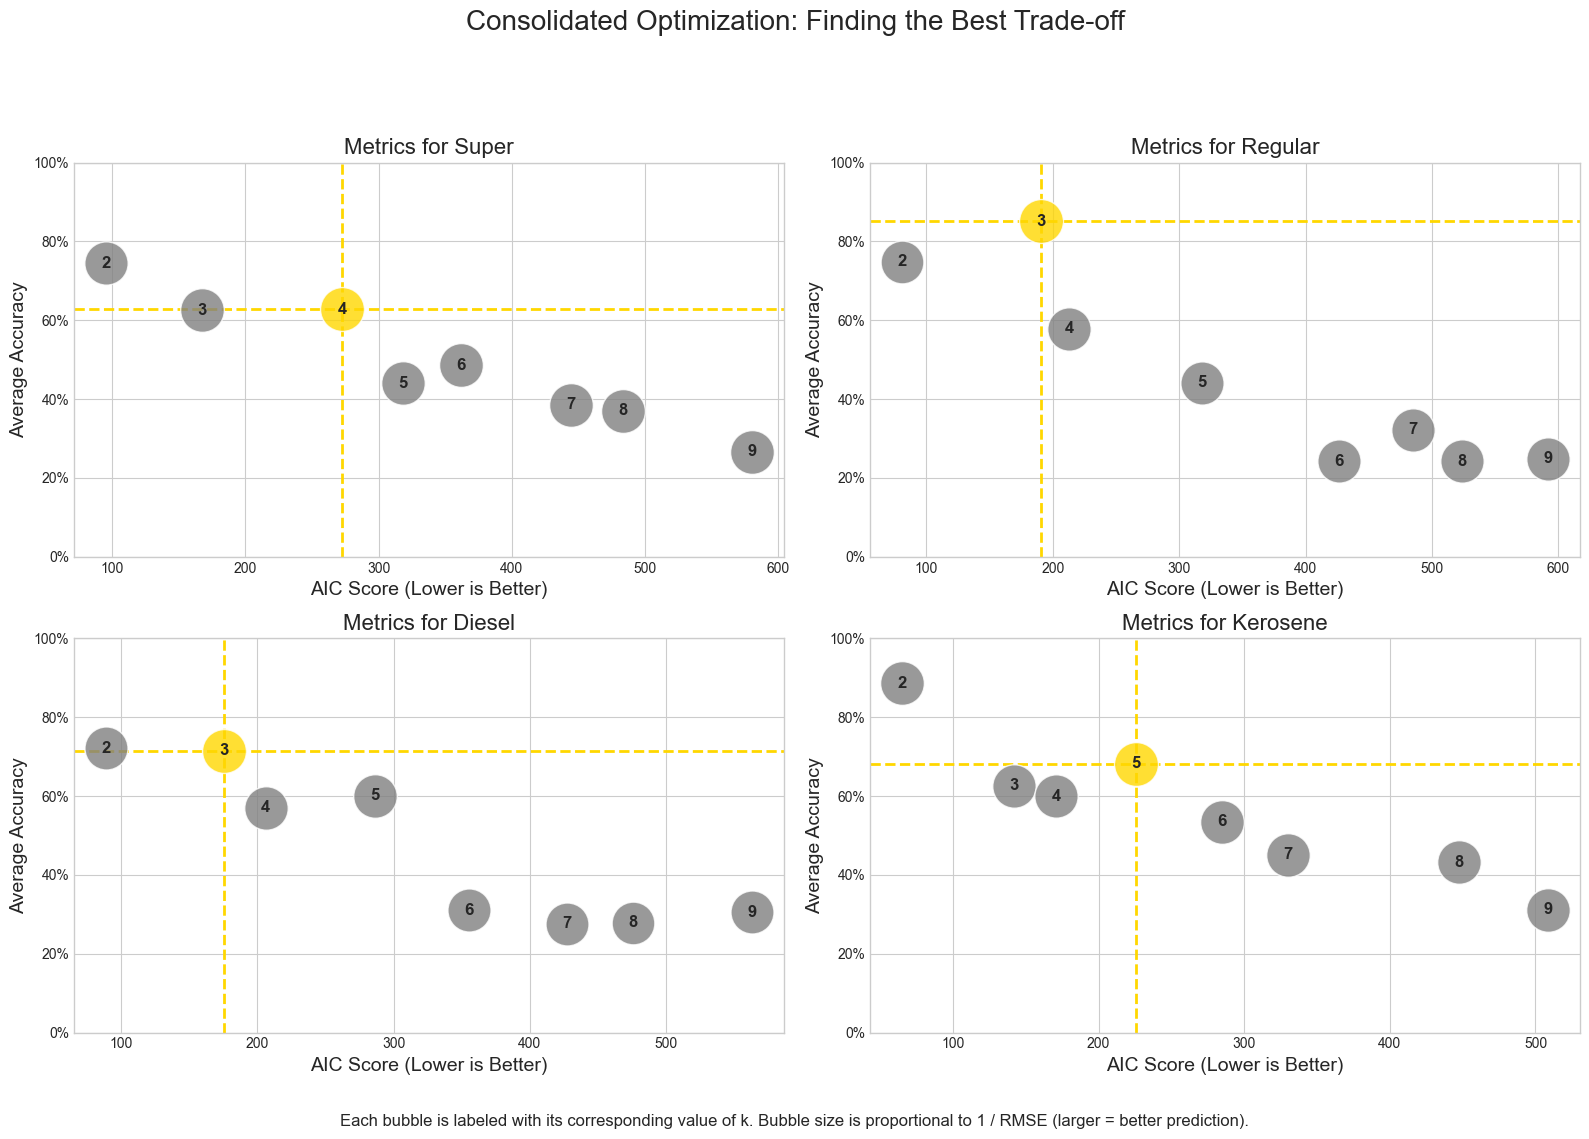

In [15]:
def plot_metric_over_k(optimization_results, metric_key, metric_label, plot_title, color, filename, is_higher_better):
    """
    Generates and saves a 2x2 subplot figure for a given optimization metric.

    This helper function consolidates the plotting logic for AIC, Accuracy, and
    RMSE to avoid code duplication and improve maintainability.

    Args:
        optimization_results (dict): The dictionary containing all optimization data.
        metric_key (str): The key for the metric to plot (e.g., 'aic_scores').
        metric_label (str): The label for the Y-axis (e.g., 'AIC Score').
        plot_title (str): The main title for the figure.
        color (str): The color for the plot's line and markers.
        filename (str): The filename for the saved plot image.
        is_higher_better (bool): True if a higher metric value is better (e.g., accuracy),
                                 False if a lower value is better (e.g., AIC or RMSE).
    """
    print(f"Generating plot: {plot_title}...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    # --- TEXT SIZE INCREASED ---
    fig.suptitle(plot_title, fontsize=18)

    # Iterate through each fuel series' results
    for i, (name, results) in enumerate(optimization_results.items()):
        ax = axes[i]
        k_range = results['k_range']
        scores = results[metric_key]

        # Determine the optimal point based on the metric's nature
        if is_higher_better:
            optimal_idx = np.argmax(scores)
        else:
            optimal_idx = np.argmin(scores)
        
        optimal_k = k_range[optimal_idx]
        optimal_score = scores[optimal_idx]

        # Plot the metric scores vs. k
        ax.plot(k_range, scores, marker='o', linestyle='-', color=color)

        # Highlight the optimal k value with a vertical line and a star marker
        ax.axvline(x=optimal_k, color='gold', linestyle='--', linewidth=2, label=f'Optimal k = {optimal_k}')
        ax.plot(optimal_k, optimal_score, '*', color='gold', markersize=20, markeredgecolor='black', zorder=5)

        # --- TEXT SIZES INCREASED ---
        # Set titles, labels, and formatting
        ax.set_title(f'{metric_label} for {name}', fontsize=14)
        ax.set_xlabel('Number of Regimes (k)', fontsize=12)
        ax.set_ylabel(metric_label, fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True)
        
        # Format Y-axis as a percentage for accuracy plots
        if 'accuracies' in metric_key:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, filename), dpi=600)
    plt.show()

# --- Main Plotting Execution ---
if 'optimization_results' in locals() and optimization_results:
    # --- Plots 1, 2, 3: Generated by the reusable helper function ---
    plot_metric_over_k(optimization_results, 'aic_scores', 'AIC Score',
                       'Optimization Metric 1: AIC Score vs. Number of Regimes (k)',
                       'tab:red', "1_aic_plot.png", is_higher_better=False)

    plot_metric_over_k(optimization_results, 'avg_accuracies', 'Average Accuracy',
                       'Optimization Metric 2: Average Accuracy vs. Number of Regimes (k)',
                       'tab:blue', "2_accuracy_plot.png", is_higher_better=True)

    plot_metric_over_k(optimization_results, 'avg_rmses', 'Average RMSE',
                       'Optimization Metric 3: Average RMSE vs. Number of Regimes (k)',
                       'tab:green', "3_rmse_plot.png", is_higher_better=False)

    # --- Plot 4: Consolidated Bubble Chart (Original logic, with added documentation) ---
    print("Generating Plot 4: Consolidated Bubble Chart (AIC vs. Accuracy vs. RMSE)...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Adjust spacing for the main title and between subplots.
    fig.subplots_adjust(top=0.91, hspace=0.35) # Increased hspace for better label visibility
    # --- TEXT SIZE INCREASED ---
    fig.suptitle('Consolidated Optimization: Finding the Best Trade-off', fontsize=20, y=0.95)
    
    for i, (name, results) in enumerate(optimization_results.items()):
        ax = axes[i]
        k_range = np.array(results['k_range'])
        aic_scores = np.array(results['aic_scores'])
        avg_accuracies = np.array(results['avg_accuracies'])
        avg_rmses = np.array(results['avg_rmses'])
    
        # Invert and scale RMSE so that a larger bubble indicates better (lower) RMSE.
        bubble_sizes = 1 / (avg_rmses + 0.01)
        bubble_sizes = bubble_sizes / bubble_sizes.max() * 1000 # Increased max size for visibility
    
        # Use previously selected optimal k from the main logic block
        optimal_k_series = optimal_ks[name]
        idx_best = np.where(k_range == optimal_k_series)[0][0]
    
        # Plot each k as a bubble.
        for j in range(len(k_range)):
            # The selected optimal k is colored gold, others are gray.
            color = 'gold' if j == idx_best else 'gray'
            ax.scatter(
                aic_scores[j], avg_accuracies[j],
                s=bubble_sizes[j],
                c=color,
                alpha=0.8,
                edgecolors='w',
                linewidth=1,
                zorder=3  # Ensure bubbles are drawn on top of the grid.
            )
            # Add the k number as a label inside each bubble.
            # --- TEXT SIZE INCREASED ---
            ax.text(aic_scores[j], avg_accuracies[j], str(k_range[j]),
                    ha='center', va='center', fontsize=12, fontweight='bold', zorder=4)
    
        # Add guiding lines to highlight the position of the best bubble.
        ax.axvline(x=aic_scores[idx_best], color='gold', linestyle='--', linewidth=2)
        ax.axhline(y=avg_accuracies[idx_best], color='gold', linestyle='--', linewidth=2)
    
        # --- TEXT SIZES INCREASED ---
        # Set titles and labels.
        ax.set_title(f'Metrics for {name}', fontsize=16)
        ax.set_xlabel('AIC Score (Lower is Better)', fontsize=14)
        ax.set_ylabel('Average Accuracy', fontsize=14)
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.grid(True)
    
    # --- TEXT SIZE INCREASED ---
    # Add a final explanatory text for the whole figure.
    fig.text(0.5, 0.02,
             "Each bubble is labeled with its corresponding value of k. Bubble size is proportional to 1 / RMSE (larger = better prediction).",
             ha='center', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.89])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "4_bubble_chart.png"), dpi=600)
    plt.show()

else:
    print("Variable 'optimization_results' not found or is empty. Skipping plot generation.")

## =====================================================================
## STEP 5: FINAL ANALYSIS & VISUALIZATION
## =====================================================================

In this final section, we take the optimal parameters found in the previous steps (especially the optimal 'k' for each series) to build, analyze, and visualize the definitive models.

The analysis is divided into two main parts:
 1. The primary model based on K-Means using the per-series optimal k.
 2. A benchmark model based on Quantiles using a fixed k=4.

Each sub-step calculates the model components (states, transition matrices) and culminates with the visualization of the transition graphs, which represent the market dynamics for each fuel.


--- STEP 5.1: Calculating and visualizing alpha series for the final analysis (using OPTIMAL parameters) ---
  - Calculating alphas for Super using optimal W=52 and Lambda=0.99...
  - Calculating alphas for Regular using optimal W=50 and Lambda=0.99...
  - Calculating alphas for Diesel using optimal W=50 and Lambda=0.97...
  - Calculating alphas for Kerosene using optimal W=52 and Lambda=0.98...


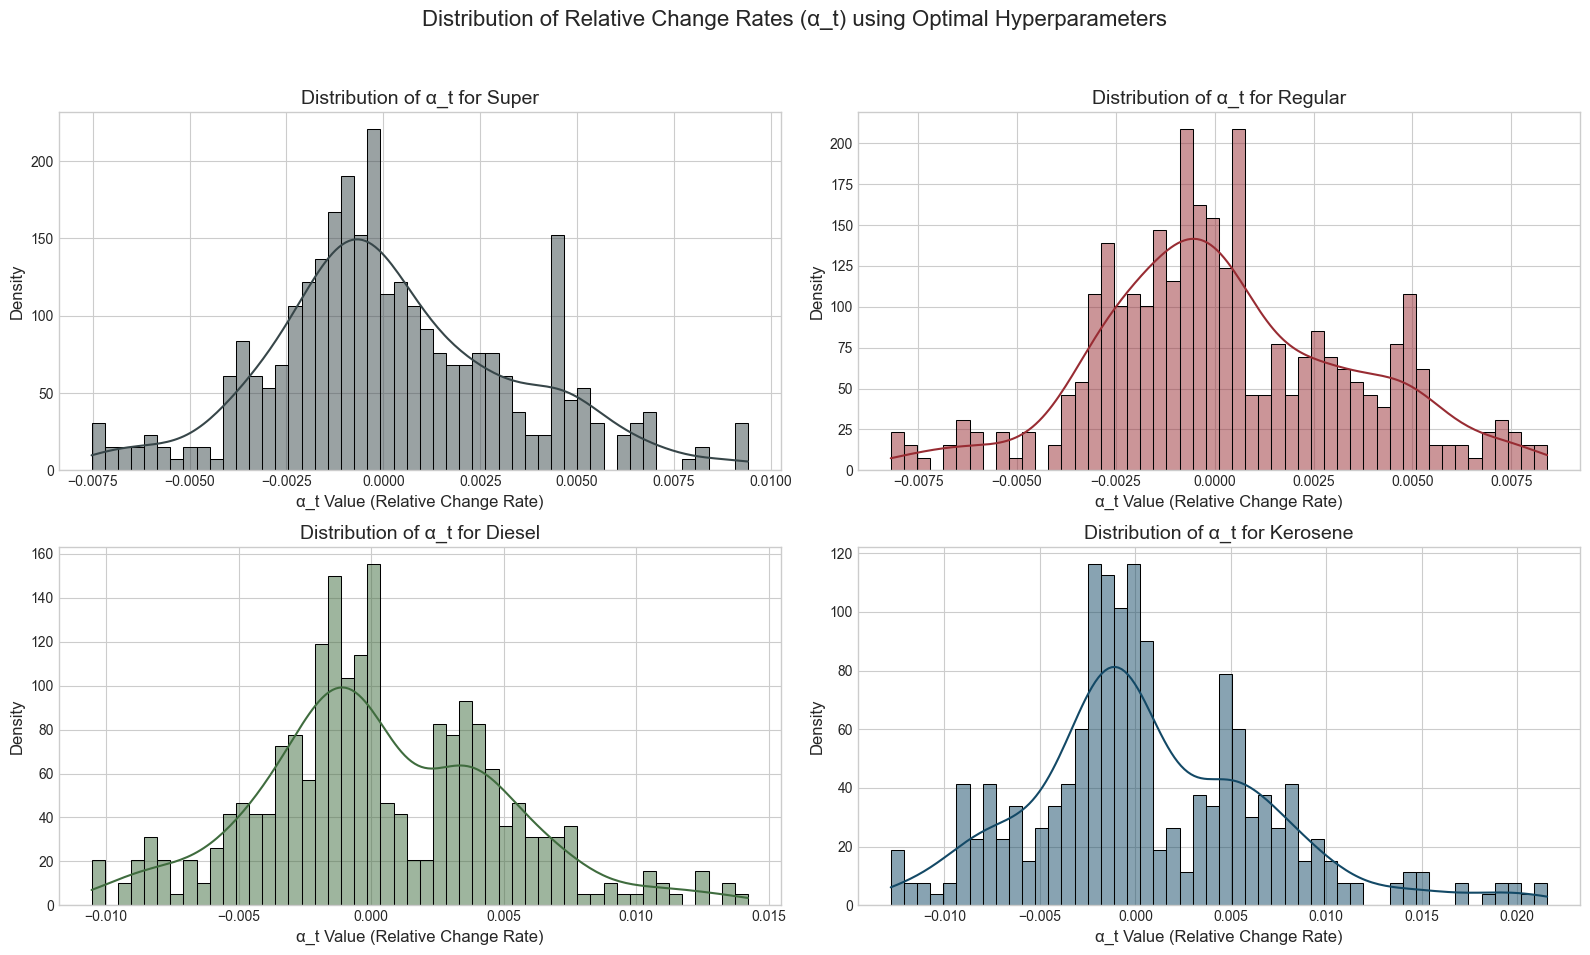


Alpha series based on OPTIMAL parameters successfully calculated and stored.


In [40]:
# =====================================================================
# STEP 5.1: CALCULATE & VISUALIZE ALPHA SERIES FOR FINAL ANALYSIS
# =====================================================================

print("\n--- STEP 5.1: Calculating and visualizing alpha series for the final analysis (using OPTIMAL parameters) ---")

# This dictionary will store the definitive alpha series, which will serve as
# the basis for all subsequent final model constructions.
final_analysis_alphas = {}

# A custom color palette for visual consistency.
fuel_colors = {
    'Super': '#374649',
    'Regular': '#982C33',
    'Diesel': '#3F6C3E',
    'Kerosene': '#134966'
}

# Ensure that the necessary data from previous steps exists.
if 'fuel_series' in locals() and 'df_best_results' in locals():
    best_df = df_best_results # Use the definitive optimal results table
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    fig.suptitle('Distribution of Relative Change Rates (α_t) using Optimal Hyperparameters', fontsize=16, y=0.98)
    
    # Iterate through the fuel series in the correct order
    for i, name in enumerate(list(best_df['Fuel Series'])):
        ax = axes[i]
        
        # --- CRITICAL FIX: RETRIEVE OPTIMAL W AND LAMBDA FOR EACH SERIES ---
        try:
            optimal_params = best_df[best_df['Fuel Series'] == name].iloc[0]
            W_optimal = int(optimal_params['W'])
            Lambda_optimal = float(optimal_params['Lambda'])
            print(f"  - Calculating alphas for {name} using optimal W={W_optimal} and Lambda={Lambda_optimal}...")
        except (IndexError, TypeError):
            print(f"ERROR: Could not find optimal parameters for {name}. Skipping.")
            continue
            
        series = fuel_series.get(name)
        if series is None:
            print(f"ERROR: Time series data for {name} not found. Skipping.")
            continue

        # Calculate the alpha rates using the CORRECT, per-series optimal parameters.
        alphas = calculate_alphas_corrected(series, W_optimal, Lambda_optimal)
        
        # Store the correctly calculated alphas for all subsequent steps.
        final_analysis_alphas[name] = alphas
        
        # Plot the distribution of the correctly calculated alphas.
        sns.histplot(alphas, kde=True, ax=ax, color=fuel_colors.get(name, '#808080'), bins=50, stat="density")
        
        ax.set_title(f'Distribution of α_t for {name}', fontsize=14)
        ax.set_xlabel('α_t Value (Relative Change Rate)', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save with a new name to reflect that these are the optimal results
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "25_alpha_distributions_optimal.png"), dpi=600)
    plt.show()
    print("\nAlpha series based on OPTIMAL parameters successfully calculated and stored.")

else:
    print("Execution halted: Required data ('fuel_series', 'df_best_results') not found.")

In [41]:
# =====================================================================
# STEP 5.2: FINAL ANALYSIS - K-MEANS METHOD (USING OPTIMAL K)
# =====================================================================
# This step builds the definitive K-Means based Markov models. For each fuel
# series, it uses the specific optimal 'k' found in Step 4. It then calculates
# and stores the final model components: states, centroids, count matrix (C),
# and the robustly estimated transition matrix (Ap) using the SRep method.

print(f"\n--- STEP 5.2: Running Final K-Means Analysis using optimal k per series ---")

# This dictionary will store the final, detailed results for each optimal model.
kmeans_final_results = {}

# Check if the required alpha series from the previous step exist.
if 'final_analysis_alphas' in locals() and final_analysis_alphas:
    # Iterate through each fuel series and its calculated alpha values.
    for name, alphas in final_analysis_alphas.items():
        # Use the optimal k specific to this series, with the global OPTIMAL_K as a fallback.
        k = optimal_ks.get(name, OPTIMAL_K)
        
        # --- Print a clear header for each series' results ---
        print(f"\n" + "="*60)
        print(f"FINAL K-MEANS RESULTS FOR: {name.upper()} (using k={k})")
        print("="*60)
        
        # 1. Discretize the alpha series into states using the optimal k.
        # The centroids represent the average relative change (α_t) for each state/regime.
        states, centroids = discretize_by_kmeans(alphas, k=k)
        
        # 2. Calculate the final transition count matrix (C).
        # C[j, i] = number of times a transition from state i to state j was observed.
        C = calculate_count_matrix(states, num_states=k)
        
        # 3. (For comparison) Calculate the Maximum Likelihood Estimator (MLE) of P.
        # This is a simple, count-based probability matrix.
        col_sums_C = C.sum(axis=0)
        col_sums_C[col_sums_C == 0] = 1 # Avoid division by zero
        P_mle = C / col_sums_C
        
        # 4. Estimate the final, robust transition matrix (Ap) with the SRep method.
        complete_onehot_matrix = states_to_onehot_matrix(states, num_states=k)
        num_transitions = complete_onehot_matrix.shape[1] - 1
        
        # Ensure there are transitions to model, otherwise create a uniform matrix.
        if num_transitions > 0:
            Ap_srep = SRep(complete_onehot_matrix, num_samples=num_transitions)
        else:
            Ap_srep = np.full((k, k), 1/k) # Fallback to uniform probabilities
        
        # 5. Store all final results in a dictionary for this series.
        kmeans_final_results[name] = {
            'P_mle': P_mle, 
            'Ap_srep': Ap_srep, 
            'C': C,
            'centroids': centroids, 
            'states': states
        }
        
        # --- Display the key final results in a formatted way ---
        print("\nRegime Centroids (average α_t rates):")
        for i, c in enumerate(centroids):
            print(f"  Regime s{i+1}: {c:.4f}")
        
        # Use pandas DataFrame for a clean, labeled matrix display.
        df_C = pd.DataFrame(C, 
                            index=[f'To s{i+1}' for i in range(k)], 
                            columns=[f'From s{i+1}' for i in range(k)])
        print("\nFinal Count Matrix (C):")
        print(df_C)
        
        df_Ap = pd.DataFrame(Ap_srep, 
                             index=[f'To s{i+1}' for i in range(k)], 
                             columns=[f'From s{i+1}' for i in range(k)])
        print("\nFinal Transition Matrix Ap (Estimated with SRep):")
        print(df_Ap.round(3))

else:
    print("Execution halted: Alpha series not found. Please run Step 5.1 first.")


--- STEP 5.2: Running Final K-Means Analysis using optimal k per series ---

FINAL K-MEANS RESULTS FOR: SUPER (using k=4)

Regime Centroids (average α_t rates):
  Regime s1: -0.0043
  Regime s2: -0.0009
  Regime s3: 0.0019
  Regime s4: 0.0055

Final Count Matrix (C):
       From s1  From s2  From s3  From s4
To s1       55        6        0        0
To s2        6      159        7        0
To s3        0        7       82        3
To s4        0        0        3       59

Final Transition Matrix Ap (Estimated with SRep):
       From s1  From s2  From s3  From s4
To s1    0.902    0.035    0.000    0.000
To s2    0.098    0.924    0.076    0.000
To s3    0.000    0.041    0.891    0.048
To s4    0.000    0.000    0.033    0.952

FINAL K-MEANS RESULTS FOR: REGULAR (using k=3)

Regime Centroids (average α_t rates):
  Regime s1: -0.0036
  Regime s2: -0.0001
  Regime s3: 0.0044

Final Count Matrix (C):
       From s1  From s2  From s3
To s1       88        8        0
To s2        8      


--- STEP 5.3: Generating and composing final transition graphs ---
  - Generating graph for Super with k=4...
  - Generating graph for Regular with k=3...
  - Generating graph for Diesel with k=3...
  - Generating graph for Kerosene with k=5...

Composing 2x2 panel from generated graphs...


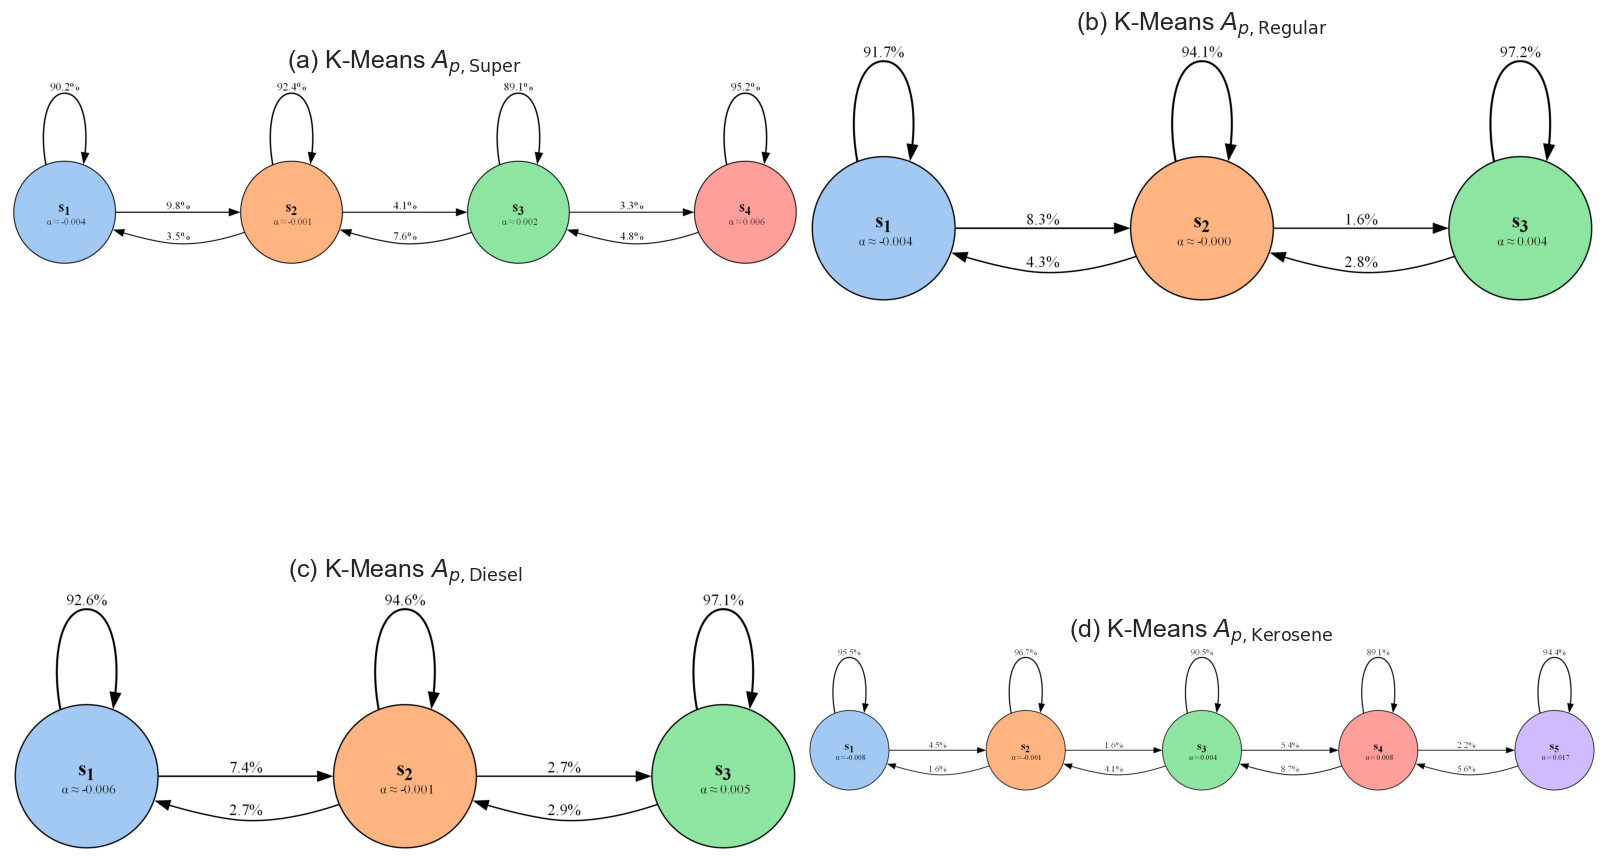


 Panel image successfully saved to: optimized_outputs\6_final_transition_panel.png


In [42]:
# =====================================================================
# STEP 5.3: VISUALIZE FINAL TRANSITION MATRICES 
# =====================================================================

def plot_transition_graph(Ap, series_name, k, centroids=None, output_dir='optimized_outputs'):
    """
    Generates and saves a transition graph from a given transition matrix (Ap).

    This version includes a specific rule to make self-loop edges thinner
    for better visual clarity.

    Args:
        Ap (np.ndarray): The k x k transition probability matrix.
        series_name (str): The name of the time series (e.g., 'Super').
        k (int): The number of states in the model.
        centroids (np.ndarray, optional): The centroids for each state to display in nodes.
        output_dir (str): The directory to save the output PNG file.
    """
    dot = Digraph(comment=f'Transition Graph for {series_name}')
    
    # --- Global layout control ---
    dot.attr(rankdir='LR', size='8,8', dpi='300', nodesep='1.0', ranksep='1.5')

    # --- Node and Edge Styling ---
    node_colors = sns.color_palette("pastel", n_colors=k).as_hex()
    
    # Define nodes
    for i in range(k):
        alpha_val = f"<br/> <font point-size='10'>α ≈ {centroids[i]:.3f}</font>" if centroids is not None else ""
        label = f'<<font point-size="16"><b>s<sub>{i+1}</sub></b></font>{alpha_val}>'
        dot.node(f's{i}', label=label, shape='circle', style='filled',
                 fillcolor=node_colors[i], fixedsize='true', width='1.5')

    # Define edges based on transition probabilities
    for i in range(k):  # From state i
        for j in range(k):  # To state j
            prob = Ap[j, i]
            if prob >= 0.01:
                # --- ADJUSTMENT FOR PEN WIDTH (Your Request) ---
                # Use a different, less sensitive formula for self-loops (i == j)
                if i == j:
                    # Make self-loops significantly thinner
                    penwidth_val = 0.6 + prob 
                else:
                    # Keep other transitions more prominent
                    penwidth_val = 1.0 + prob * 2.5
                
                dot.edge(f's{i}', f's{j}', label=f'{prob:.1%}',
                         fontsize='12', penwidth=str(penwidth_val))

    # --- Export ---
    filename = os.path.join(output_dir, f"graph_kmeans_{series_name.lower()}")
    try:
        dot.render(filename, format='png', cleanup=True)
    except Exception as e:
        print(f"  ERROR: Could not render graph for {series_name}. Please ensure Graphviz is installed and in your system's PATH.")
        print(f"  Graphviz error: {e}")


def generate_and_compose_graphs(final_results, output_folder):
    """
    Generates individual transition graphs and composes them into a 2x2 panel.
    
    This function is now corrected to pass the required 'k' value to the
    plotting function.
    """
    print("\n--- STEP 5.3: Generating and composing final transition graphs ---")
    
    # 1. Dynamically Generate Individual Graphs and Paths
    paths = {}
    titles = {}
    
    for i, (name, results) in enumerate(final_results.items()):
        Ap = results['Ap_srep']
        centroids = results['centroids']
        # FIX: Get 'k' from the shape of the transition matrix.
        k = Ap.shape[0] 
        
        print(f"  - Generating graph for {name} with k={k}...")
        # FIX: Pass 'k' as an argument to the plotting function.
        plot_transition_graph(Ap, name, k, centroids, output_folder)
        
        paths[name] = os.path.join(output_folder, f"graph_kmeans_{name.lower()}.png")
        subplot_letter = chr(97 + i)
        # Using LaTeX for beautiful math formatting in the title
        titles[name] = f'({subplot_letter}) K-Means $A_{{p,\\mathrm{{{name}}}}}$'

    # 2. Compose the 2x2 Panel
    print("\nComposing 2x2 panel from generated graphs...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 14)) # Increased height slightly for titles
    axes = axes.flatten()

    for i, (name, path) in enumerate(paths.items()):
        if os.path.exists(path):
            with Image.open(path) as img:
                axes[i].imshow(img)
                axes[i].set_title(titles[name], fontsize=18, y=1.0)
                axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Image not found:\n{os.path.basename(path)}", ha='center', va='center')
            axes[i].axis('off')

    # 3. Final Layout and Export
    plt.tight_layout(pad=0.5)
    panel_output_path = os.path.join(output_folder, "6_final_transition_panel.png")
    fig.savefig(panel_output_path, dpi=600, bbox_inches='tight')
    plt.show()

    print(f"\n Panel image successfully saved to: {panel_output_path}")


# --- Main Execution ---
if 'kmeans_final_results' in locals() and kmeans_final_results:
    generate_and_compose_graphs(kmeans_final_results, OUTPUT_FOLDER_OPTIMIZED)
else:
    print("Execution halted: `kmeans_final_results` not found. Please run previous steps.")

In [43]:
# =====================================================================
# STEP 5.4: FINAL ANALYSIS - QUANTILES METHOD (FIXED BENCHMARK AT K=4)
# =====================================================================
# This step builds a benchmark model using a simpler discretization method.
# Instead of an optimized k, it uses a fixed number of states (k=4) based
# on quantiles. This provides a standard baseline against which the performance
# of the more complex K-Means model can be compared.

print(f"\n--- STEP 5.4: Running Final Quantiles Analysis using fixed k=4 as a benchmark ---")

# This dictionary will store the final results for the quantile benchmark.
quantiles_final_results = {}
FIXED_K_QUANTILES = 4

# Check if the required alpha series from the previous step exist.
if 'final_analysis_alphas' in locals() and final_analysis_alphas:
    for name, alphas in final_analysis_alphas.items():
        # --- Print a clear header for each series' results ---
        print(f"\n" + "="*60)
        print(f"FINAL QUANTILES RESULTS FOR: {name.upper()} (using fixed k={FIXED_K_QUANTILES})")
        print("="*60)

        # 1. Discretize the alpha series using the Quantiles method.
        # This divides the data into 4 regimes with an equal number of observations.
        states, boundaries = discretize_by_quantiles(alphas, num_regimes=FIXED_K_QUANTILES)
        
        # 2. Calculate the final transition matrices (C, P_mle, Ap_srep).
        # The logic is identical to the K-Means step but applied to the quantile-based states.
        C = calculate_count_matrix(states, num_states=FIXED_K_QUANTILES)
        col_sums_C = C.sum(axis=0)
        col_sums_C[col_sums_C == 0] = 1
        P_mle = C / col_sums_C
        
        complete_onehot_matrix = states_to_onehot_matrix(states, num_states=FIXED_K_QUANTILES)
        num_transitions = complete_onehot_matrix.shape[1] - 1
        
        if num_transitions > 0:
            Ap_srep = SRep(complete_onehot_matrix, num_samples=num_transitions)
        else:
            Ap_srep = np.full((FIXED_K_QUANTILES, FIXED_K_QUANTILES), 1/FIXED_K_QUANTILES)
        
        # 3. Store all final results for the benchmark model.
        # Note that 'boundaries' are stored instead of 'centroids'.
        quantiles_final_results[name] = {
            'P_mle': P_mle, 
            'Ap_srep': Ap_srep, 
            'C': C,
            'boundaries': boundaries, 
            'states': states, 
            'alphas': alphas
        }

        # --- Display the key results for the benchmark model ---
        print("\nRegime Boundaries (Quantile Values):")
        # Display the calculated quantile values that separate the regimes.
        print(np.round(boundaries, 4))

        # Use pandas DataFrame for a clean, labeled matrix display.
        df_C = pd.DataFrame(C, 
                            index=[f'To s{i+1}' for i in range(FIXED_K_QUANTILES)], 
                            columns=[f'From s{i+1}' for i in range(FIXED_K_QUANTILES)])
        print("\nFinal Count Matrix (C):")
        print(df_C)
        
        df_Ap = pd.DataFrame(Ap_srep, 
                             index=[f'To s{i+1}' for i in range(FIXED_K_QUANTILES)], 
                             columns=[f'From s{i+1}' for i in range(FIXED_K_QUANTILES)])
        print("\nFinal Transition Matrix Ap (Estimated with SRep):")
        print(df_Ap.round(3))
else:
    print("Execution halted: Alpha series not found. Please run Step 5.1 first.")


--- STEP 5.4: Running Final Quantiles Analysis using fixed k=4 as a benchmark ---

FINAL QUANTILES RESULTS FOR: SUPER (using fixed k=4)

Regime Boundaries (Quantile Values):
[-0.0017 -0.0002  0.0021]

Final Count Matrix (C):
       From s1  From s2  From s3  From s4
To s1       89        8        0        0
To s2        8       78       10        0
To s3        0        9       85        3
To s4        0        1        2       94

Final Transition Matrix Ap (Estimated with SRep):
       From s1  From s2  From s3  From s4
To s1    0.918    0.083    0.000    0.000
To s2    0.082    0.812    0.103    0.000
To s3    0.000    0.094    0.876    0.031
To s4    0.000    0.010    0.021    0.969

FINAL QUANTILES RESULTS FOR: REGULAR (using fixed k=4)

Regime Boundaries (Quantile Values):
[-0.0018 -0.0001  0.0025]

Final Count Matrix (C):
       From s1  From s2  From s3  From s4
To s1       90        8        0        0
To s2        8       80        8        0
To s3        0        9       86


--- STEP 5.5: Generating and composing final transition graphs (Quantiles Benchmark) ---
  - Generating quantile graph for Super...
  - Generating quantile graph for Regular...
  - Generating quantile graph for Diesel...
  - Generating quantile graph for Kerosene...

Composing 2x2 panel from quantile graphs...


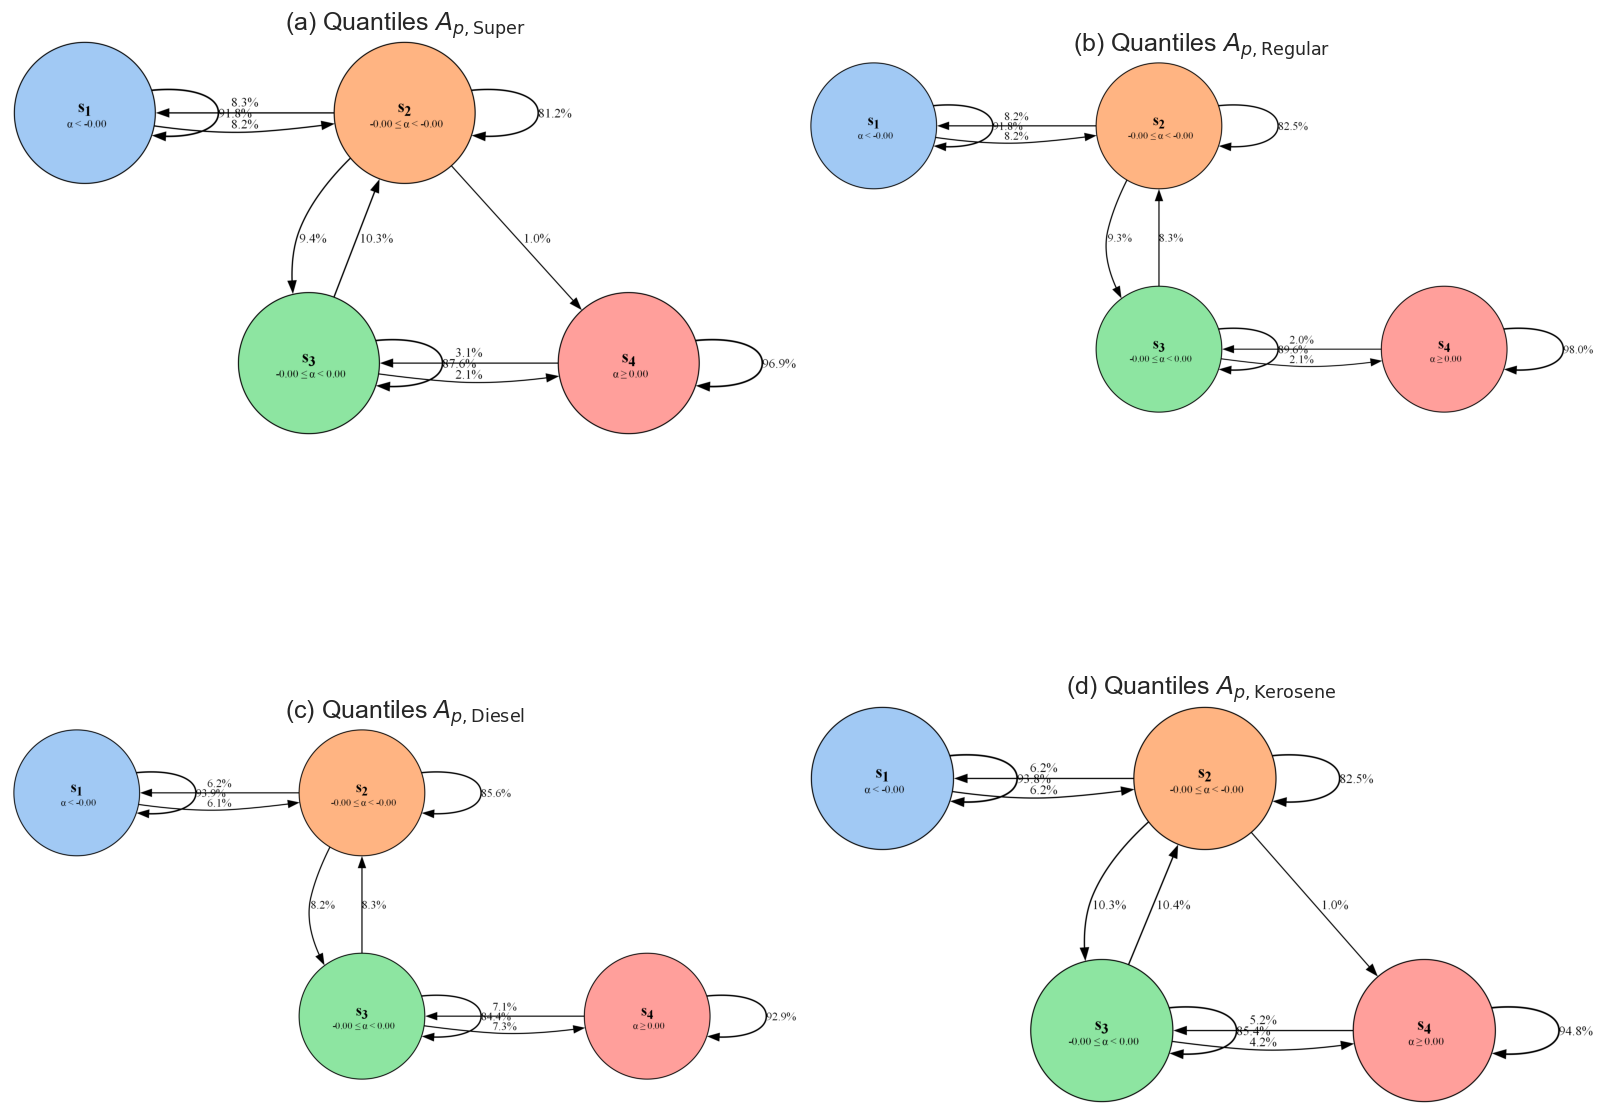


✅ Quantiles panel image successfully saved to: optimized_outputs\7_final_quantiles_panel.png


In [44]:
# =====================================================================
# STEP 5.5: VISUALIZE FINAL TRANSITION MATRICES (QUANTILE BENCHMARK)
# =====================================================================
# This step visualizes the results from the Quantile benchmark model.
# A custom plotting function is used to arrange the 4 states in a 2x2
# matrix layout for intuitive analysis of the state transitions.

def plot_quantile_transition_graph(Ap, series_name, boundaries, output_dir):
    """
    Generates a transition graph specifically for the 4-state quantile model,
    arranging the nodes in a 2x2 matrix layout.

    Args:
        Ap (np.ndarray): The 4x4 transition probability matrix.
        series_name (str): The name of the time series (e.g., 'Super').
        boundaries (np.ndarray): The quantile boundaries that define the states.
        output_dir (str): The directory to save the output PNG file.
    """
    k = 4  # This function is hardcoded for the k=4 benchmark
    dot = Digraph(comment=f'Quantile Transition Graph for {series_name}')
    
    # --- Global layout control ---
    dot.attr(dpi='300', nodesep='0.8', ranksep='1.2')

    # --- Node Styling and 2x2 Layout using Subgraphs ---
    node_colors = sns.color_palette("pastel", n_colors=k).as_hex()
    
    # Create the top row (s1, s2)
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('s0', label=f'<<font point-size="16"><b>s<sub>1</sub></b></font><br/> <font point-size="10">α &lt; {boundaries[0]:.2f}</font>>', 
               shape='circle', style='filled', fillcolor=node_colors[0], fixedsize='true', width='1.8')
        s.node('s1', label=f'<<font point-size="16"><b>s<sub>2</sub></b></font><br/> <font point-size="10">{boundaries[0]:.2f} ≤ α &lt; {boundaries[1]:.2f}</font>>', 
               shape='circle', style='filled', fillcolor=node_colors[1], fixedsize='true', width='1.8')

    # Create the bottom row (s3, s4)
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('s2', label=f'<<font point-size="16"><b>s<sub>3</sub></b></font><br/> <font point-size="10">{boundaries[1]:.2f} ≤ α &lt; {boundaries[2]:.2f}</font>>', 
               shape='circle', style='filled', fillcolor=node_colors[2], fixedsize='true', width='1.8')
        s.node('s3', label=f'<<font point-size="16"><b>s<sub>4</sub></b></font><br/> <font point-size="10">α ≥ {boundaries[2]:.2f}</font>>', 
               shape='circle', style='filled', fillcolor=node_colors[3], fixedsize='true', width='1.8')

    # --- Define Edges ---
    for i in range(k):  # From state i
        for j in range(k):  # To state j
            prob = Ap[j, i]
            if prob >= 0.01:
                penwidth_val = 0.6 + prob if i == j else 1.0 + prob * 2.5
                dot.edge(f's{i}', f's{j}', label=f'{prob:.1%}',
                         fontsize='12', penwidth=str(penwidth_val))

    # --- Export ---
    filename = os.path.join(output_dir, f"graph_quantiles_{series_name.lower()}")
    try:
        dot.render(filename, format='png', cleanup=True)
    except Exception as e:
        print(f"  ERROR: Could not render graph for {series_name}. Please ensure Graphviz is installed and in your system's PATH.")
        print(f"  Graphviz error: {e}")


def generate_quantile_panel(final_results, output_folder):
    """
    Orchestrates the generation and composition of the quantile model graphs.
    """
    print("\n--- STEP 5.5: Generating and composing final transition graphs (Quantiles Benchmark) ---")
    
    paths = {}
    titles = {}
    
    for i, (name, results) in enumerate(final_results.items()):
        print(f"  - Generating quantile graph for {name}...")
        plot_quantile_transition_graph(
            Ap=results['Ap_srep'],
            series_name=name,
            boundaries=results['boundaries'],
            output_dir=output_folder
        )
        
        paths[name] = os.path.join(output_folder, f"graph_quantiles_{name.lower()}.png")
        subplot_letter = chr(97 + i)
        titles[name] = f'({subplot_letter}) Quantiles $A_{{p,\\mathrm{{{name}}}}}$'

    # Compose the 2x2 Panel
    print("\nComposing 2x2 panel from quantile graphs...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()

    for i, (name, path) in enumerate(paths.items()):
        if os.path.exists(path):
            with Image.open(path) as img:
                axes[i].imshow(img)
                axes[i].set_title(titles[name], fontsize=18, y=1.0)
                axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Image not found:\n{os.path.basename(path)}", ha='center', va='center')
            axes[i].axis('off')

    plt.tight_layout(pad=0.5)
    panel_output_path = os.path.join(output_folder, "7_final_quantiles_panel.png")
    fig.savefig(panel_output_path, dpi=600, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Quantiles panel image successfully saved to: {panel_output_path}")

# --- Main Execution for this step ---
if 'quantiles_final_results' in locals() and quantiles_final_results:
    generate_quantile_panel(quantiles_final_results, OUTPUT_FOLDER_OPTIMIZED)
else:
    print("Execution halted: `quantiles_final_results` not found. Please run Step 5.4 first.")

## =====================================================================
## STEP 6: VISUALIZATION OF FINAL K-MEANS REGIMES (USING OPTIMAL K)
## =====================================================================

This final visualization step plots the time series of alpha values, with each point colored according to the regime assigned by the final K-Means model. This allows for a clear visual inspection of how different market dynamics (regimes) are distributed over time.


--- STEP 6: Visualizing the final regimes found by K-Means ---


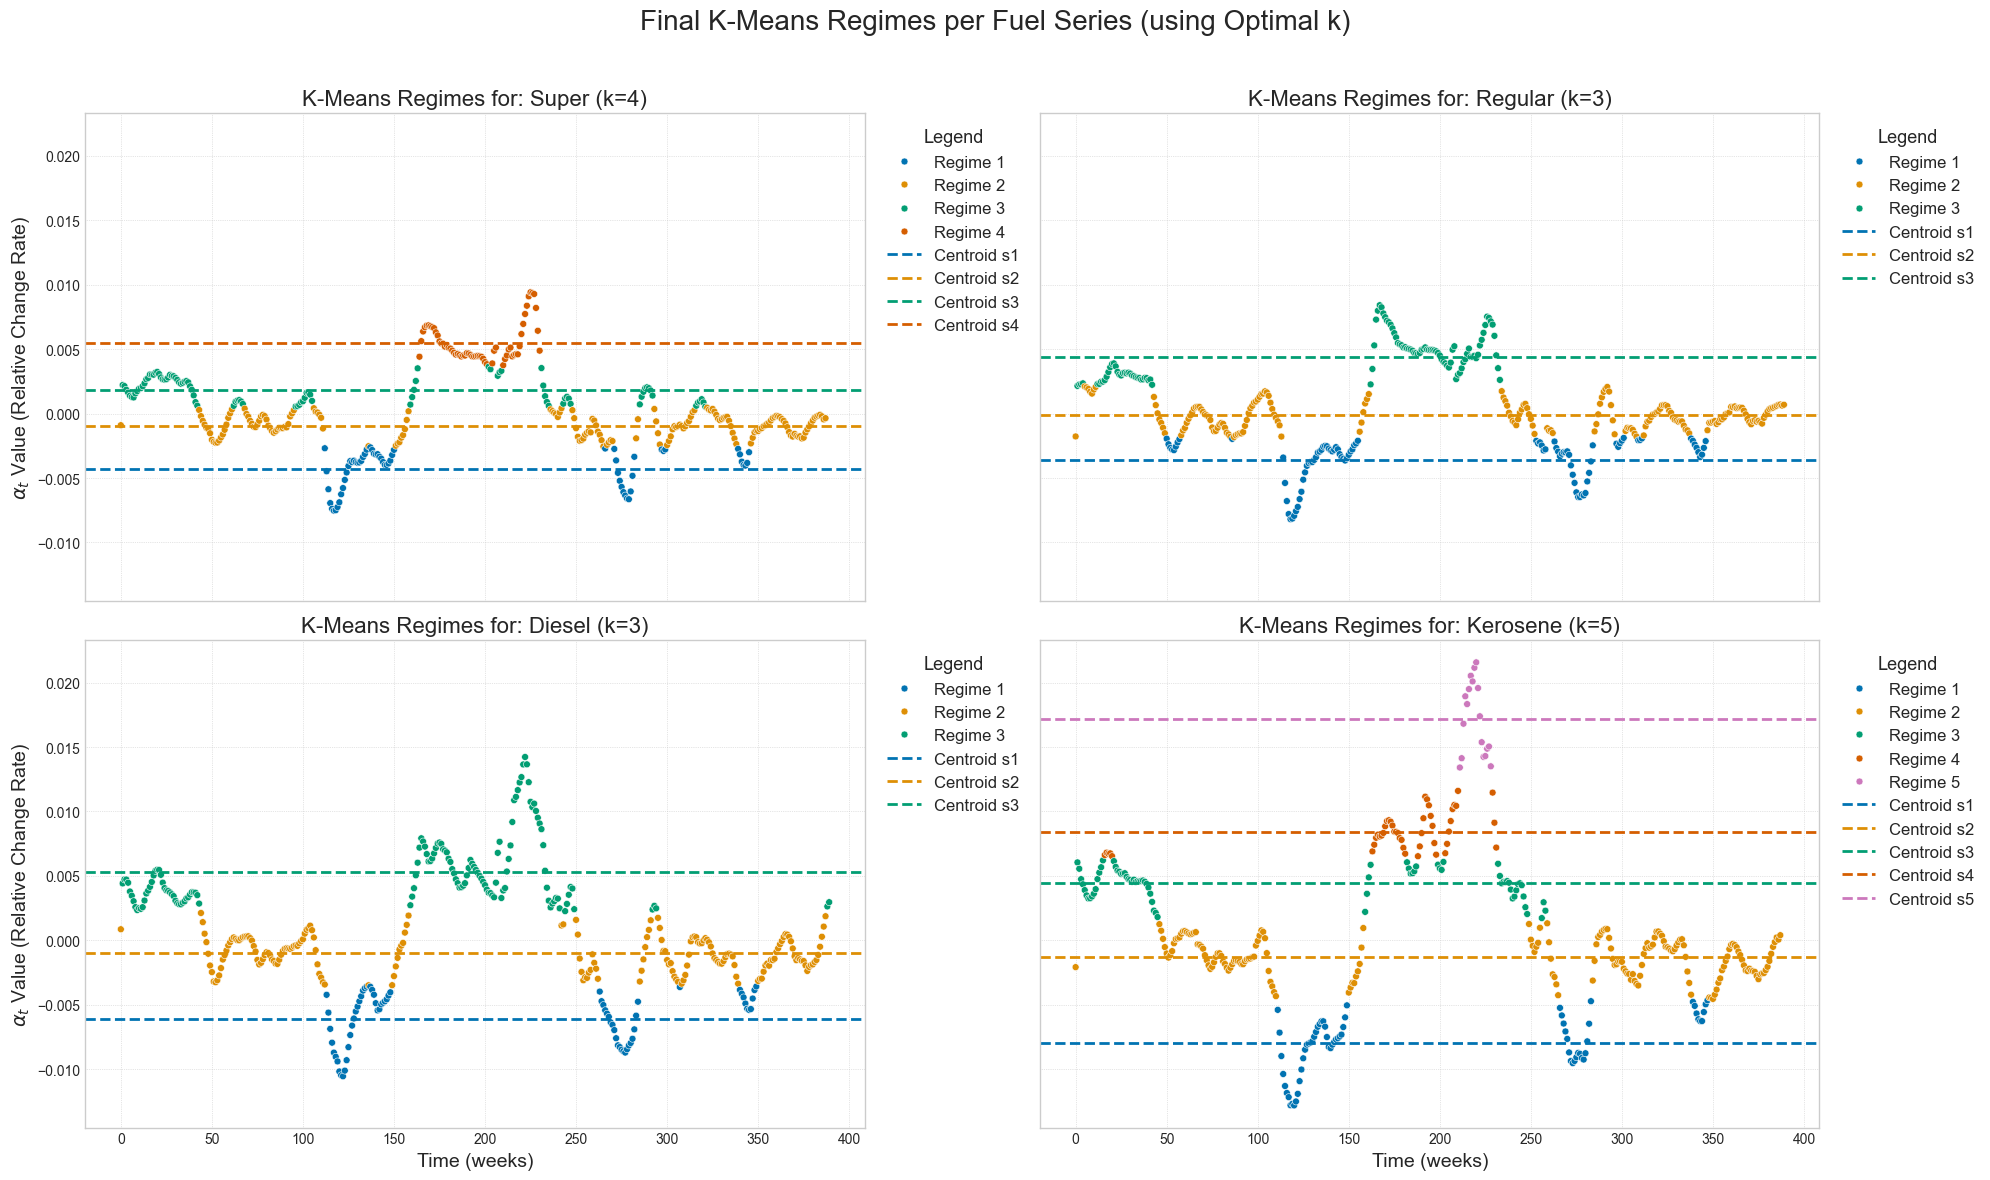

In [45]:
print("\n--- STEP 6: Visualizing the final regimes found by K-Means ---")

# Check if the necessary results from previous steps exist.
if 'kmeans_final_results' in locals() and 'final_analysis_alphas' in locals():
    # Create a 2x2 subplot grid. sharex/sharey make the axes comparable.
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    # --- TEXT SIZE INCREASED ---
    fig.suptitle('Final K-Means Regimes per Fuel Series (using Optimal k)', fontsize=20, y=0.98)

    # Iterate through the final results for each fuel series.
    for i, (name, data) in enumerate(kmeans_final_results.items()):
        ax = axes[i]
        
        # Extract the necessary data calculated in previous steps.
        alphas = final_analysis_alphas[name]
        states = data['states']
        centroids = data['centroids']
        k_optimal = len(centroids)
        
        # --- Data Preparation for Plotting ---
        # Create a pandas DataFrame, which is the ideal format for seaborn plots.
        df_plot = pd.DataFrame({
            'time': range(len(alphas)),
            'alpha': alphas,
            'regime': states  # Use original 0-indexed states for palette mapping
        })
        
        # --- Plotting ---
        # 1. Create a scatter plot of the alpha values over time.
        # `hue` automatically colors each point based on its 'regime'.
        sns.scatterplot(
            data=df_plot, 
            x='time', 
            y='alpha', 
            hue='regime',
            palette=sns.color_palette("colorblind", n_colors=k_optimal),
            ax=ax, 
            legend='full', 
            s=25  # Adjust point size for better visibility
        )
        
        # 2. Draw horizontal dashed lines to indicate the centroid for each regime.
        # This shows the average alpha value for each color-coded regime.
        for k_idx, centroid in enumerate(centroids):
            ax.axhline(
                y=centroid, 
                color=sns.color_palette("colorblind")[k_idx],
                linestyle='--', 
                linewidth=2,
                label=f'Centroid s{k_idx+1}' # Label for the legend
            )
        
        # --- TEXT SIZES INCREASED ---
        # --- Formatting and Legend Handling ---
        ax.set_title(f'K-Means Regimes for: {name} (k={k_optimal})', fontsize=16)
        ax.set_ylabel('$\\alpha_t$ Value (Relative Change Rate)', fontsize=14)
        ax.set_xlabel('Time (weeks)', fontsize=14)
        ax.grid(True, linestyle=':', linewidth=0.5)

        # 3. Consolidate the legend to remove duplicate labels from axhline.
        # Get all legend elements (handles) and their corresponding labels.
        handles, labels = ax.get_legend_handles_labels()
        # Use a dictionary to automatically keep only the first unique label.
        unique_labels = dict(zip(labels, handles))
        # Recreate the legend with unique items and proper regime labels.
        legend_labels = [f'Regime {int(l)+1}' for l in unique_labels.keys() if l.isdigit()] + \
                        [l for l in unique_labels.keys() if not l.isdigit()]
        
        # --- TEXT SIZES INCREASED ---
        ax.legend(unique_labels.values(), legend_labels, title='Legend', 
                  bbox_to_anchor=(1.01, 1), loc='upper left', 
                  title_fontsize='13', fontsize='12')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "8_kmeans_final_regimes_plot.png"), dpi=600, bbox_inches='tight')
    plt.show()
else:
    print("Final K-Means results not found. Please run previous steps first.")

## =====================================================================
## STEP 7: MARKOV CHAIN SIMULATION & STATIONARY DISTRIBUTION
## =====================================================================
 
This step simulates the evolution of the Markov chain over time to find its stationary distribution. A stationary distribution represents the long-term equilibrium probabilities of being in any given state, regardless of the starting state.

The simulation starts from the most common historical state and applies the transition matrix repeatedly until the state probabilities stabilize.


--- STEP 7: Visualizing the Evolution of State Probabilities (K-Means Simulation) ---


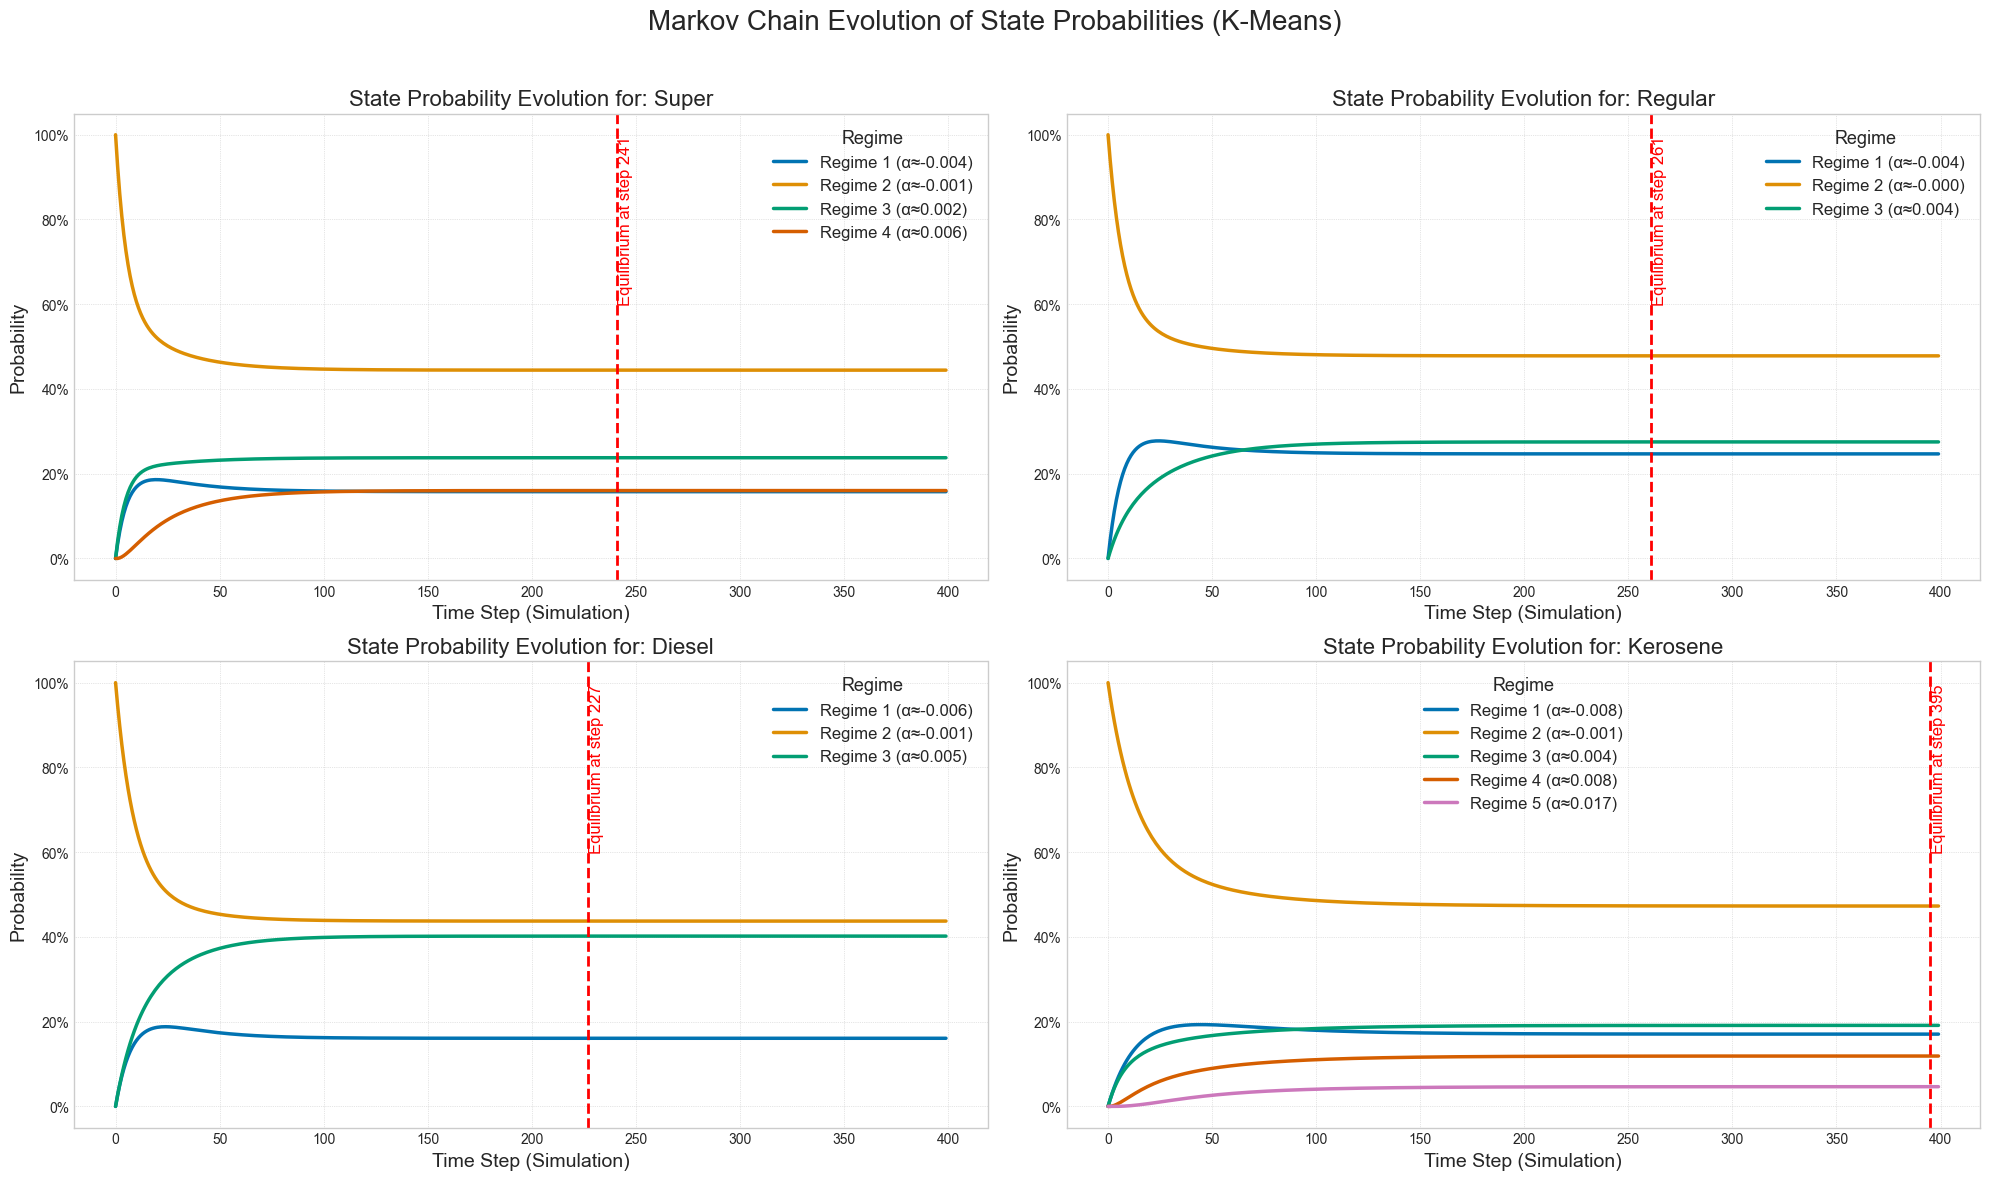

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import mode  # <-- ESTA ES LA LÍNEA QUE FALTABA

print("\n--- STEP 7: Visualizing the Evolution of State Probabilities (K-Means Simulation) ---")

# Check if the final K-Means results dictionary from previous steps exists.
if 'kmeans_final_results' in locals() and kmeans_final_results:
    # Create the 2x2 plot grid.
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    fig.suptitle('Markov Chain Evolution of State Probabilities (K-Means)', fontsize=20, y=0.98)

    # Iterate through the final model results for each fuel series.
    for i, (name, data) in enumerate(kmeans_final_results.items()):
        ax = axes[i]
        
        # --- 1. Extract Data from the Final K-Means Analysis ---
        P = data['Ap_srep']  # The robustly estimated transition matrix
        num_states = P.shape[0]
        states_sequence = data['states']
        centroids = data['centroids']
        
        # --- 2. Define the Initial State Probability Vector (p0) ---
        p0 = np.zeros(num_states)
        if len(states_sequence) > 0:
            # Find the mode (most common state)
            start_state_index = mode(states_sequence).mode
            p0[start_state_index] = 1.0  # Set its probability to 100%
        else:
            p0[0] = 1.0 # Fallback if no states exist

        # --- 3. Run the Markov Chain Simulation ---
        num_steps = 400  # Number of future time steps to simulate
        trajectory = np.zeros((num_states, num_steps))
        trajectory[:, 0] = p0

        stability_step = -1 # To record when the system stabilizes
        
        for t in range(1, num_steps):
            # The core of the simulation: p(t) = P * p(t-1)
            trajectory[:, t] = P @ trajectory[:, t-1]
            
            # Check for convergence to a stationary distribution
            if stability_step == -1:
                change = np.linalg.norm(trajectory[:, t] - trajectory[:, t-1], 1)
                if change < 1e-6:
                    stability_step = t

        # --- 4. Plot the Results ---
        regime_colors = sns.color_palette("colorblind", n_colors=num_states)
        state_labels = [f'Regime {k+1} (α≈{c:.3f})' for k, c in enumerate(centroids)]
        
        for j, label in enumerate(state_labels):
            ax.plot(trajectory[j, :], label=label, color=regime_colors[j], linewidth=2.5)
        
        if stability_step != -1:
            ax.axvline(x=stability_step, color='red', linestyle='--', linewidth=2)
            ax.text(stability_step + 0.5, ax.get_ylim()[1] * 0.95,
                    f'Equilibrium at step {stability_step}',
                    color='red', rotation=90, verticalalignment='top', fontsize=12)

        # --- 5. Formatting ---
        ax.set_title(f'State Probability Evolution for: {name}', fontsize=16)
        ax.set_xlabel('Time Step (Simulation)', fontsize=14)
        ax.set_ylabel('Probability', fontsize=14)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.legend(title='Regime', title_fontsize='13', fontsize='12')
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Ensure the output folder exists before saving
    if 'OUTPUT_FOLDER_OPTIMIZED' in locals():
        if not os.path.exists(OUTPUT_FOLDER_OPTIMIZED):
            os.makedirs(OUTPUT_FOLDER_OPTIMIZED)
        fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "9_kmeans_markov_evolution.png"), dpi=600, bbox_inches='tight')
    
    plt.show()

else:
    print("Execution halted: Final K-Means results not found. Please run previous steps first.")

## =====================================================================
## STEP 8: PREDICTIVE ROBUSTNESS ANALYSIS (K-MEANS MODEL)
## =====================================================================
 
This step performs a robustness check on the final K-Means models. It uses a rolling-origin validation scheme (also known as walk-forward validation) to assess how the model's predictive performance holds up across different time periods. The model is repeatedly trained on a growing window of historical data and tested on the subsequent period.

In [47]:
print("\n--- STEP 8: Running Predictive Robustness Analysis for the Optimal K-Means Model ---")

# This dictionary will store the summary DataFrames for each fuel type.
predictive_summaries_kmeans = {}

# Check if the required data from previous steps exists.
if 'fuel_series' in locals() and 'df_best_results' in locals():
    best_df = df_best_results
    
    # Iterate over each fuel series in the predefined order.
    for name in list(best_df['Fuel Series']):
        print(f"\n" + "="*70)
        print(f"PREDICTIVE ROBUSTNESS ANALYSIS FOR: {name.upper()}")
        print("="*70)
        
        # --- 1. RE-USE THE OPTIMAL HYPERPARAMETERS ---
        try:
            optimal_params = best_df[best_df['Fuel Series'] == name].iloc[0]
            W_optimal = int(optimal_params['W'])
            Lambda_optimal = float(optimal_params['Lambda'])
            k_optimal = int(optimal_params['k'])
            print(f"Re-evaluating with optimal parameters: W={W_optimal}, Lambda={Lambda_optimal}, k={k_optimal}")
        except (IndexError, TypeError):
            print(f"ERROR: Could not find optimal parameters for {name}. Skipping.")
            continue

        # --- 2. RE-CALCULATE ALPHAS WITH OPTIMAL PARAMETERS ---
        series = fuel_series.get(name)
        if series is None:
            print(f"Time series data for {name} not found. Skipping.")
            continue
        
        alphas = calculate_alphas_corrected(series, W=W_optimal, lambda_decay=Lambda_optimal)
        
        # --- 3. RUN THE VALIDATION USING THE *EXACT SAME* FUNCTION AS THE GRID SEARCH ---
        # This is the crucial step for consistency.
        partition_results = compute_predictive_metrics_detailed(
            alphas, 
            series, 
            k_optimal, 
            W_optimal
        )
        
        # --- 4. FORMAT AND DISPLAY RESULTS ---
        df_summary = pd.DataFrame(partition_results).dropna()
        predictive_summaries_kmeans[name] = df_summary
        
        # Calculate the final averages from the per-partition results.
        # This ensures the numbers are mathematically identical to the grid search summary.
        avg_accuracy = df_summary['Accuracy'].mean()
        avg_rmse = df_summary['RMSE'].mean()
        
        print("Performance across different train/test splits:")
        print(df_summary.to_string(index=False))
        
        print("-" * 70)
        # We print with high precision to confirm the values are identical.
        print(f"Overall Average Accuracy for {name}: {avg_accuracy:.10f}")
        print(f"Overall Average RMSE for {name}: {avg_rmse:.10f}")
        print("-" * 70)

    # --- Export all summary tables to a single Excel file ---
    excel_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "10_predictive_summary_kmeans_consistent.xlsx")
    with pd.ExcelWriter(excel_path) as writer:
        for name, df in predictive_summaries_kmeans.items():
            df.to_excel(writer, sheet_name=name, index=False, float_format="%.10f")
            
    print(f"\nConsistent predictive summaries for K-Means saved to: '{excel_path}'")

else:
    print("Execution halted: Required data ('fuel_series', 'df_best_results') not found. Please run previous steps first.")


--- STEP 8: Running Predictive Robustness Analysis for the Optimal K-Means Model ---

PREDICTIVE ROBUSTNESS ANALYSIS FOR: SUPER
Re-evaluating with optimal parameters: W=52, Lambda=0.99, k=4
Performance across different train/test splits:
Partition  Accuracy     RMSE
    60/40  0.128205 1.448943
    65/35  0.720588 1.159958
    70/29  0.632479 1.144926
    75/24  0.298969 1.084784
    80/19  0.794872 0.854737
    85/14  0.847458 0.799318
     90/9  1.000000 0.638776
     95/4  0.600000 0.683806
----------------------------------------------------------------------
Overall Average Accuracy for Super: 0.6278213113
Overall Average RMSE for Super: 0.9769059927
----------------------------------------------------------------------

PREDICTIVE ROBUSTNESS ANALYSIS FOR: REGULAR
Re-evaluating with optimal parameters: W=50, Lambda=0.99, k=3
Performance across different train/test splits:
Partition  Accuracy     RMSE
    60/40  0.666667 1.156628
    65/35  0.664234 1.013094
    70/29  0.880342 1.

## =====================================================================
## STEP 9: VISUALIZING QUANTILE-BASED REGIMES (BENCHMARK MODEL)
## =====================================================================

This step visualizes the alpha time series, with each point colored according to the regime assigned by the fixed k=4 Quantile benchmark model. This provides a direct visual comparison to the K-Means regime plot, showing how a different discretization method partitions the data.


--- STEP 9: Visualizing the Regimes found by Quantiles ---


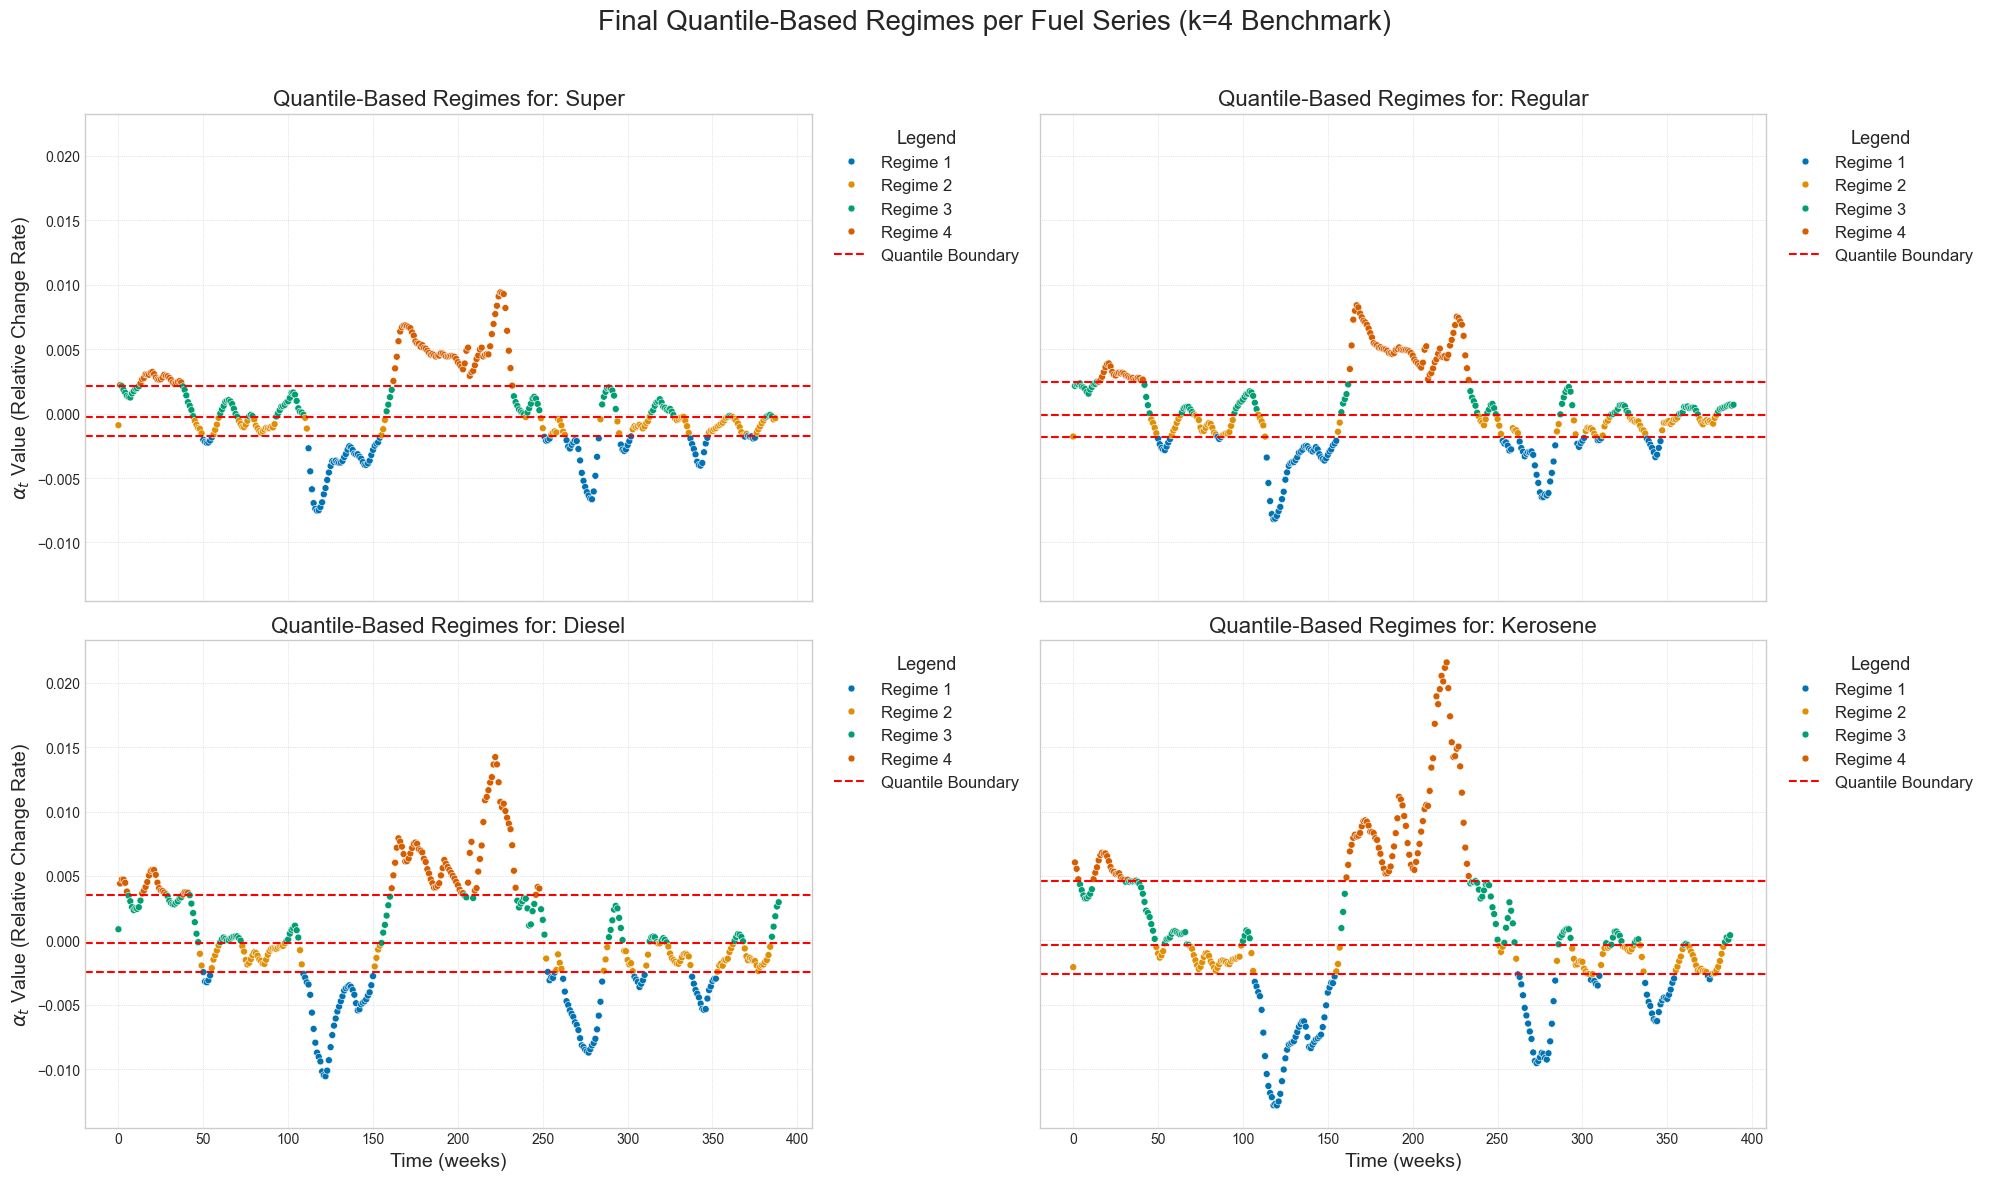

In [48]:
print("\n--- STEP 9: Visualizing the Regimes found by Quantiles ---")

# Check if the results from the quantile analysis exist.
if 'quantiles_final_results' in locals() and 'final_analysis_alphas' in locals():
    # Create a 2x2 subplot grid, matching the style of the K-Means plot.
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    # --- TEXT SIZE INCREASED ---
    fig.suptitle('Final Quantile-Based Regimes per Fuel Series (k=4 Benchmark)', fontsize=20, y=0.98)

    # Iterate through the final results for each series.
    for i, (name, data) in enumerate(quantiles_final_results.items()):
        ax = axes[i]
        
        # Extract the necessary data from previous steps.
        alphas = final_analysis_alphas[name]
        states = data['states']
        boundaries = data['boundaries']
        num_quantile_states = 4
        
        # --- Data Preparation for Plotting ---
        df_plot = pd.DataFrame({
            'time': range(len(alphas)),
            'alpha': alphas,
            'regime': states  # Use original 0-indexed states for palette mapping
        })
        
        # --- Plotting ---
        # 1. Create the scatter plot, colored by the quantile-based regime.
        sns.scatterplot(
            data=df_plot, 
            x='time', 
            y='alpha', 
            hue='regime',
            palette=sns.color_palette("colorblind", n_colors=num_quantile_states),
            ax=ax, 
            legend='full', 
            s=25
        )
        
        # 2. Draw horizontal dashed lines to show the quantile boundaries.
        # These are the thresholds that separate one regime from the next.
        for b_idx, boundary in enumerate(boundaries):
            # Only add a label to the first boundary line to avoid duplicate legend entries.
            label = 'Quantile Boundary' if b_idx == 0 else None
            ax.axhline(
                y=boundary, 
                color='red', 
                linestyle='--', 
                linewidth=1.5,
                label=label
            )
        
        # --- TEXT SIZES INCREASED ---
        # --- Formatting and Legend Handling ---
        ax.set_title(f'Quantile-Based Regimes for: {name}', fontsize=16)
        ax.set_xlabel('Time (weeks)', fontsize=14)
        ax.set_ylabel('$\\alpha_t$ Value (Relative Change Rate)', fontsize=14)
        ax.grid(True, linestyle=':', linewidth=0.5)

        # 3. Consolidate and format the legend to match the K-Means plot style.
        handles, labels = ax.get_legend_handles_labels()
        # Use a dictionary to ensure all legend entries are unique.
        unique_labels = dict(zip(labels, handles))
        # Create descriptive labels for the legend entries.
        legend_labels = [f'Regime {int(l)+1}' for l in unique_labels.keys() if l.isdigit()] + \
                        [l for l in unique_labels.keys() if not l.isdigit()]
        # Place the legend outside the top-right corner of the plot.
        # --- TEXT SIZES INCREASED ---
        ax.legend(unique_labels.values(), legend_labels, title='Legend', 
                  bbox_to_anchor=(1.01, 1), loc='upper left',
                  title_fontsize='13', fontsize='12')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "11_quantile_final_regimes_plot.png"), dpi=600, bbox_inches='tight')
    plt.show()
else:
    print("Final Quantile results not found. Please run previous steps first.")

## ===========================================================================
## STEP 10: MARKOV CHAIN SIMULATION (QUANTILE BENCHMARK)
## ===========================================================================

This step mirrors the simulation performed in Step 7, but applies it to the Quantile-based benchmark model. By comparing the long-term equilibrium (stationary distribution) of this model to that of the K-Means model, we can assess whether the different discretization methods lead to fundamentally different conclusions about the market's long-term dynamics.



--- STEP 10: Visualizing the Evolution of State Probabilities (Quantiles Simulation) ---


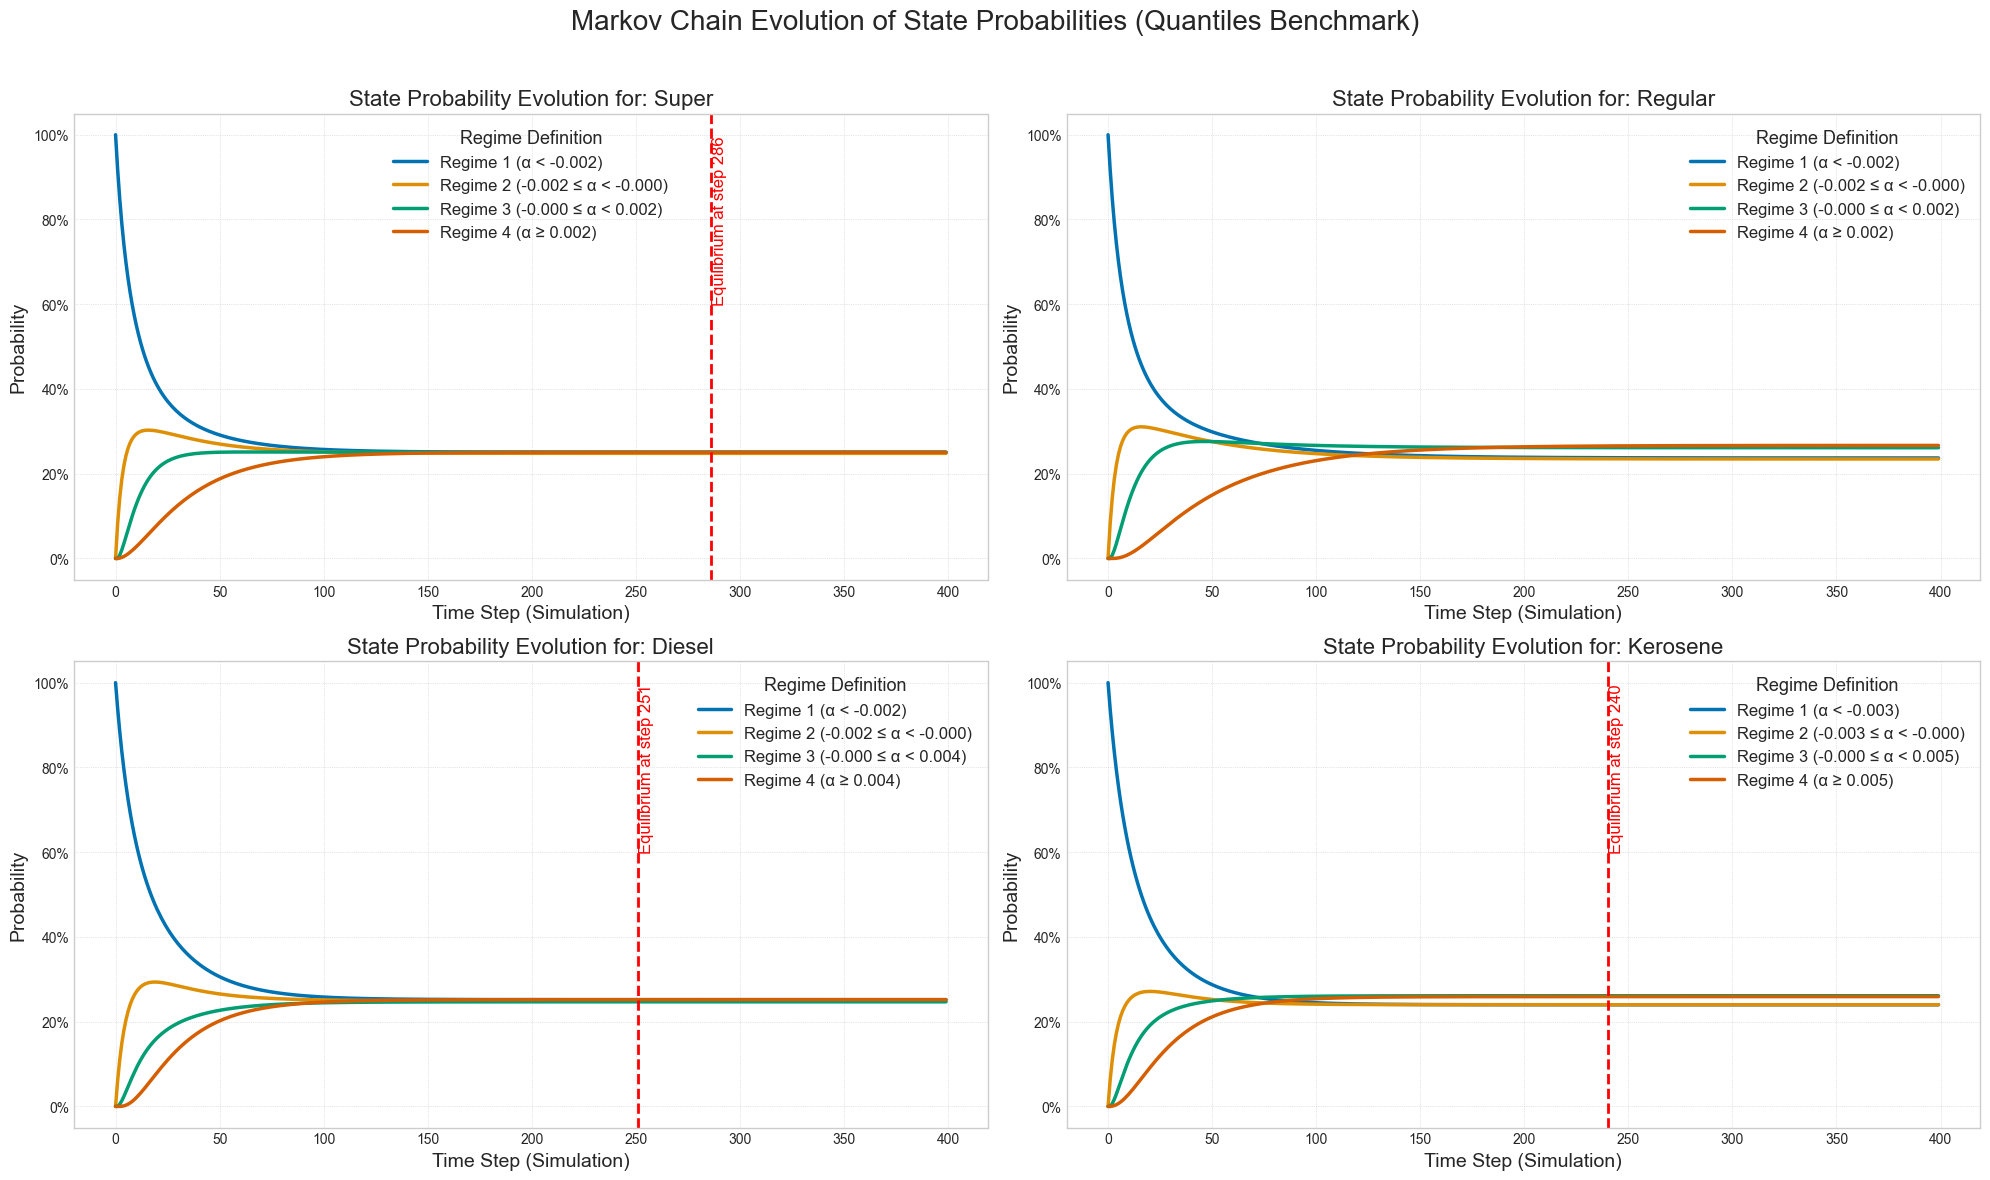

In [50]:
print("\n--- STEP 10: Visualizing the Evolution of State Probabilities (Quantiles Simulation) ---")

# Check if the final Quantiles results dictionary exists.
if 'quantiles_final_results' in locals() and quantiles_final_results:
    # --- Setup ---
    num_quantile_states = 4 # k is fixed at 4 for the benchmark
    regime_colors = sns.color_palette("colorblind", n_colors=num_quantile_states)

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    # --- TEXT SIZE INCREASED ---
    fig.suptitle('Markov Chain Evolution of State Probabilities (Quantiles Benchmark)', fontsize=20, y=0.98)

    # Iterate through the final benchmark model results for each series.
    for i, (name, data) in enumerate(quantiles_final_results.items()):
        ax = axes[i]
        
        # --- 1. Extract Data from the Final Quantiles Analysis ---
        P = data['Ap_srep']
        boundaries = data['boundaries']
        states_sequence = data['states']
        
        # --- 2. Create Human-Readable Labels from Quantile Boundaries ---
        # This logic constructs descriptive labels for each of the 4 regimes.
        state_labels = []
        state_labels.append(f'Regime 1 (α < {boundaries[0]:.3f})')
        state_labels.append(f'Regime 2 ({boundaries[0]:.3f} ≤ α < {boundaries[1]:.3f})')
        state_labels.append(f'Regime 3 ({boundaries[1]:.3f} ≤ α < {boundaries[2]:.3f})')
        state_labels.append(f'Regime 4 (α ≥ {boundaries[2]:.3f})')

        # --- 3. Define the Initial State and Run Simulation ---
        # The simulation starts from the most common state found in the historical data.
        p0 = np.zeros(num_quantile_states)
        if len(states_sequence) > 0:
            start_state_index = mode(states_sequence).mode
            p0[start_state_index] = 1.0
        else:
            p0[0] = 1.0

        num_steps = 400
        trajectory = np.zeros((num_quantile_states, num_steps))
        trajectory[:, 0] = p0

        stability_step = -1
        # The simulation core: p(t) = P * p(t-1)
        for t in range(1, num_steps):
            trajectory[:, t] = P @ trajectory[:, t-1]
            if stability_step == -1:
                change = np.linalg.norm(trajectory[:, t] - trajectory[:, t-1], 1)
                if change < 1e-6:
                    stability_step = t

        # --- 4. Plot the Probability Trajectories ---
        for j, label in enumerate(state_labels):
            ax.plot(trajectory[j, :], label=label, color=regime_colors[j], linewidth=2.5)
        
        # Mark the point of convergence to the stationary distribution.
        if stability_step != -1:
            ax.axvline(x=stability_step, color='red', linestyle='--', linewidth=2)
            # --- TEXT SIZE INCREASED ---
            ax.text(stability_step + 0.5, ax.get_ylim()[1] * 0.95,
                    f'Equilibrium at step {stability_step}',
                    color='red', rotation=90, verticalalignment='top', fontsize=12)

        # --- TEXT SIZES INCREASED ---
        # --- 5. Formatting ---
        ax.set_title(f'State Probability Evolution for: {name}', fontsize=16)
        ax.set_xlabel('Time Step (Simulation)', fontsize=14)
        ax.set_ylabel('Probability', fontsize=14)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.legend(title='Regime Definition', title_fontsize='13', fontsize='12')
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "12_quantiles_markov_evolution.png"), dpi=600, bbox_inches='tight')
    plt.show()

else:
    print("Execution halted: Final Quantile results not found. Please run previous steps first.")

## ===========================================================================
## STEP 11: PREDICTIVE ROBUSTNESS ANALYSIS (QUANTILES BENCHMARK)
## ===========================================================================

This final validation step mirrors the analysis from Step 8, but applies it to the Quantile-based benchmark model. By subjecting the benchmark model to the same rolling-origin validation, we can create a direct, "apples-to-apples" comparison of its predictive consistency against the optimized K-Means model.

In [51]:
print("\n--- STEP 11: Running Predictive Robustness Analysis for the Quantiles Method (Fixed k=4 Benchmark) ---")

# This dictionary will store the summary DataFrames for the Quantiles method.
predictive_summaries_quantiles = {}

# Check if the final Quantiles analysis results exist.
if 'quantiles_final_results' in locals() and quantiles_final_results:
    np.random.seed(42)  # Reset seed for consistency

    # Iterate over each fuel series to perform the predictive analysis.
    for name, data in quantiles_final_results.items():
        print(f"\n" + "="*60)
        print(f"PREDICTIVE ROBUSTNESS ANALYSIS (QUANTILES) FOR: {name.upper()}")
        print("="*60)
        
        # Safely retrieve the necessary alpha and original series data.
        alphas = final_analysis_alphas.get(name)
        series = fuel_series.get(name)
        if alphas is None or series is None:
            print(f"Data for {name} not found. Skipping.")
            continue
        
        # --- Run the validation using the dedicated metrics function ---
        # We specify `method='quantiles'` to use the correct discretization logic.
        avg_accuracy, avg_rmse, partition_results = compute_predictive_metrics(
            alphas, series, FIXED_K_QUANTILES, W, method='quantiles', use_cv=False, return_splits=True
        )
        
        # --- Format and Display Results ---
        # Create a clean summary table from the detailed per-split results.
        df_summary = pd.DataFrame(partition_results)
        predictive_summaries_quantiles[name] = df_summary
        
        # Display the table in the console for immediate review.
        print("Performance across different train/test splits:")
        print(df_summary.drop(columns=['raw_accuracy'], errors='ignore').to_string(index=False))
        
        # Display the final, overall average performance metrics for the benchmark model.
        print("-" * 60)
        print(f"Overall Average Accuracy for {name} (Quantiles): {avg_accuracy:.2%}")
        print(f"Overall Average RMSE for {name} (Quantiles): {avg_rmse:.4f}")
        print("-" * 60)

    # --- Export all summary tables to a single Excel file for easy comparison ---
    excel_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "13_predictive_summary_quantiles.xlsx")
    with pd.ExcelWriter(excel_path) as writer:
        for name, df_summary in predictive_summaries_quantiles.items():
            # Write each fuel's summary to a separate, named sheet.
            df_summary.drop(columns=['raw_accuracy'], errors='ignore').to_excel(writer, sheet_name=name, index=False)
            
    print(f"\n Predictive summaries for Quantiles saved to: '{excel_path}'")

else:
    print("Execution halted: Final Quantile results not found. Please run previous steps first.")


--- STEP 11: Running Predictive Robustness Analysis for the Quantiles Method (Fixed k=4 Benchmark) ---

PREDICTIVE ROBUSTNESS ANALYSIS (QUANTILES) FOR: SUPER
Performance across different train/test splits:
Split (Train/Test) Accuracy   RMSE
           60%/40%    7.69% 1.9493
           65%/35%   48.53% 2.0926
           70%/30%   37.61% 1.8392
           75%/25%    7.22% 1.5006
           80%/20%   71.79% 1.2664
           85%/15%   69.49% 1.3390
           90%/10%   94.87% 0.8685
            95%/5%   55.00% 0.7535
------------------------------------------------------------
Overall Average Accuracy for Super (Quantiles): 49.03%
Overall Average RMSE for Super (Quantiles): 1.4511
------------------------------------------------------------

PREDICTIVE ROBUSTNESS ANALYSIS (QUANTILES) FOR: REGULAR
Performance across different train/test splits:
Split (Train/Test) Accuracy   RMSE
           60%/40%    3.21% 1.6270
           65%/35%   37.23% 1.7066
           70%/30%   24.79% 1.3840
     

## ===================================================================================
## STEP 11: CONSOLIDATED PREDICTIVE ROBUSTNESS ANALYSIS (WITH BENCHMARK AND RMSE)
## ===================================================================================

In [52]:
print("\n--- STEP 11: Running Consolidated Predictive Performance Comparison ---")

# This dictionary will store the final summary DataFrames.
final_predictive_summaries = {}
FIXED_K_QUANTILES = 4

# Check for the existence of the necessary data from previous steps.
if 'final_analysis_alphas' in locals() and final_analysis_alphas:
    np.random.seed(42)  # for reproducibility

    # Iterate over each fuel series for the comparative analysis.
    for name, series in fuel_series.items():
        print(f"\n" + "="*60)
        print(f"COMPARATIVE ANALYSIS FOR: {name.upper()}")
        print("="*60)
        
        alphas = final_analysis_alphas[name]
        k_optimal_series = optimal_ks.get(name, FIXED_K_QUANTILES)
        
        # --- Model 1: TCROC-KMeans (Optimized Model) ---
        print("  - Evaluating TCROC-KMeans model...")
        # The required 'W' argument is now included in the function call.
        avg_acc_km, avg_rmse_km = compute_predictive_metrics(
            alphas, series, k_optimal_series, W, method='kmeans', use_cv=False, return_splits=False
        )
        
        # --- Model 2: TCROC-Quantiles (Benchmark Model) ---
        print("  - Evaluating TCROC-Quantiles benchmark...")
        # The required 'W' argument is also included here.
        avg_acc_q, avg_rmse_q = compute_predictive_metrics(
            alphas, series, FIXED_K_QUANTILES, W, method='quantiles', use_cv=False, return_splits=False
        )
        
        # --- Model 3: MS-AR (Classic Econometric Benchmark with FAIR VALIDATION) ---
        print("  - Evaluating MS-AR benchmark...")
        msar_rmses = []
        # The same rolling-origin splits as used by compute_predictive_metrics
        ratios = np.arange(0.60, 0.96, 0.05)
        
        for r in ratios:
            # Define the train/test split for this iteration
            train_idx_end = int(len(series) * r)
            train_data = series[:train_idx_end]
            test_data = series[train_idx_end:]
            
            if len(test_data) == 0 or len(train_data) < 10: continue

            try:
                # Fit the MS-AR model ONLY on the training data
                model_msar = sm.tsa.MarkovAutoregression(train_data, k_regimes=k_optimal_series, order=1, switching_variance=True)
                res_msar = model_msar.fit(disp='none')
                
                # Generate one-step-ahead predictions for the test period
                preds_msar = res_msar.predict(start=len(train_data), end=len(series) - 1)
                
                # Calculate RMSE on the out-of-sample test data
                rmse_split = np.sqrt(mean_squared_error(test_data, preds_msar[:len(test_data)]))
                msar_rmses.append(rmse_split)
            except Exception as e:
                # If a split fails to converge, record it as NaN
                msar_rmses.append(np.nan)
        
        # Calculate the average RMSE across all successful splits
        rmse_msar = np.nanmean(msar_rmses)
        
        # --- Consolidate and Display Summary for the current series ---
        results_data = {
            'TCROC-KMeans': {'Accuracy': avg_acc_km, 'RMSE': avg_rmse_km},
            'TCROC-Quantiles': {'Accuracy': avg_acc_q, 'RMSE': avg_rmse_q},
            'MS-AR Benchmark': {'Accuracy': np.nan, 'RMSE': rmse_msar} # MS-AR doesn't have a comparable state accuracy
        }
        df_final = pd.DataFrame(results_data)
        
        # Format the DataFrame for clean presentation
        df_final_formatted = df_final.copy()
        df_final_formatted.loc['Accuracy'] = df_final.loc['Accuracy'].apply(
            lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
        )
        df_final_formatted.loc['RMSE'] = df_final.loc['RMSE'].round(4)
        
        final_predictive_summaries[name] = df_final_formatted
        print("\n--- Average Predictive Performance Summary ---")
        print(df_final_formatted)

    # --- Export all summaries to a single, final Excel file ---
    excel_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "14_comparative_predictive_summary.xlsx")
    with pd.ExcelWriter(excel_path) as writer:
        for name, df_summary in final_predictive_summaries.items():
            df_summary.to_excel(writer, sheet_name=name)
            
    print(f"\n✅ Comparative predictive summaries saved to: '{excel_path}'")

else:
    print("Execution halted: Fuel series data not found. Please run previous steps.")


--- STEP 11: Running Consolidated Predictive Performance Comparison ---

COMPARATIVE ANALYSIS FOR: SUPER
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCROC-KMeans TCROC-Quantiles MS-AR Benchmark
Accuracy       62.78%          49.03%             N/A
RMSE           1.4381          1.4511             NaN

COMPARATIVE ANALYSIS FOR: REGULAR
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCROC-KMeans TCROC-Quantiles MS-AR Benchmark
Accuracy       85.10%          36.01%             N/A
RMSE           1.1926          1.1964             NaN

COMPARATIVE ANALYSIS FOR: DIESEL
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCR

## ===================================================================================
## STEP 12: CONSOLIDATED PREDICTIVE PERFORMANCE COMPARISON
## ===================================================================================

This final step consolidates the analysis by performing a direct, "apples-to-apples" comparison of the predictive performance of three models:
  1. TCROC-KMeans: The primary model using an optimized k for each series.
  2. TCROC-Quantiles: A benchmark model using a fixed k=4.
  3. MS-AR: A classic econometric Markov Switching Autoregression model.

All models are evaluated using the same robust, rolling-origin validation scheme to ensure the comparison of their out-of-sample performance is fair.


In [53]:
print("\n--- STEP 12: Running Consolidated Predictive Performance Comparison ---")

# This dictionary will store the final summary DataFrames.
final_predictive_summaries = {}
FIXED_K_QUANTILES = 4

# Check for the existence of the necessary data from previous steps.
if 'final_analysis_alphas' in locals() and final_analysis_alphas:
    np.random.seed(42)  # for reproducibility

    # Iterate over each fuel series for the comparative analysis.
    for name, series in fuel_series.items():
        print(f"\n" + "="*60)
        print(f"COMPARATIVE ANALYSIS FOR: {name.upper()}")
        print("="*60)
        
        alphas = final_analysis_alphas[name]
        k_optimal_series = optimal_ks.get(name, FIXED_K_QUANTILES)
        
        # --- Model 1: TCROC-KMeans (Optimized Model) ---
        print("  - Evaluating TCROC-KMeans model...")
        # The function call now correctly unpacks the two expected return values.
        avg_acc_km, avg_rmse_km = compute_predictive_metrics(
            alphas, series, k_optimal_series, W, method='kmeans', use_cv=False, return_splits=False
        )
        
        # --- Model 2: TCROC-Quantiles (Benchmark Model) ---
        print("  - Evaluating TCROC-Quantiles benchmark...")
        # This call is also updated to unpack two values.
        avg_acc_q, avg_rmse_q = compute_predictive_metrics(
            alphas, series, FIXED_K_QUANTILES, W, method='quantiles', use_cv=False, return_splits=False
        )
        
        # --- Model 3: MS-AR (Classic Econometric Benchmark with FAIR VALIDATION) ---
        print("  - Evaluating MS-AR benchmark...")
        msar_rmses = []
        # The same rolling-origin splits as used by compute_predictive_metrics
        ratios = np.arange(0.60, 0.96, 0.05)
        
        for r in ratios:
            # Define the train/test split for this iteration
            train_idx_end = int(len(series) * r)
            train_data = series[:train_idx_end]
            test_data = series[train_idx_end:]
            
            if len(test_data) == 0 or len(train_data) < 10: continue

            try:
                # Fit the MS-AR model ONLY on the training data
                model_msar = sm.tsa.MarkovAutoregression(train_data, k_regimes=k_optimal_series, order=1, switching_variance=True)
                res_msar = model_msar.fit(disp='none')
                
                # Generate one-step-ahead predictions for the test period
                preds_msar = res_msar.predict(start=len(train_data), end=len(series) - 1)
                
                # Calculate RMSE on the out-of-sample test data
                rmse_split = np.sqrt(mean_squared_error(test_data, preds_msar[:len(test_data)]))
                msar_rmses.append(rmse_split)
            except Exception as e:
                # If a split fails to converge, record it as NaN
                msar_rmses.append(np.nan)
        
        # Calculate the average RMSE across all successful splits
        rmse_msar = np.nanmean(msar_rmses)
        
        # --- Consolidate and Display Summary for the current series ---
        results_data = {
            'TCROC-KMeans': {'Accuracy': avg_acc_km, 'RMSE': avg_rmse_km},
            'TCROC-Quantiles': {'Accuracy': avg_acc_q, 'RMSE': avg_rmse_q},
            'MS-AR Benchmark': {'Accuracy': np.nan, 'RMSE': rmse_msar} # MS-AR doesn't have a comparable state accuracy
        }
        df_final = pd.DataFrame(results_data)
        
        # Format the DataFrame for clean presentation
        df_final_formatted = df_final.copy()
        df_final_formatted.loc['Accuracy'] = df_final.loc['Accuracy'].apply(
            lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
        )
        df_final_formatted.loc['RMSE'] = df_final.loc['RMSE'].round(4)
        
        final_predictive_summaries[name] = df_final_formatted
        print("\n--- Average Predictive Performance Summary ---")
        print(df_final_formatted)

    # --- Export all summaries to a single, final Excel file ---
    excel_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "14_comparative_predictive_summary.xlsx")
    with pd.ExcelWriter(excel_path) as writer:
        for name, df_summary in final_predictive_summaries.items():
            df_summary.to_excel(writer, sheet_name=name)
            
    print(f"\n✅ Comparative predictive summaries saved to: '{excel_path}'")

else:
    print("Execution halted: Fuel series data not found. Please run previous steps.")


--- STEP 12: Running Consolidated Predictive Performance Comparison ---

COMPARATIVE ANALYSIS FOR: SUPER
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCROC-KMeans TCROC-Quantiles MS-AR Benchmark
Accuracy       62.78%          49.03%             N/A
RMSE           1.4381          1.4511             NaN

COMPARATIVE ANALYSIS FOR: REGULAR
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCROC-KMeans TCROC-Quantiles MS-AR Benchmark
Accuracy       85.10%          36.01%             N/A
RMSE           1.1926          1.1964             NaN

COMPARATIVE ANALYSIS FOR: DIESEL
  - Evaluating TCROC-KMeans model...
  - Evaluating TCROC-Quantiles benchmark...
  - Evaluating MS-AR benchmark...

--- Average Predictive Performance Summary ---
         TCR

## =====================================================================
## STEP 13: ASSIGNING DESCRIPTIVE NAMES TO REGIMES
## =====================================================================

This step translates the numerical centroids from the K-Means model into descriptive, human-readable names (e.g., 'Stable', 'Bullish'). The naming logic is dynamic, based on the relative position of the centroids, ensuring it is robust to changes in data and the number of states (k).

In [54]:
def assign_regime_names(centroids):
    """
    Dynamically assigns descriptive names to regimes based on their centroid values.

    Args:
        centroids (np.ndarray): A sorted array of regime centroids.

    Returns:
        list: A list of string names corresponding to each centroid.
    """
    k = len(centroids)
    names = [''] * k  # Initialize an empty list of names

    # Find the index of the most stable regime (centroid closest to zero)
    stable_idx = np.argmin(np.abs(centroids))
    names[stable_idx] = 'Stable'
    
    # Name the extremes
    if stable_idx != 0:
        names[0] = 'Strong Decrease'
    if stable_idx != k - 1:
        names[k - 1] = 'Strong Increase'

    # Name the intermediate regimes
    for i in range(k):
        if names[i] == '': # If the name has not been assigned yet
            if i < stable_idx:
                names[i] = 'Moderate Decrease'
            elif i > stable_idx:
                names[i] = 'Moderate Increase'
                
    # Handle the special case of k=2, which has no stable regime
    if k == 2:
        names[0] = 'Decrease'
        names[1] = 'Increase'
        
    return names

print("\n--- STEP 13: Assigning Descriptive Names to Final K-Means Regimes ---")

# Check if the final K-Means results exist
if 'kmeans_final_results' in locals() and kmeans_final_results:
    for name, data in kmeans_final_results.items():
        # Get the centroids for the current series
        centroids = data['centroids']
        states = data['states']
        
        # Call our dynamic naming function
        regime_names = assign_regime_names(centroids)
        
        # --- Store the names back into the results dictionary for later use ---
        data['regime_names'] = regime_names
        
        # --- Display a summary table ---
        print(f"\n" + "="*60)
        print(f"DESCRIPTIVE REGIMES FOR: {name.upper()}")
        print("="*60)
        
        # Calculate the frequency of each state
        state_counts = pd.Series(states).value_counts(normalize=True).sort_index()
        
        summary_data = []
        for i, (centroid, name) in enumerate(zip(centroids, regime_names)):
            frequency = state_counts.get(i, 0) * 100
            summary_data.append({
                'Regime': f's{i+1}',
                'Centroid (α)': f"{centroid:.4f}",
                'Assigned Name': name,
                'Time in State': f"{frequency:.1f}%"
            })
        
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))

else:
    print("Execution halted: `kmeans_final_results` not found. Please run previous steps first.")


--- STEP 13: Assigning Descriptive Names to Final K-Means Regimes ---

DESCRIPTIVE REGIMES FOR: SUPER
Regime Centroid (α)     Assigned Name Time in State
    s1      -0.0043   Strong Decrease         15.7%
    s2      -0.0009            Stable         44.6%
    s3       0.0019 Moderate Increase         23.7%
    s4       0.0055   Strong Increase         16.0%

DESCRIPTIVE REGIMES FOR: REGULAR
Regime Centroid (α)   Assigned Name Time in State
    s1      -0.0036 Strong Decrease         24.6%
    s2      -0.0001          Stable         47.9%
    s3       0.0044 Strong Increase         27.4%

DESCRIPTIVE REGIMES FOR: DIESEL
Regime Centroid (α)   Assigned Name Time in State
    s1      -0.0061 Strong Decrease         17.4%
    s2      -0.0010          Stable         47.4%
    s3       0.0053 Strong Increase         35.1%

DESCRIPTIVE REGIMES FOR: KEROSENE
Regime Centroid (α)     Assigned Name Time in State
    s1      -0.0080   Strong Decrease         17.0%
    s2      -0.0013            

## =====================================================================
## STEP 14: VISUALIZING FINAL REGIMES ON PRICE CHARTS
## =====================================================================

This step creates the most intuitive visualization: the original price time series with the background shaded according to the identified regime. This directly links the model's abstract states to the real-world behavior of the fuel prices, making the results easy to interpret.



--- STEP 14: Visualizing Final K-Means Regimes on Price Charts ---


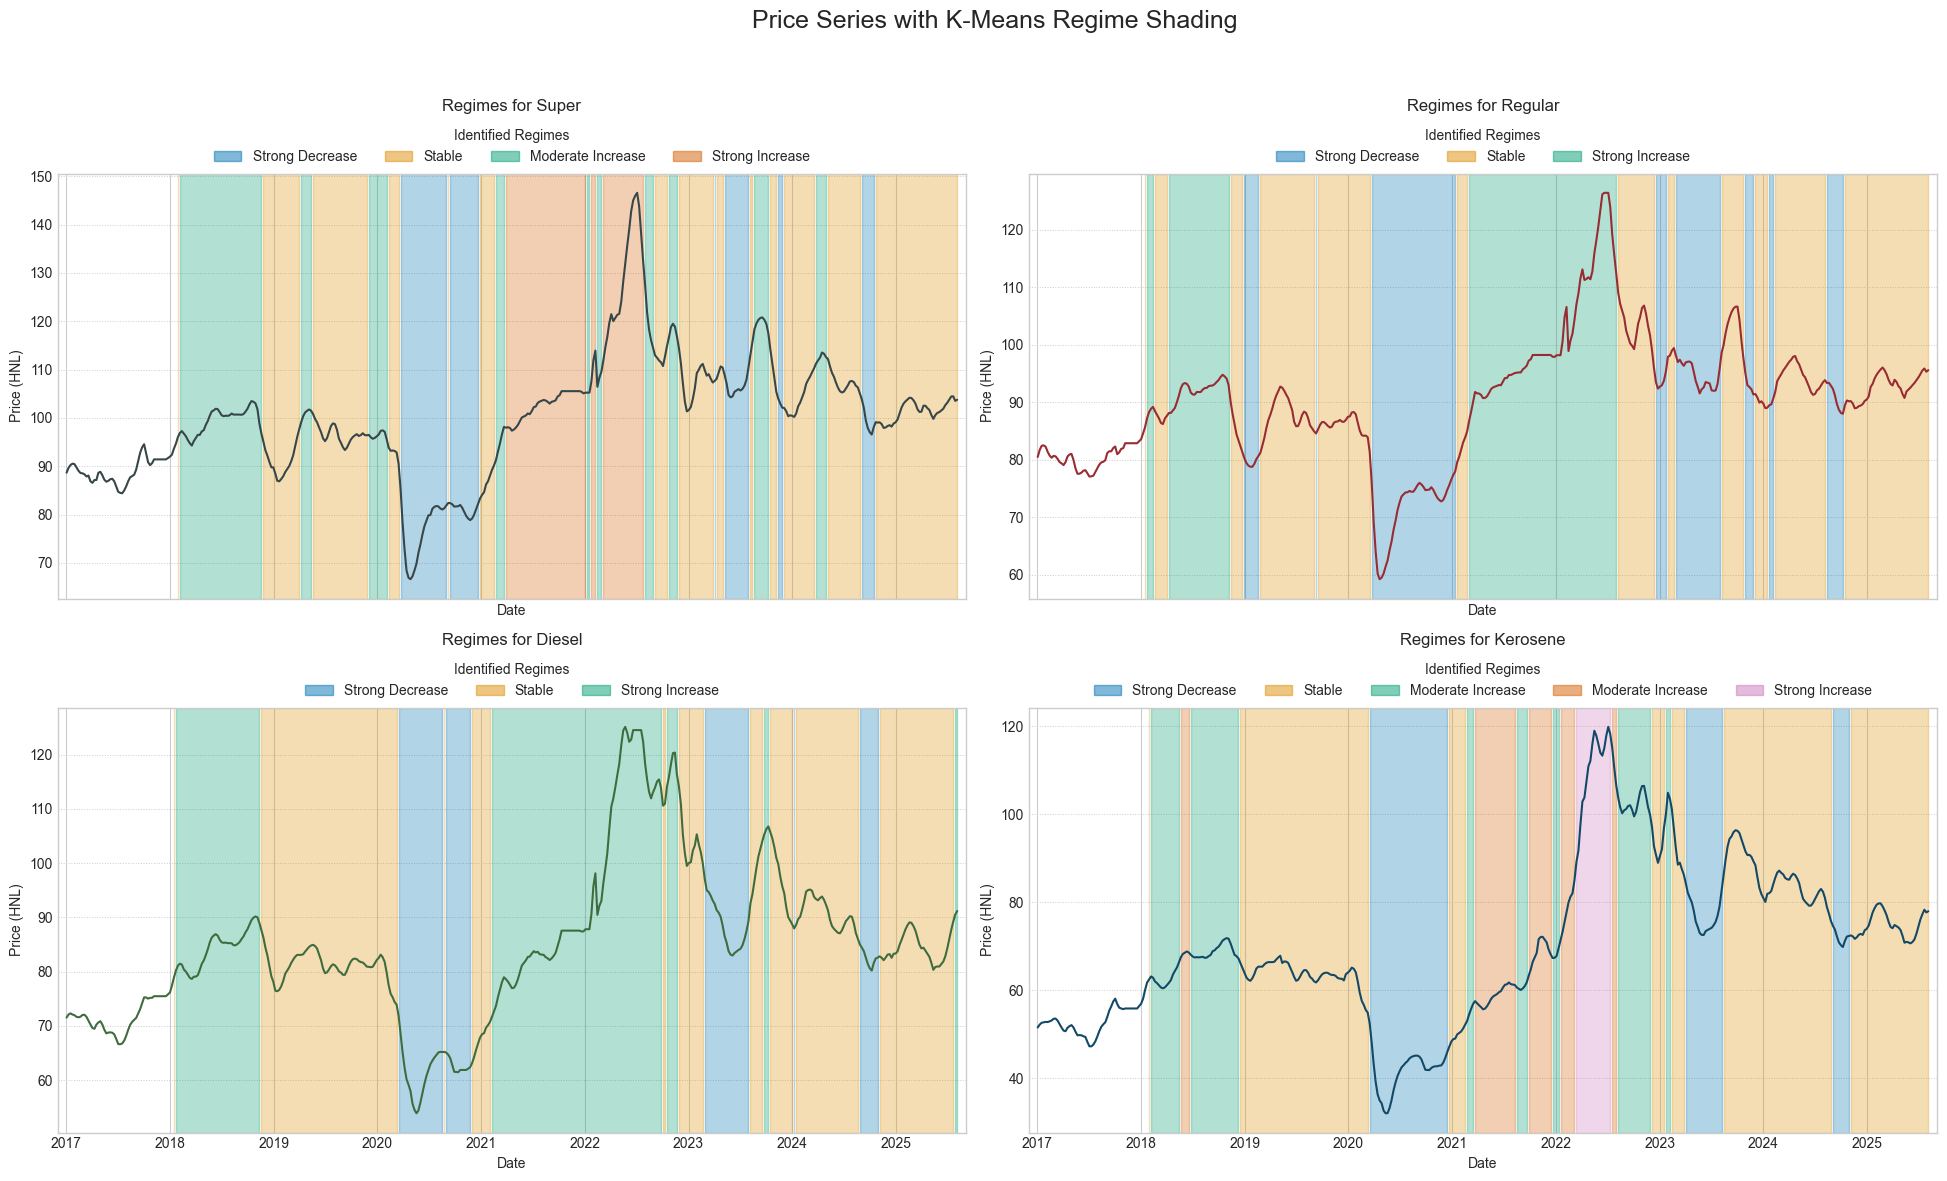

In [55]:
# Import the Patch object for creating custom legends
from matplotlib.patches import Patch

print("\n--- STEP 14: Visualizing Final K-Means Regimes on Price Charts ---")

# Check if the necessary data from previous steps exists.
if 'kmeans_final_results' in locals() and 'fuel_data' in locals():
    # Create the 2x2 plot grid.
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True)
    axes = axes.flatten()
    fig.suptitle('Price Series with K-Means Regime Shading', fontsize=18)

    # Ensure the 'Date' column is in datetime format for plotting
    dates = pd.to_datetime(fuel_data['Date'])

    # Iterate through the final K-Means results.
    for i, (name, data) in enumerate(kmeans_final_results.items()):
        ax = axes[i]
        
        # --- 1. Extract Data ---
        prices = fuel_data[name]
        states = data['states']
        regime_names = data['regime_names']
        k = len(regime_names)
        colors = sns.color_palette("colorblind", n_colors=k)
        
        # Align the states sequence with the full date and price series.
        start_index = len(dates) - len(states)
        aligned_dates = dates[start_index:]
        
        # --- 2. Shade the Background with Regimes ---
        current_state = states[0]
        block_start_date = aligned_dates.iloc[0]

        for t in range(1, len(states)):
            if states[t] != current_state:
                block_end_date = aligned_dates.iloc[t-1]
                ax.axvspan(block_start_date, block_end_date, color=colors[current_state], alpha=0.3)
                current_state = states[t]
                block_start_date = aligned_dates.iloc[t]
        
        ax.axvspan(block_start_date, aligned_dates.iloc[-1], color=colors[current_state], alpha=0.3)
        
        # --- 3. Plot the Price Line ---
        ax.plot(dates, prices, color=fuel_colors.get(name, 'black'), label=f'{name} Price', zorder=2)
        
        # --- 4. Create a Custom, Individual Legend for each subplot ---
        legend_patches = [Patch(color=color, label=name, alpha=0.5) for color, name in zip(colors, regime_names)]
        
        # Position the legend at the top of the plot area, centered, and horizontal.
        ax.legend(handles=legend_patches, title='Identified Regimes', 
                  loc='upper center', 
                  # ADJUSTED: Increased the 'y' value from 1.15 to 1.22 to add more space.
                  bbox_to_anchor=(0.5, 1.135), 
                  ncol=len(legend_patches),   # Make it horizontal
                  fancybox=True, shadow=True)
        
        # --- 5. Formatting ---
        # Add padding to the title to make space for the legend above it.
        ax.set_title(f'Regimes for {name}', pad=45) 
        ax.set_ylabel('Price (HNL)')
        ax.set_xlabel('Date')
        ax.grid(True, axis='y', linestyle=':', linewidth=0.7)
        ax.margins(x=0.01)
        
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Adjust layout to prevent elements from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(os.path.join(OUTPUT_FOLDER_OPTIMIZED, "15_kmeans_final_price_regimes.png"), dpi=600, bbox_inches='tight')
    plt.show()

else:
    print("Execution halted: Required data (`kmeans_final_results` or `fuel_data`) not found.")

## =====================================================================
## STEP 16: FORECASTING THE NEXT PERIOD
## =====================================================================

This final, practical step uses the fully trained K-Means models to generate a forecast for the next time period (e.g., the next week). It identifies the current market regime and uses the transition matrix to predict the most likely future regime and the expected price change.

In [56]:
# =====================================================================
# STEP 16: FORECASTING THE NEXT PERIOD
# =====================================================================
# This final, practical step uses the fully trained K-Means models to
# generate a forecast for the next time period. The title of the forecast
# is dynamically generated based on the latest date in the dataset.

print("\n--- STEP 16: Forecasting Next Week's Regimes and Prices ---")

# --- Pre-Flight System Check ---
print("\nPerforming pre-flight check for required data...")
required_vars = ['kmeans_final_results', 'fuel_series', 'final_analysis_alphas', 'fuel_data']
all_vars_exist = True
for var in required_vars:
    if var in locals():
        print(f"  [✅ FOUND]     Variable: '{var}'")
    else:
        print(f"  [❌ MISSING]   Variable: '{var}'")
        all_vars_exist = False

# The main logic only runs if all checks pass.
if all_vars_exist:
    
    # --- Date Calculation for Dynamic Title ---
    # Find the latest date in the historical data.
    last_date_in_data = pd.to_datetime(fuel_data['Date']).max()
    # Calculate the forecast date by adding 7 days.
    forecast_date = last_date_in_data + pd.Timedelta(days=7)
    # Format the date into a readable string for the title.
    forecast_date_str = forecast_date.strftime('%A, %B %d, %Y')

    forecast_data = []

    # Iterate through each fuel series to generate a forecast.
    for name, series in fuel_series.items():
        # 1. Get the latest available data
        data = kmeans_final_results[name]
        last_price = series[-1]
        
        # 2. Identify the Current Regime
        current_state_index = data['states'][-1]
        current_state_name = data['regime_names'][current_state_index]
        
        # 3. Predict the Next Regime
        P_matrix = data['Ap_srep']
        transition_probabilities = P_matrix[:, current_state_index]
        next_state_index = np.argmax(transition_probabilities)
        next_state_name = data['regime_names'][next_state_index]
        confidence = transition_probabilities[next_state_index]
        
        # 4. Forecast the Next Alpha and Price
        predicted_alpha = data['centroids'][next_state_index]
        predicted_price = last_price * (1 + predicted_alpha)
        
        # 5. Store the forecast
        forecast_data.append({
            'Fuel Type': name,
            'Current Price': f"{last_price:.2f}",
            'Current Regime': f"s{current_state_index+1} ({current_state_name})",
            'Predicted Next Regime': f"s{next_state_index+1} ({next_state_name})",
            'Prediction Confidence': f"{confidence:.1%}",
            'Expected Change (α)': f"{predicted_alpha:+.4f}",
            'Forecasted Price': f"{predicted_price:.2f}"
        })

    # --- 6. Display the Final Forecast Table with Dynamic Title ---
    if forecast_data:
        df_forecast = pd.DataFrame(forecast_data)
        
        # Create the dynamic title
        title = f"FUEL PRICE FORECAST FOR {forecast_date_str.upper()}"
        
        print("\n" + "="*80)
        # Use .center() to perfectly center the title
        print(title.center(80))
        print("="*80)
        print(df_forecast.to_string(index=False))
        print("="*80)
        
        # Save the forecast to an Excel file with a dynamic sheet name
        excel_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "16_next_week_forecast.xlsx")
        sheet_name = forecast_date.strftime('Forecast %Y-%m-%d')
        df_forecast.to_excel(excel_path, sheet_name=sheet_name, index=False)
        print(f"\n✅ Forecast summary saved to: '{excel_path}'")

else:
    print("\nExecution halted: One or more required data structures were not found.")
    print("Please run all previous steps in order using 'Kernel -> Restart & Run All'.")


--- STEP 16: Forecasting Next Week's Regimes and Prices ---

Performing pre-flight check for required data...
  [✅ FOUND]     Variable: 'kmeans_final_results'
  [✅ FOUND]     Variable: 'fuel_series'
  [✅ FOUND]     Variable: 'final_analysis_alphas'
  [✅ FOUND]     Variable: 'fuel_data'

                FUEL PRICE FORECAST FOR MONDAY, AUGUST 11, 2025                 
Fuel Type Current Price       Current Regime Predicted Next Regime Prediction Confidence Expected Change (α) Forecasted Price
    Super        103.75          s2 (Stable)           s2 (Stable)                 92.4%             -0.0009           103.65
  Regular         95.59          s2 (Stable)           s2 (Stable)                 94.1%             -0.0001            95.58
   Diesel         91.17 s3 (Strong Increase)  s3 (Strong Increase)                 97.1%             +0.0053            91.65
 Kerosene         78.00          s2 (Stable)           s2 (Stable)                 96.7%             -0.0013            77.90


In [60]:
# =====================================================================
# STEP 17: STATISTICAL SIGNIFICANCE TESTING (CORRECTED AND VALIDATED)
# =====================================================================

print("\n--- STEP 17: Performing Corrected Statistical Significance Tests ---")

from scipy import stats
import pandas as pd

# --- 1. Define a SINGLE, CORRECT evaluation function to ensure consistency ---
# This function replicates the logic from the main grid search, ensuring no data leakage.
def evaluate_model_performance(alphas, series, k, W, method):
    price_series_values = np.asarray(series)
    partition_accuracies = []
    partition_rmses = []
    
    ratios = np.arange(0.60, 0.96, 0.05)
    splits = [(np.arange(0, int(len(alphas) * r)), np.arange(int(len(alphas) * r), len(alphas))) for r in ratios]

    for train_idx, test_idx in splits:
        if len(test_idx) < 2 or len(train_idx) < k:
            partition_accuracies.append(np.nan)
            partition_rmses.append(np.nan)
            continue

        alphas_train, alphas_test = alphas[train_idx], alphas[test_idx]
        
        # Discretization
        if method == 'kmeans':
            train_states, centroids = discretize_series_corrected(alphas_train, k)
            test_states = np.array([np.argmin(np.abs(alpha - centroids)) for alpha in alphas_test])
        else: # quantiles
            boundaries = np.quantile(alphas_train, np.linspace(0, 1, k + 1)[1:-1])
            train_states = np.digitize(alphas_train, boundaries)
            test_states = np.digitize(alphas_test, boundaries)
            centroids = np.array([alphas_train[train_states == i].mean() if np.any(train_states == i) else 0 for i in range(k)])

        # Transition Matrix Estimation
        P, _ = estimate_transition_matrix_corrected(train_states, k)

        # --- CORRECTED Prediction Loop (No Data Leakage) ---
        if len(train_states) > 0:
            predicted_states = []
            last_state = train_states[-1]
            for _ in range(len(test_idx)):
                pred_state = np.argmax(P[:, last_state])
                predicted_states.append(pred_state)
                last_state = pred_state # Use the PREDICTED state for the next step
            
            # Calculate metrics for this partition
            acc = accuracy_score(test_states, predicted_states)
            predicted_alphas = np.array([centroids[s] for s in predicted_states])
            last_prices_idx = test_idx + W - 2
            actual_prices_idx = test_idx + W - 1
            if np.max(actual_prices_idx) < len(price_series_values):
                last_prices = price_series_values[last_prices_idx]
                actual_prices = price_series_values[actual_prices_idx]
                if len(predicted_alphas) == len(last_prices):
                    predicted_prices = last_prices * (1 + predicted_alphas)
                    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
                    partition_accuracies.append(acc)
                    partition_rmses.append(rmse)
                    continue
        
        # Append NaN if a metric could not be calculated for this split
        partition_accuracies.append(np.nan)
        partition_rmses.append(np.nan)

    return partition_accuracies, partition_rmses

# --- 2. Run the FAIR statistical test using the corrected function and optimal parameters ---
if 'fuel_series' in locals() and 'df_best_results' in locals():
    best_df = df_best_results
    significance_results = []
    
    print("Running fair comparison using optimal W* and Lambda* for alpha series generation...")

    for name in list(best_df['Fuel Series']):
        print(f"- Analyzing significance for: {name}")
        
        # Get the optimal parameters for this series
        optimal_params = best_df[best_df['Fuel Series'] == name].iloc[0]
        W_optimal = int(optimal_params['W'])
        Lambda_optimal = float(optimal_params['Lambda'])
        k_optimal_kmeans = int(optimal_params['k'])
        
        series = fuel_series[name]
        
        # Generate the single, optimal alpha series for fair comparison
        alphas_optimal = calculate_alphas_corrected(series, W=W_optimal, lambda_decay=Lambda_optimal)
        
        # Evaluate K-Means on the optimal alphas
        kmeans_accuracies, kmeans_rmses = evaluate_model_performance(
            alphas_optimal, series, k_optimal_kmeans, W_optimal, method='kmeans'
        )

        # Evaluate Quantiles on the SAME optimal alphas
        quantiles_accuracies, quantiles_rmses = evaluate_model_performance(
            alphas_optimal, series, 4, W_optimal, method='quantiles'
        )
        
        # --- Perform Paired T-Tests on the valid results ---
        # Convert to numpy arrays and filter out NaNs from failed splits
        kmeans_rmses_arr = np.array(kmeans_rmses, dtype=float)
        quantiles_rmses_arr = np.array(quantiles_rmses, dtype=float)
        valid_rmse = ~np.isnan(kmeans_rmses_arr) & ~np.isnan(quantiles_rmses_arr)

        kmeans_acc_arr = np.array(kmeans_accuracies, dtype=float)
        quantiles_acc_arr = np.array(quantiles_accuracies, dtype=float)
        valid_acc = ~np.isnan(kmeans_acc_arr) & ~np.isnan(quantiles_acc_arr)

        t_stat_rmse, p_value_rmse = stats.ttest_rel(kmeans_rmses_arr[valid_rmse], quantiles_rmses_arr[valid_rmse], alternative='less')
        t_stat_acc, p_value_acc = stats.ttest_rel(kmeans_acc_arr[valid_acc], quantiles_acc_arr[valid_acc], alternative='greater')

        significance_results.append({
            'Fuel Series': name,
            'RMSE: K-Means Mean': np.mean(kmeans_rmses_arr[valid_rmse]),
            'RMSE: Quantiles Mean': np.mean(quantiles_rmses_arr[valid_rmse]),
            'RMSE p-value': p_value_rmse,
            'Accuracy: K-Means Mean': np.mean(kmeans_acc_arr[valid_acc]),
            'Accuracy: Quantiles Mean': np.mean(quantiles_acc_arr[valid_acc]),
            'Accuracy p-value': p_value_acc
        })

    # --- 3. Create and display a summary DataFrame ---
    df_significance = pd.DataFrame(significance_results)
    df_significance['RMSE p-value'] = df_significance['RMSE p-value'].apply(lambda p: f"{p:.4f}" if p >= 0.0001 else "< 0.0001")
    df_significance['Accuracy p-value'] = df_significance['Accuracy p-value'].apply(lambda p: f"{p:.4f}" if p >= 0.0001 else "< 0.0001")
    
    print("\n\n" + "="*80)
    print("                 STATISTICAL SIGNIFICANCE TEST RESULTS (PAIRED T-TEST)")
    print("="*80)
    print("Comparing Optimized K-Means vs. Quantiles Benchmark (k=4) on a FAIR basis")
    print("Hypothesis: K-Means has lower RMSE and higher Accuracy.")
    print("Interpretation: A p-value < 0.05 indicates a statistically significant difference.")
    print("-"*80)
    print(df_significance.to_string())
    print("="*80)

else:
    print("Execution halted: Required data ('fuel_series' or 'df_best_results') not found.")


--- STEP 17: Performing Corrected Statistical Significance Tests ---
Running fair comparison using optimal W* and Lambda* for alpha series generation...
- Analyzing significance for: Super
- Analyzing significance for: Regular
- Analyzing significance for: Diesel
- Analyzing significance for: Kerosene


                 STATISTICAL SIGNIFICANCE TEST RESULTS (PAIRED T-TEST)
Comparing Optimized K-Means vs. Quantiles Benchmark (k=4) on a FAIR basis
Hypothesis: K-Means has lower RMSE and higher Accuracy.
Interpretation: A p-value < 0.05 indicates a statistically significant difference.
--------------------------------------------------------------------------------
  Fuel Series  RMSE: K-Means Mean  RMSE: Quantiles Mean RMSE p-value  Accuracy: K-Means Mean  Accuracy: Quantiles Mean Accuracy p-value
0       Super            0.976906              0.984938       0.2189                0.627821                  0.490254           0.0018
1     Regular            0.839432              0.867081  

--- Iniciando la generación de gráficos de alta calidad para publicación (v6) ---
Cargando datos desde: optimized_outputs\21_grid_search_summary.csv
Procesando y graficando para: Regular...
Procesando y graficando para: Super...
Procesando y graficando para: Kerosene...
Procesando y graficando para: Diesel...


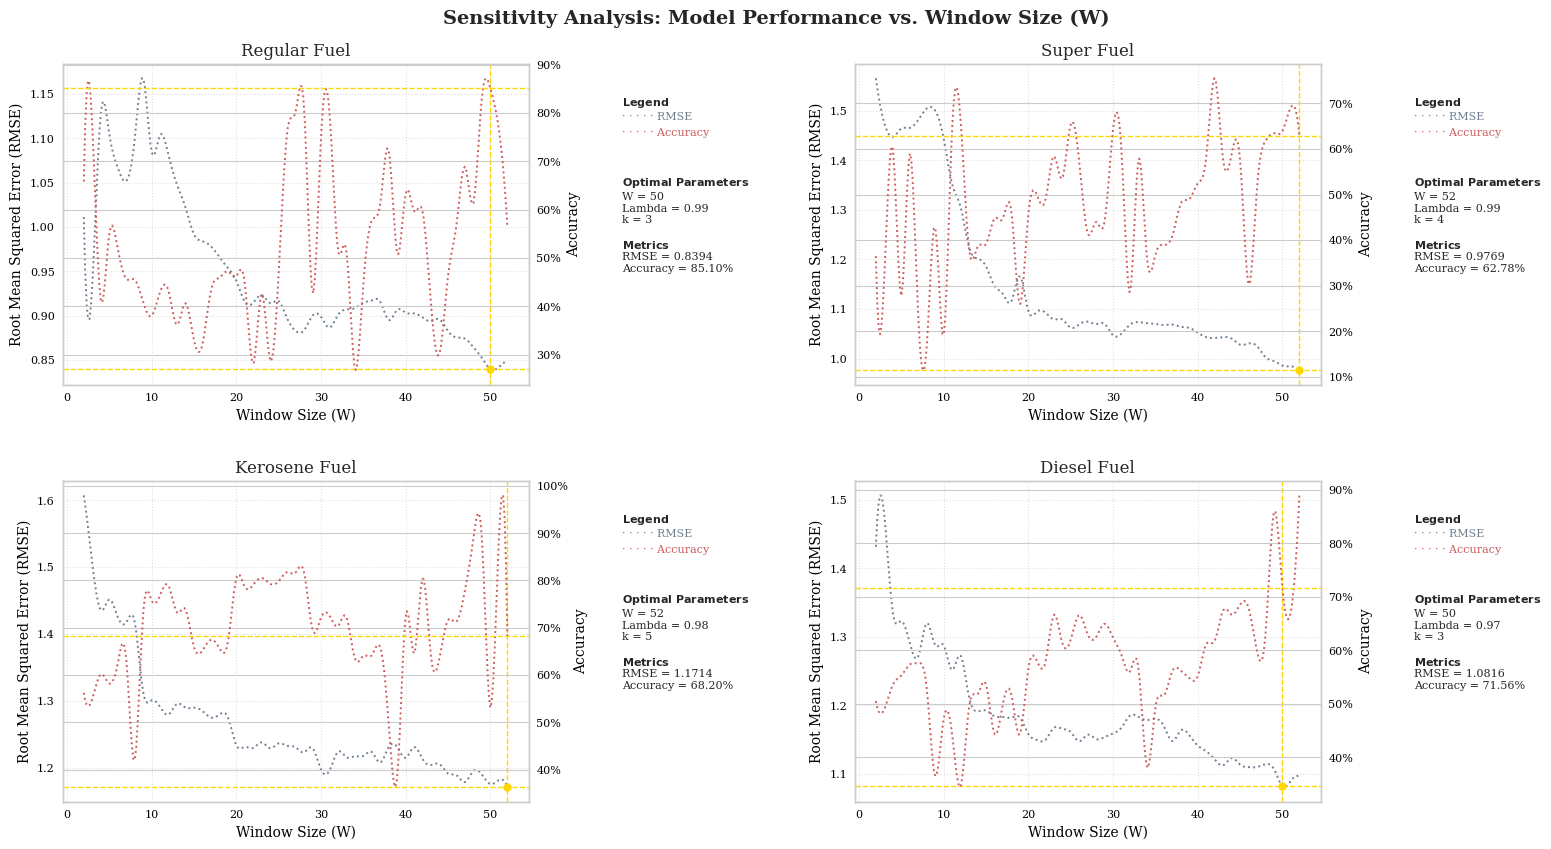


✅ Gráfico final V6 guardado exitosamente en:
optimized_outputs\W_sensitivity_analysis_final_v6.png


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import FuncFormatter

print("--- Iniciando la generación de gráficos de alta calidad para publicación (v6) ---")

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

if 'OUTPUT_FOLDER_OPTIMIZED' in locals():
    summary_csv_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, "21_grid_search_summary.csv")

    if os.path.exists(summary_csv_path):
        print(f"Cargando datos desde: {summary_csv_path}")
        df_summary = pd.read_csv(summary_csv_path)

        # --- 2. ESTILO TIPO IEEE Y PREPARACIÓN DE LA FIGURA ---
        
        plt.style.use('seaborn-v0_8-paper')
        plt.rcParams.update({
            "font.family": "serif", "font.size": 10, "axes.titlesize": 12,
            "axes.labelsize": 10, "xtick.labelsize": 8, "ytick.labelsize": 8,
            "figure.titlesize": 14, "axes.labelcolor": "black",
            "xtick.color": "black", "ytick.color": "black"
        })

        fig, axes = plt.subplots(2, 2, figsize=(17, 9))
        fig.suptitle('Sensitivity Analysis: Model Performance vs. Window Size (W)', fontweight='bold')
        
        fuel_positions = {
            'Regular': axes[0, 0], 'Super': axes[0, 1],
            'Kerosene': axes[1, 0], 'Diesel': axes[1, 1]
        }
        
        def to_percent(y, position):
            return f"{100 * y:.0f}%"

        # --- 3. LÓGICA DE PROCESAMIENTO Y GRÁFICO POR COMBUSTIBLE ---

        ACCURACY_THRESHOLD = 0.95
        
        for fuel_name, ax in fuel_positions.items():
            print(f"Procesando y graficando para: {fuel_name}...")
            
            df_fuel = df_summary[df_summary['Fuel Series'] == fuel_name]
            df_realistic = df_fuel[df_fuel['Accuracy'] < ACCURACY_THRESHOLD].copy()

            if df_realistic.empty or len(df_realistic['W'].unique()) < 4:
                ax.text(0.5, 0.5, 'Not enough data for smooth plot', ha='center', va='center')
                ax.set_title(f'{fuel_name} Fuel (Insufficient Data)')
                continue

            best_rmse_per_w = df_realistic.loc[df_realistic.groupby('W')['RMSE'].idxmin()]
            best_rmse_per_w = best_rmse_per_w.sort_values('W')
            
            W_orig, RMSE_orig, Acc_orig = best_rmse_per_w['W'], best_rmse_per_w['RMSE'], best_rmse_per_w['Accuracy']
            W_smooth = np.linspace(W_orig.min(), W_orig.max(), 300)
            spl_rmse = make_interp_spline(W_orig, RMSE_orig, k=3)
            spl_acc = make_interp_spline(W_orig, Acc_orig, k=3)
            RMSE_smooth, Acc_smooth = spl_rmse(W_smooth), spl_acc(W_smooth)
            
            ax.set_xlabel('Window Size (W)')
            ax.set_ylabel('Root Mean Squared Error (RMSE)')
            ax.plot(W_smooth, RMSE_smooth, color='slategray', linestyle=':')
            
            ax2 = ax.twinx()
            ax2.set_ylabel('Accuracy')
            ax2.plot(W_smooth, Acc_smooth, color='indianred', linestyle=':')
            ax2.yaxis.set_major_formatter(FuncFormatter(to_percent))
            
            best_point = best_rmse_per_w.loc[best_rmse_per_w['RMSE'].idxmin()]
            best_w, best_rmse, best_acc = best_point['W'], best_point['RMSE'], best_point['Accuracy']
            
            ax.axhline(y=best_rmse, color='gold', linestyle='--', linewidth=1)
            ax.axvline(x=best_w, color='gold', linestyle='--', linewidth=1)
            ax2.axhline(y=best_acc, color='gold', linestyle='--', linewidth=1)
            
            ax.plot(best_w, best_rmse, marker='o', markersize=6, markerfacecolor='gold', markeredgecolor='black', linestyle='None')

            info_text_params = (
                f"$\\bf{{Optimal\\ Parameters}}$\n"
                f"W = {best_point['W']}\n"
                f"Lambda = {best_point['Lambda']:.2f}\n"
                f"k = {int(best_point['k'])}\n\n"
                f"$\\bf{{Metrics}}$\n"
                f"RMSE = {best_rmse:.4f}\n"
                f"Accuracy = {best_acc:.2%}"
            )
            
            ax.text(1.2, 0.65, info_text_params, transform=ax.transAxes, fontsize=8,
                    verticalalignment='top', horizontalalignment='left')
            ax.text(1.2, 0.9, "$\\bf{Legend}$", transform=ax.transAxes, fontsize=8,
                    verticalalignment='top', horizontalalignment='left')
            ax.text(1.2, 0.85, "· · · · · RMSE", transform=ax.transAxes, fontsize=8, color='slategray',
                    verticalalignment='top', horizontalalignment='left')
            ax.text(1.2, 0.80, "· · · · · Accuracy", transform=ax.transAxes, fontsize=8, color='indianred',
                    verticalalignment='top', horizontalalignment='left')

            ax.set_title(f'{fuel_name} Fuel')
            ax.grid(True, linestyle=':', alpha=0.6)

        # --- 4. GUARDAR Y MOSTRAR LA FIGURA COMBINADA ---
        
        fig.subplots_adjust(left=0.08, right=0.82, top=0.92, bottom=0.1, wspace=0.7, hspace=0.3)
        
        output_filename = "W_sensitivity_analysis_final_v6.png"
        output_path = os.path.join(OUTPUT_FOLDER_OPTIMIZED, output_filename)
        
        plt.savefig(output_path, dpi=600)
        
        # --- LÍNEA AÑADIDA PARA MOSTRAR EL GRÁFICO ---
        plt.show()
        # -------------------------------------------
        
        plt.close(fig) # Se mantiene para liberar memoria después de mostrar/guardar

        print("\n" + "="*80)
        print(f"✅ Gráfico final V6 guardado exitosamente en:")
        print(output_path)
        print("="*80)
        
    else:
        print(f"ERROR: No se encontró el archivo de resumen en la ruta: {summary_csv_path}")
else:
    print("ERROR: La variable 'OUTPUT_FOLDER_OPTIMIZED' no fue encontrada.")